In [1]:
import pandas as pd
import h5py
import os
import matplotlib.pyplot as plt, mpld3
import numpy as np
import time
import seaborn as sns
import calendar

from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm

In [2]:
# List of all the filenames to read the data from
directory_path = 'C:/Users/darshan.sangani/Documents/2020_Challenge_IOT_Analytics/csv_files'
file_names = [os.path.join(directory_path, file) for file in os.listdir(directory_path)]

# First analysis:
Trying different approach by appending datetimebucket as a feature. This is an artifically created attribute which will be utilized as an important attribute

In [8]:
data = pd.read_csv(file_names[0])
filename = file_names[0]
vals = filename.split(sep='/')
vals = vals[-1].split(sep='\\')
vals = vals[-1].split(sep='_')
string_datetime = vals[1]+vals[2]
star_datetime = pd.to_datetime(string_datetime)
dates = pd.date_range(star_datetime, periods=len(data), freq='1S')
dates.columns = ['DatetimeBucket']
# Inserting datetime column as first in the dataframe
data.insert(loc=0, column='DatetimeBucket', value=dates)

for i in tqdm(range(1, len(file_names))):
    new_data = pd.read_csv(file_names[i])
    filename = file_names[i]
    vals = filename.split(sep='/')
    vals = vals[-1].split(sep='\\')
    vals = vals[-1].split(sep='_')
    string_datetime = vals[1]+vals[2]
    star_datetime = pd.to_datetime(string_datetime)
    dates = pd.date_range(star_datetime, periods=len(new_data), freq='1S')
    dates.columns = ['DatetimeBucket']
    # Inserting datetime column as first in the dataframe
    new_data.insert(loc=0, column='DatetimeBucket', value=dates)
    data = data.append(new_data)
data.head()

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [12:22<00:00,  6.81s/it]


DatetimeBucket  Unnamed: 0  ch_1  ch_10  ch_100  ch_101  ch_102  \
0 2009-12-19 07:42:53         NaN   0.0    0.0     0.0     0.0     0.0   
1 2009-12-19 07:42:54         NaN   0.0    0.0     0.0     0.0     0.0   
2 2009-12-19 07:42:55         NaN   0.0    0.0     0.0     0.0     0.0   
3 2009-12-19 07:42:56         NaN   0.0   32.0     0.0     0.0     0.0   
4 2009-12-19 07:42:57         NaN   0.0   32.0     0.0     0.0     0.0   

   ch_103  ch_104  ch_105  ...  ch_90  ch_91  ch_92  ch_93  ch_94  ch_95  \
0     0.0     0.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1     0.0     0.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2     0.0     0.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3     0.0     0.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4     0.0     0.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

   ch_96  ch_97  ch_98  ch_99  
0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0  

[5 rows x 156 columns]

# 1. Trend in data

Going through the first file and looking at the trend based on the timestamp

c:\users\darshan.sangani\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
c:\users\darshan.sangani\appdata\local\programs\python\python36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


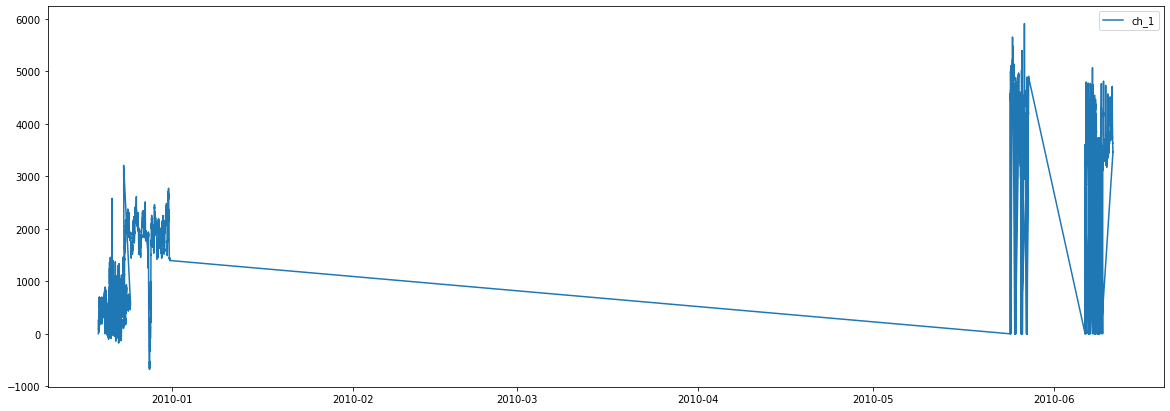

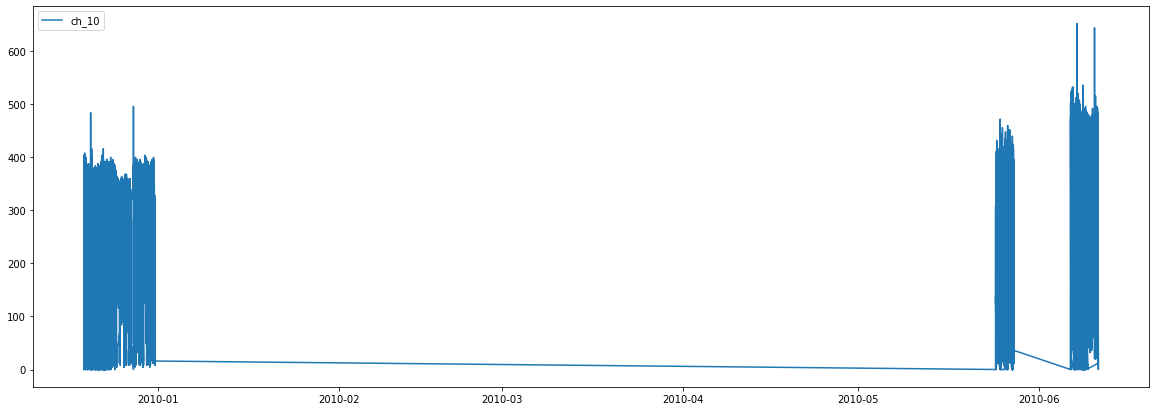

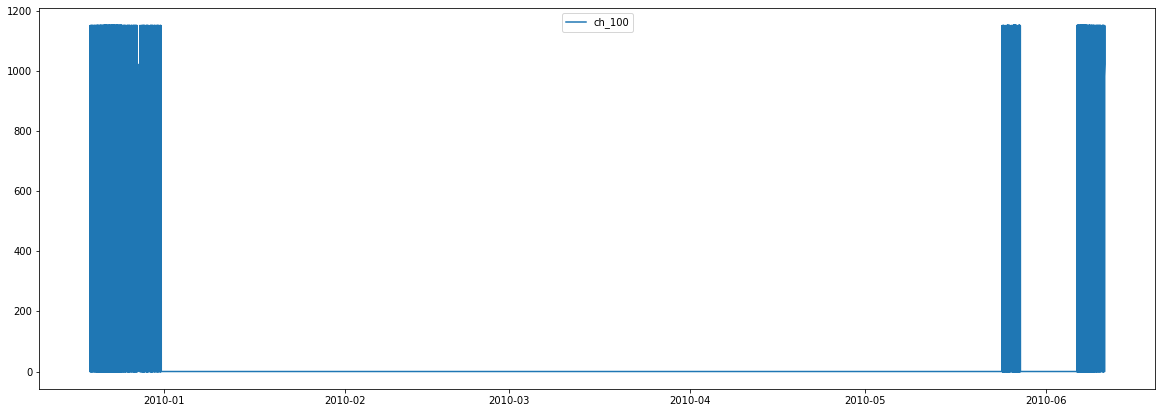

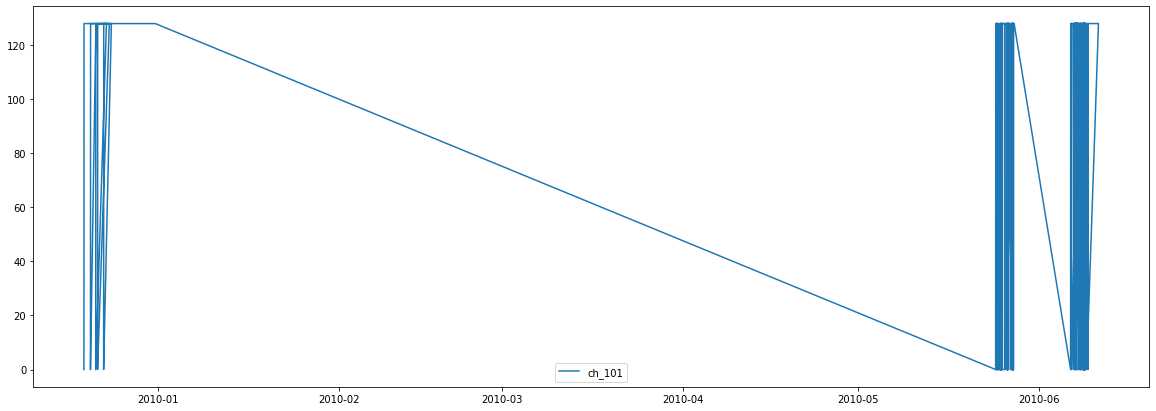

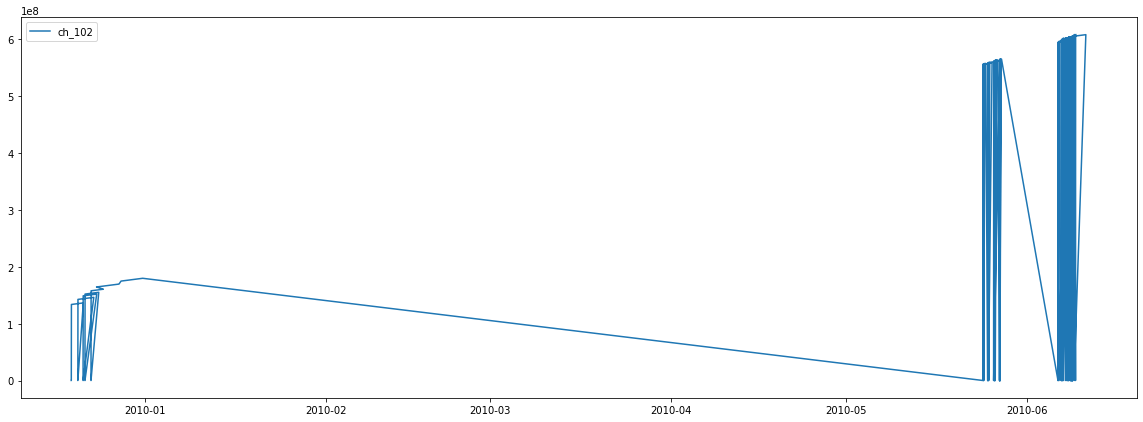

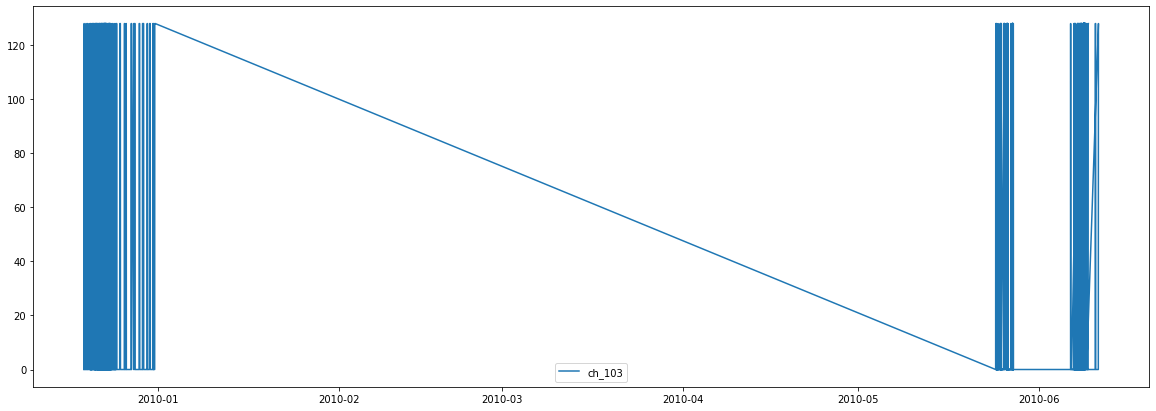

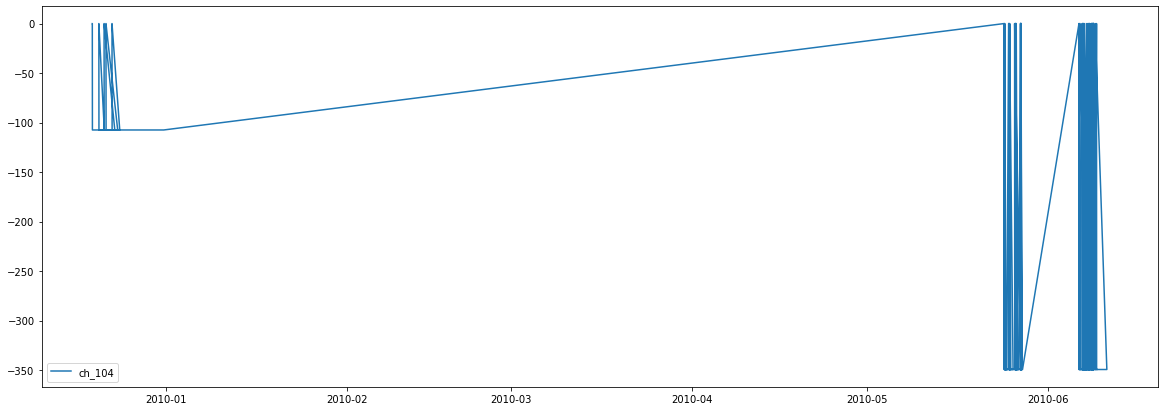

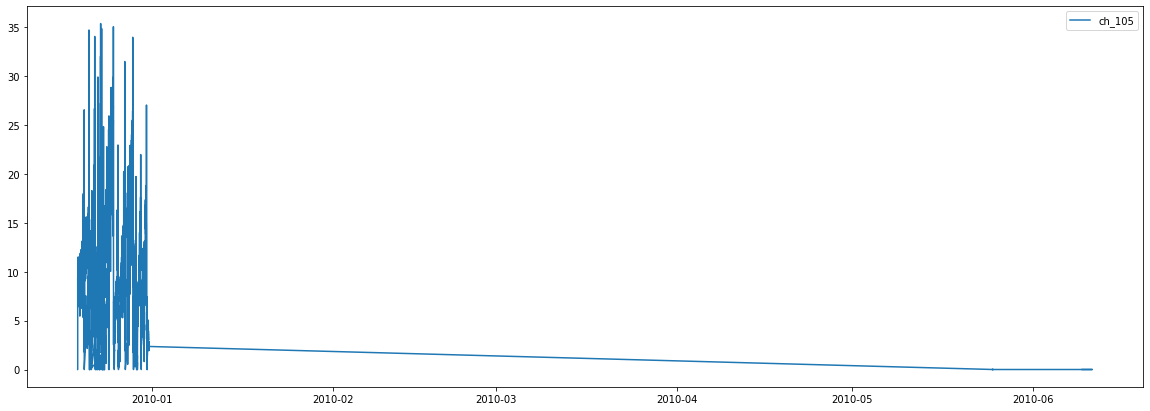

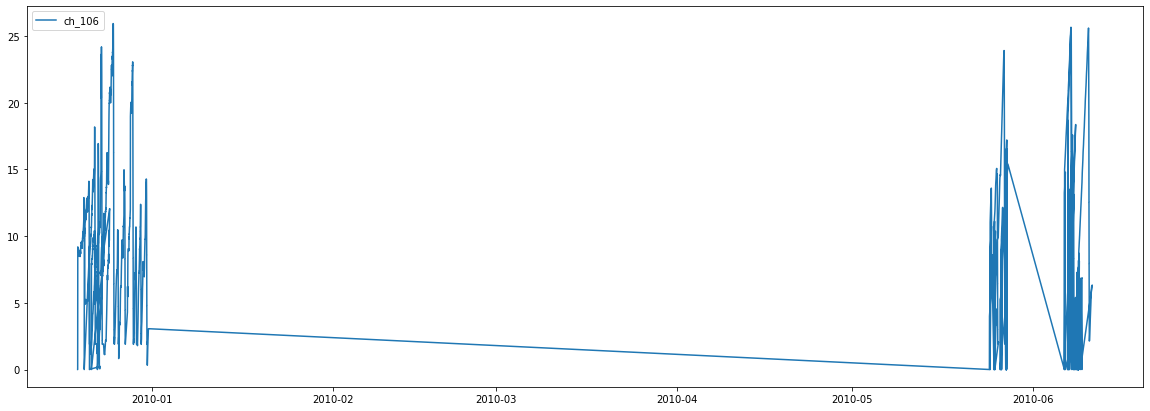

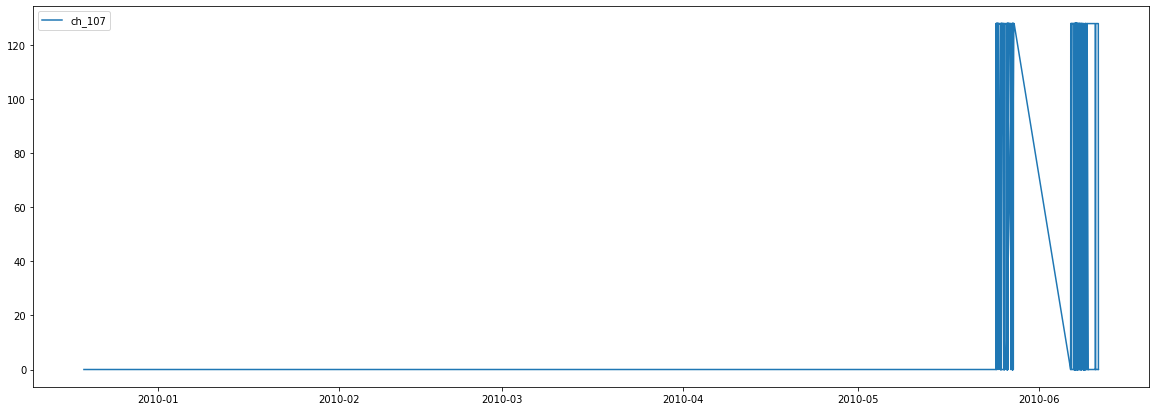

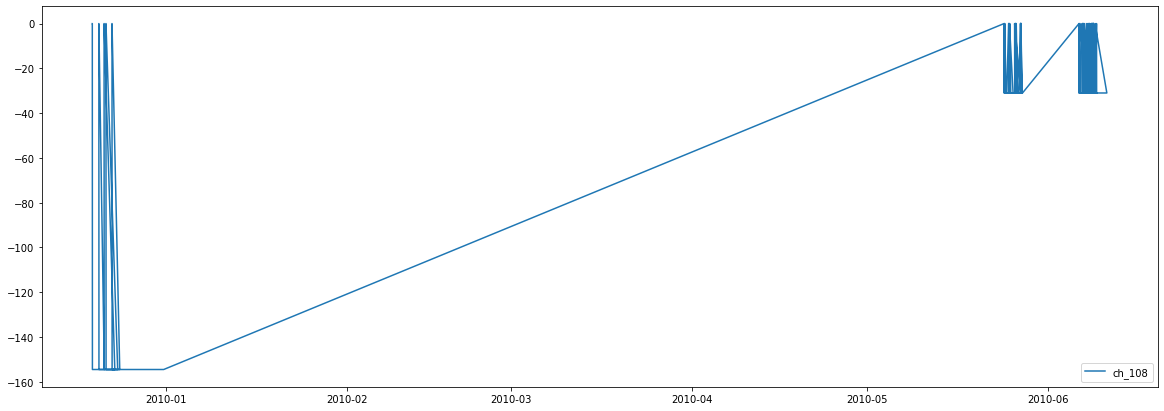

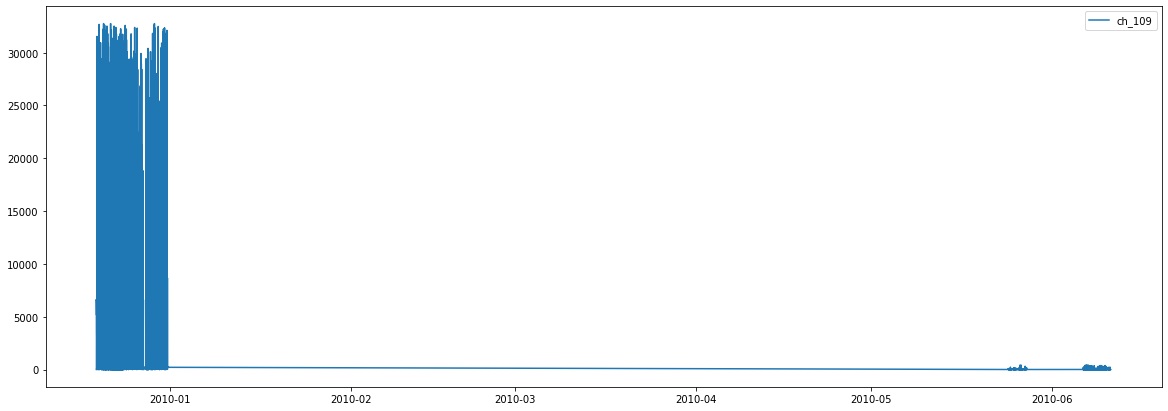

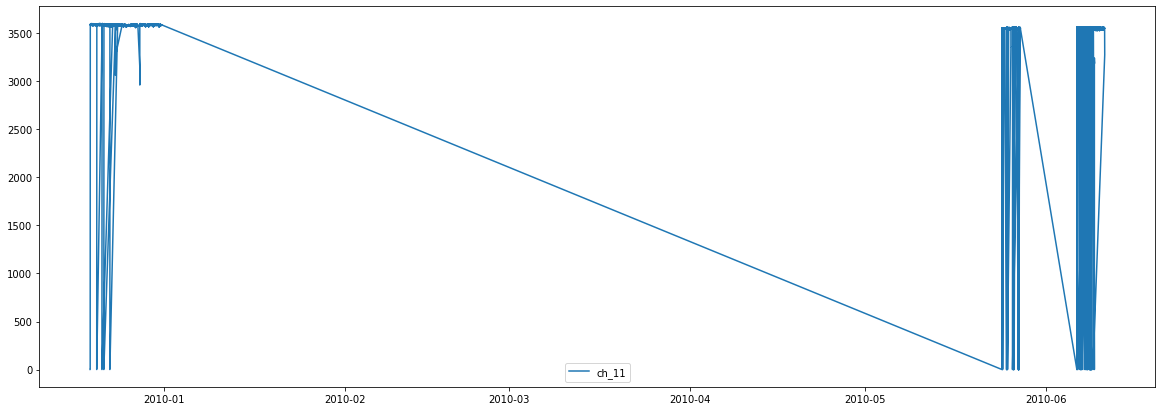

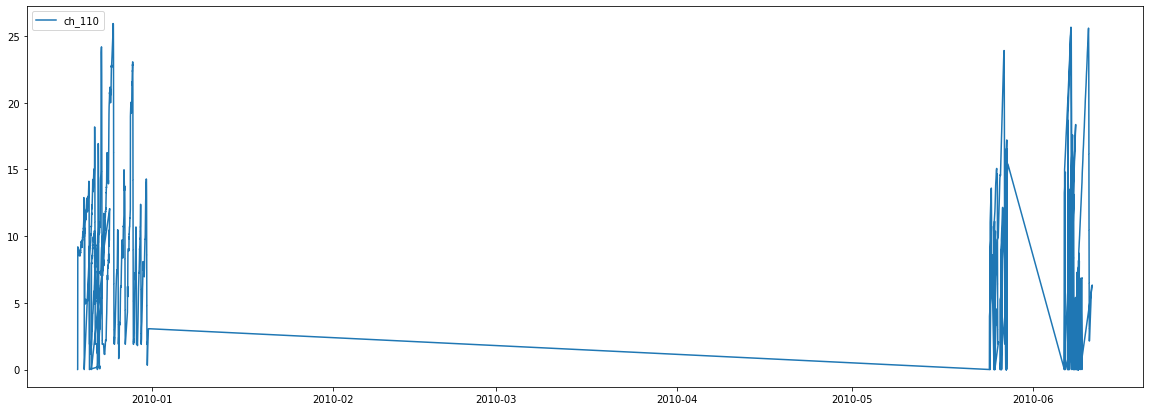

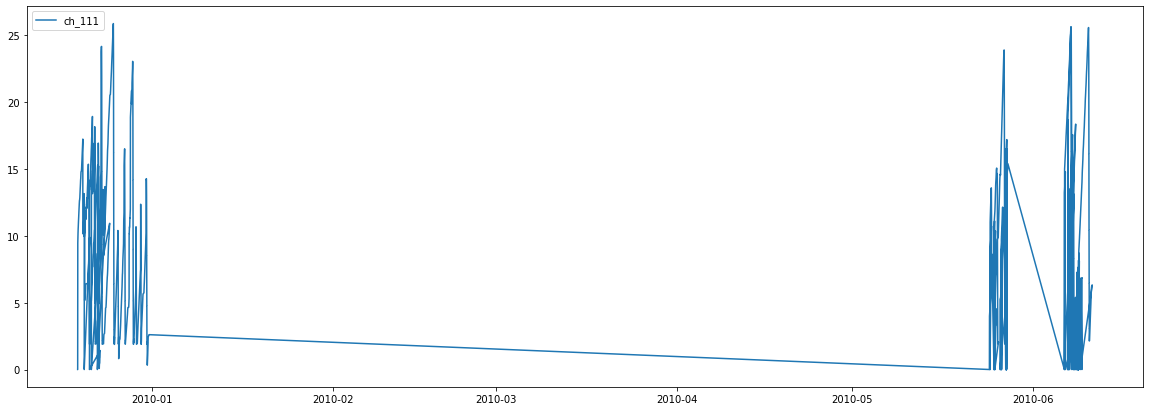

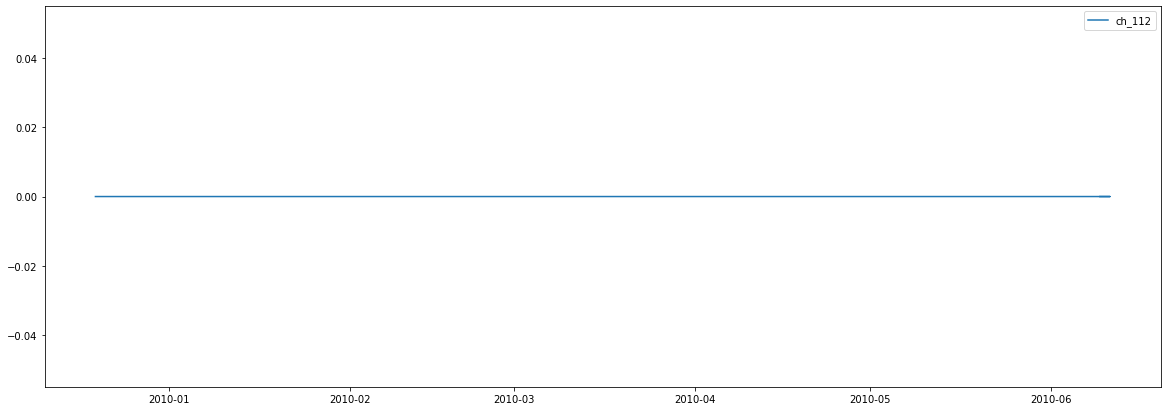

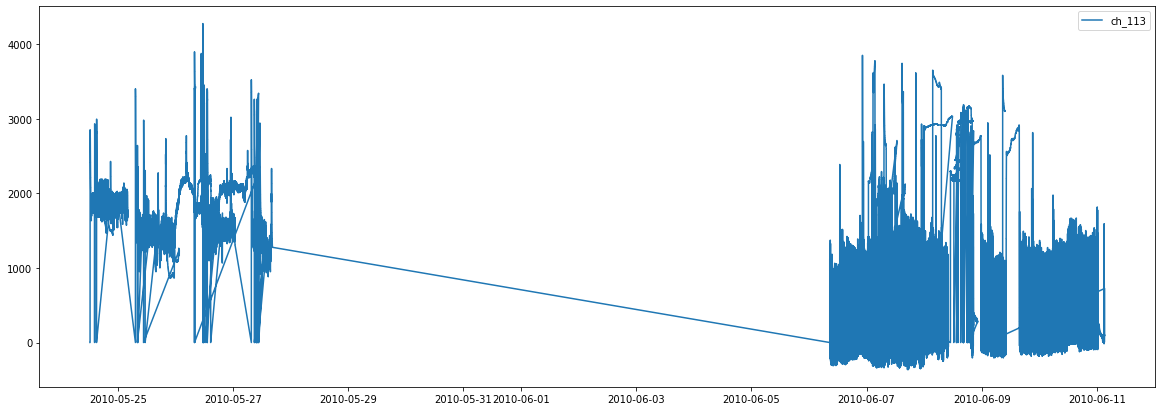

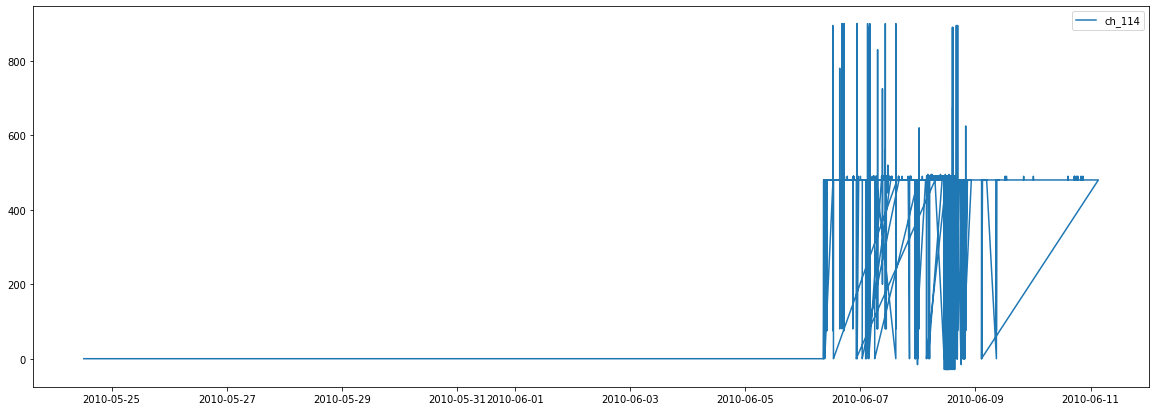

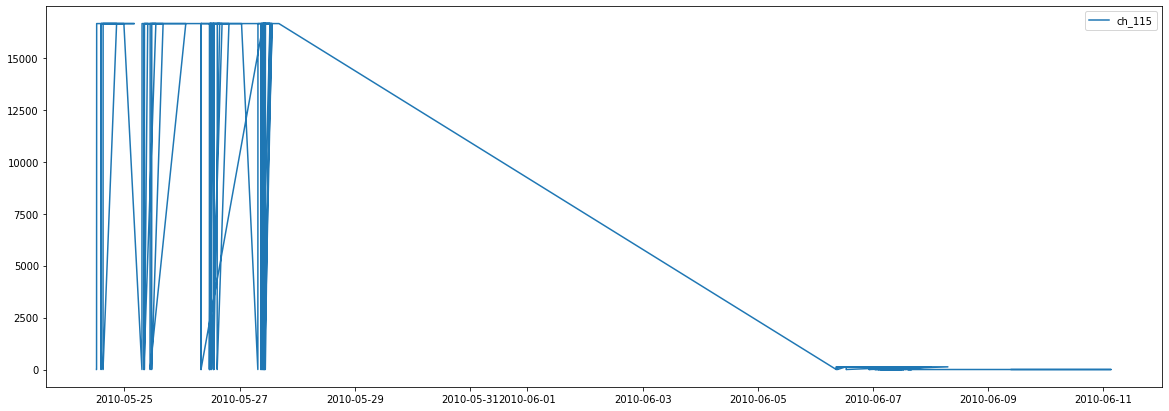

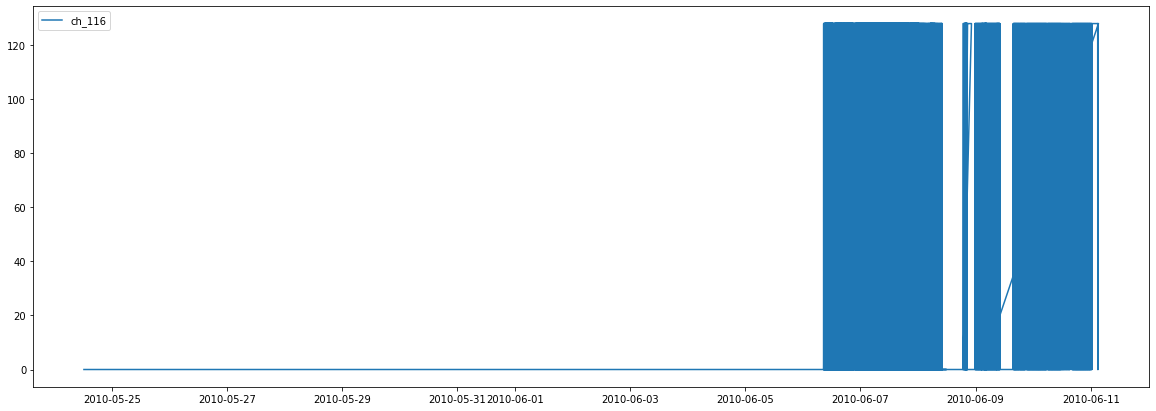

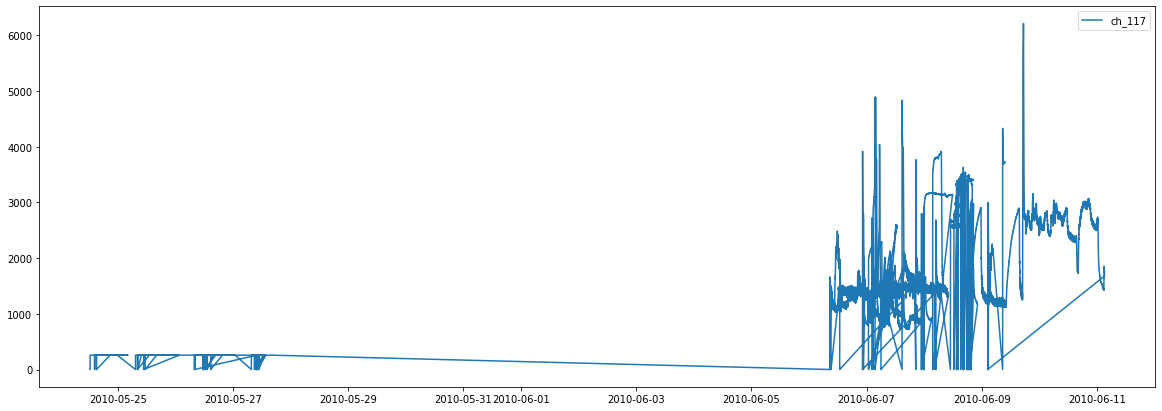

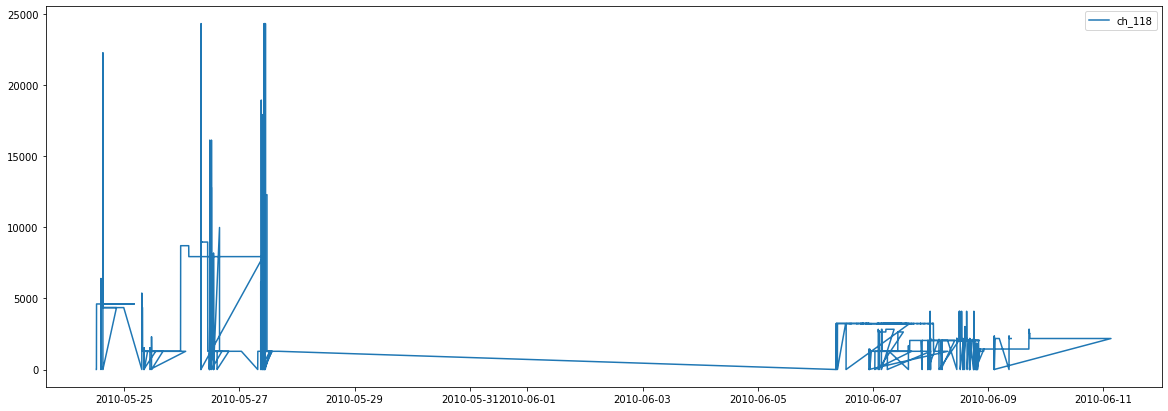

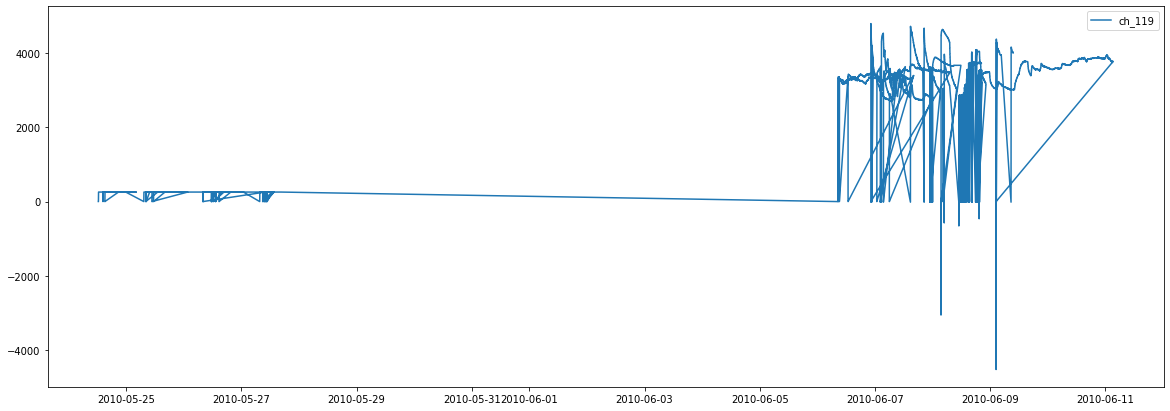

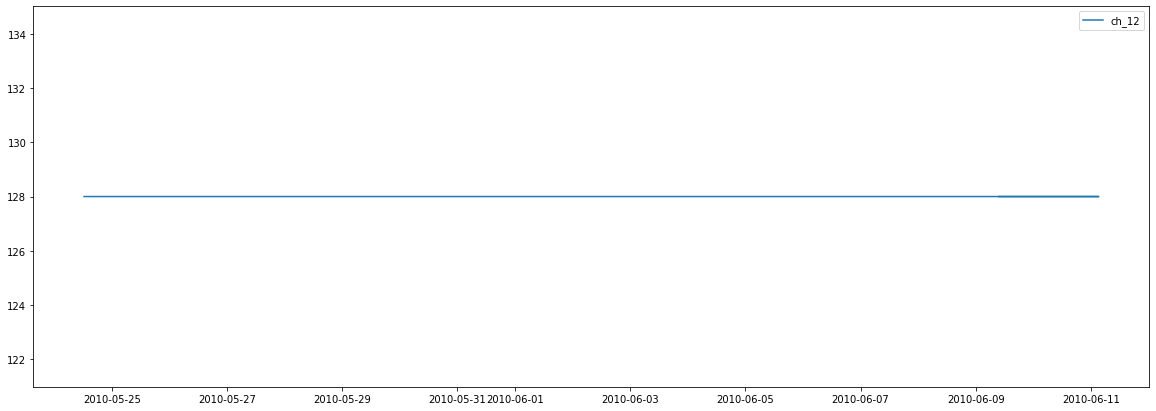

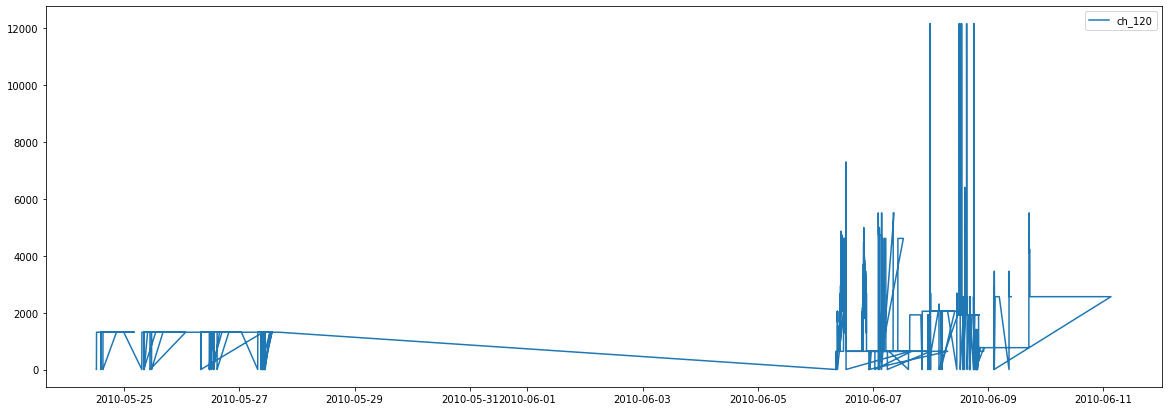

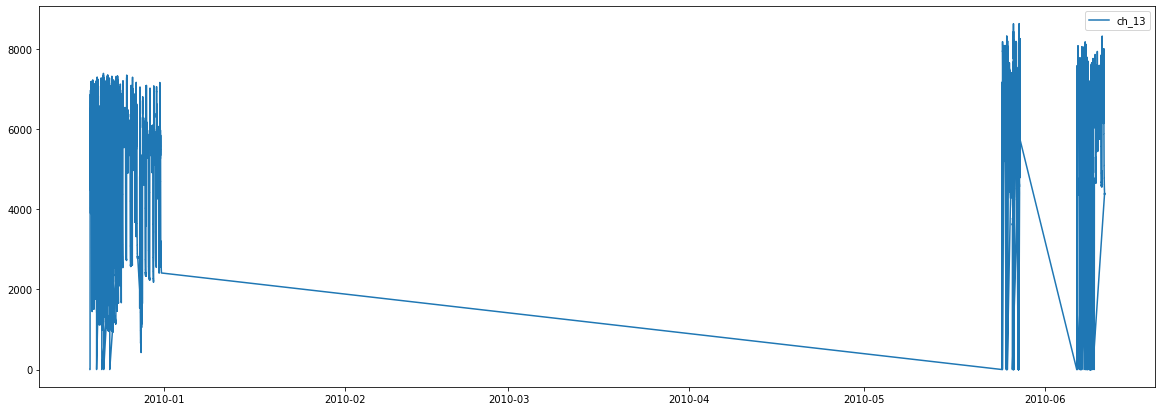

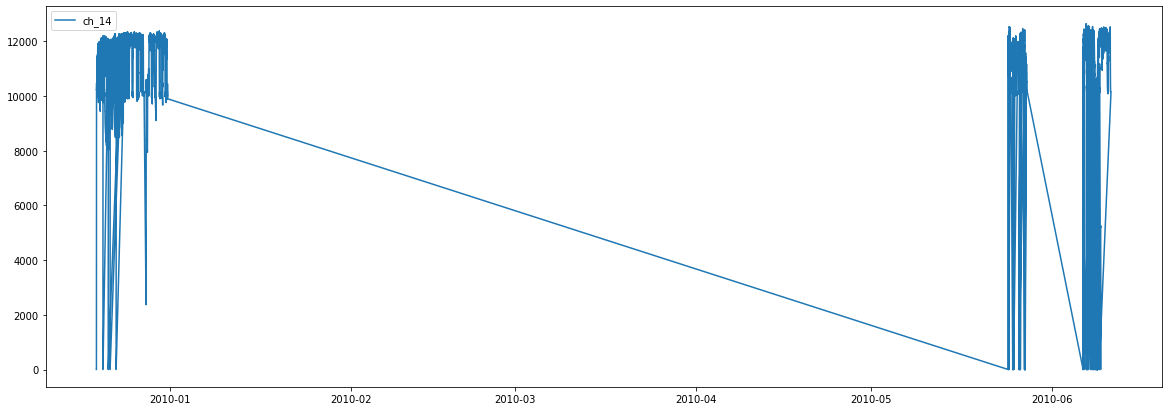

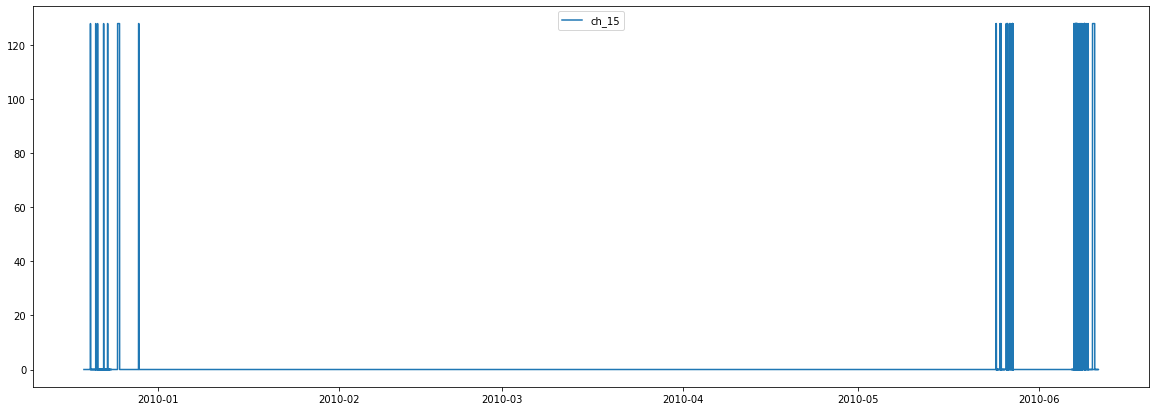

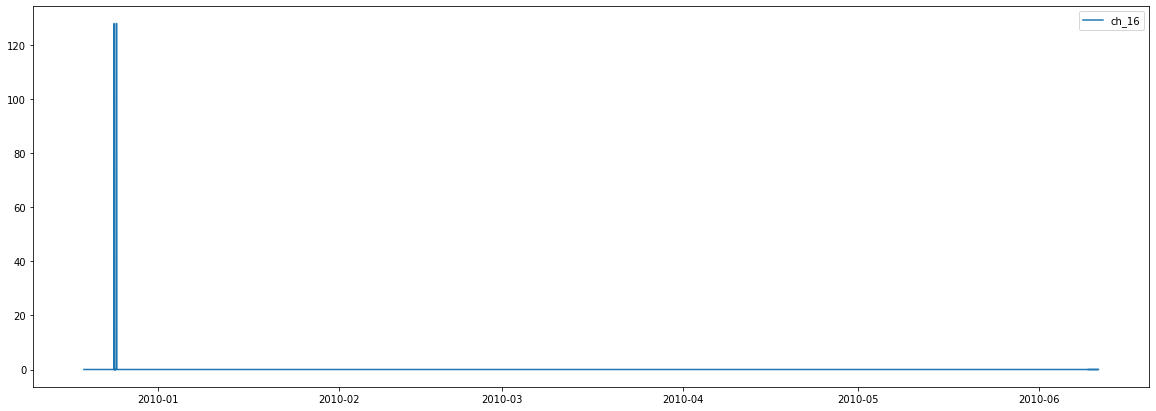

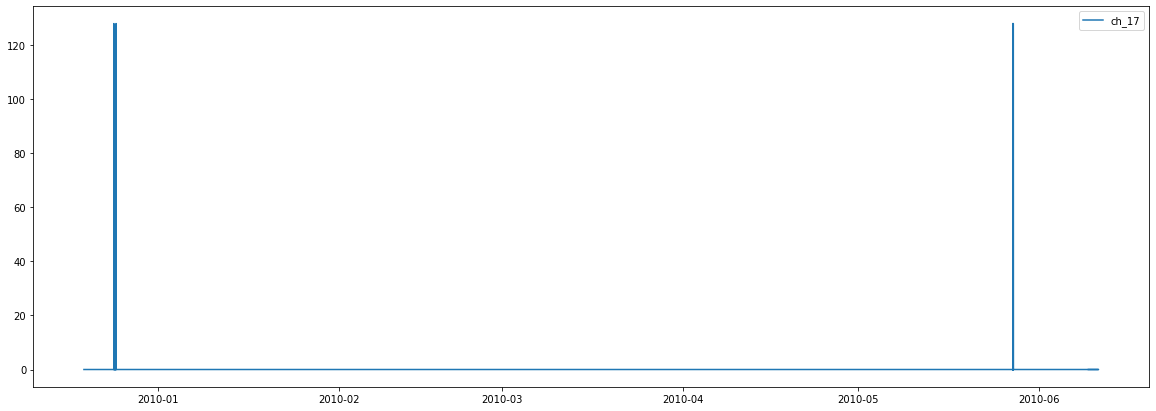

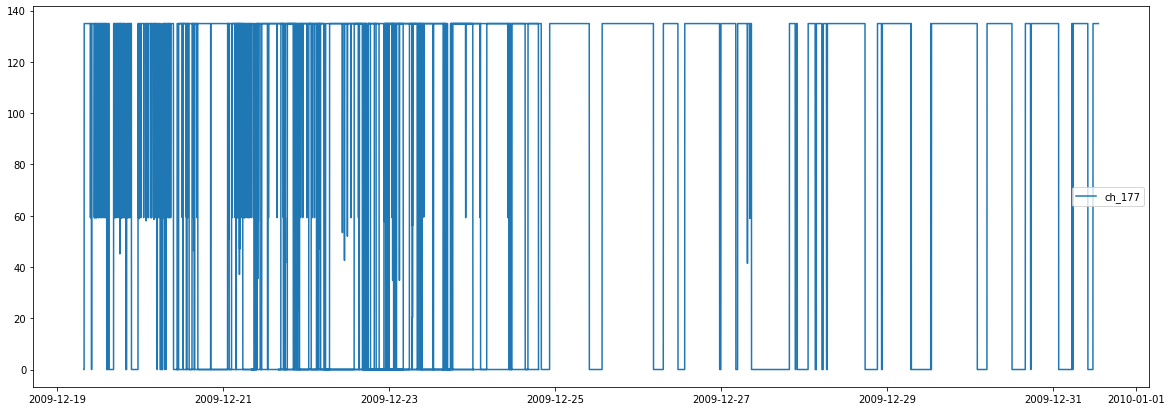

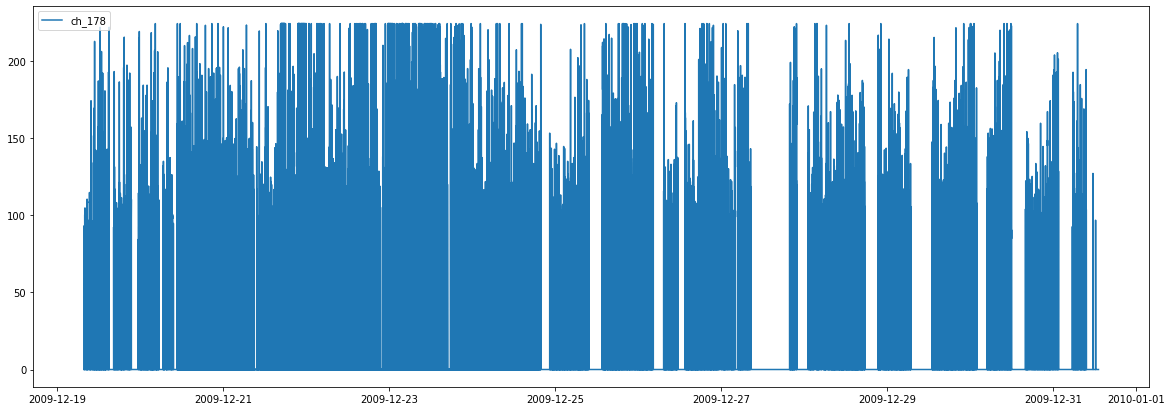

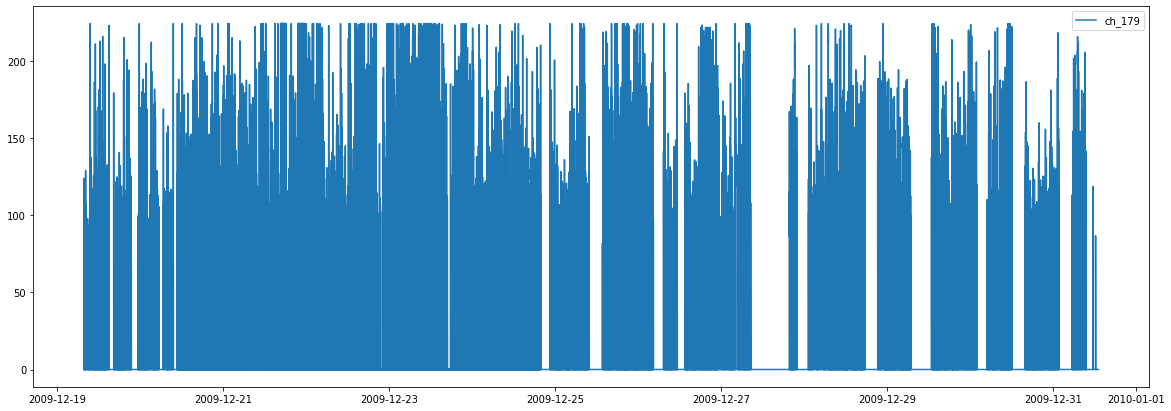

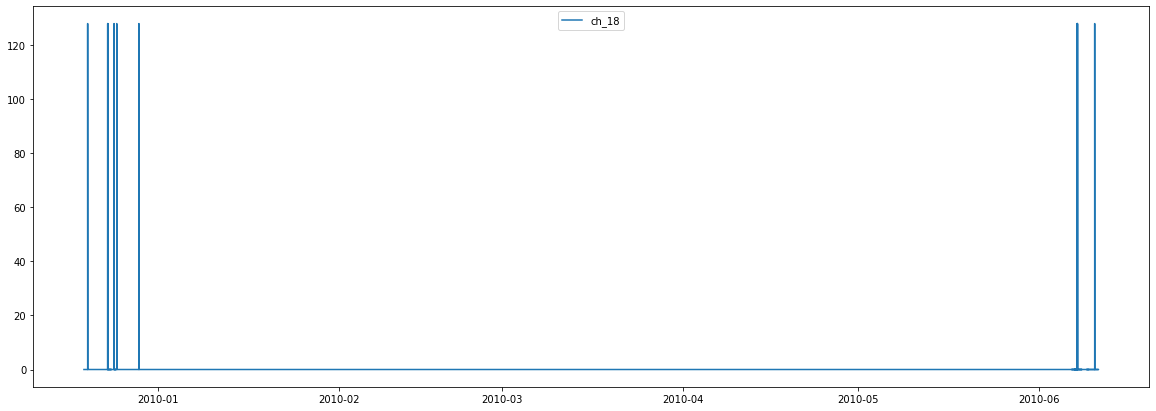

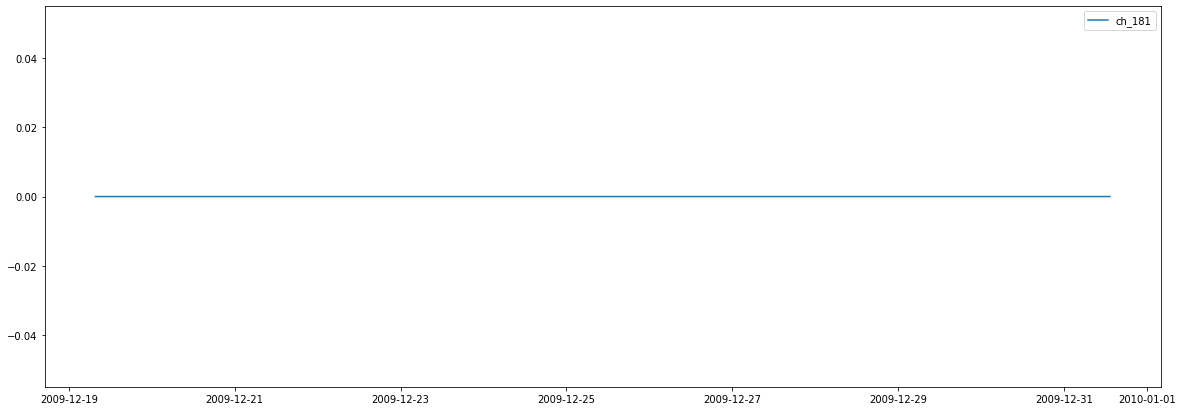

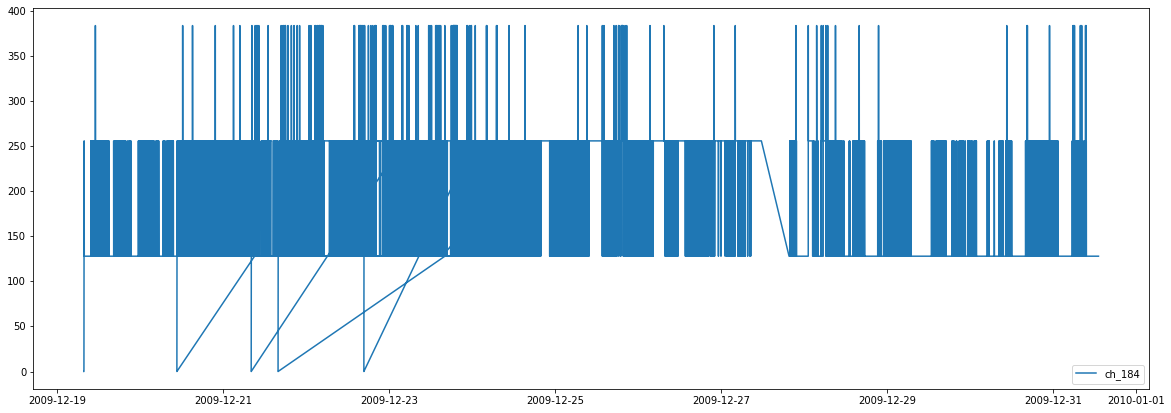

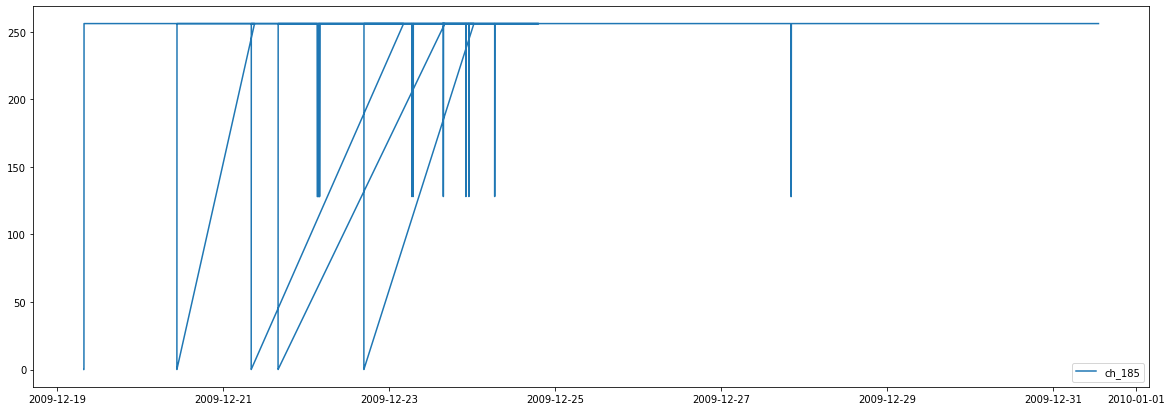

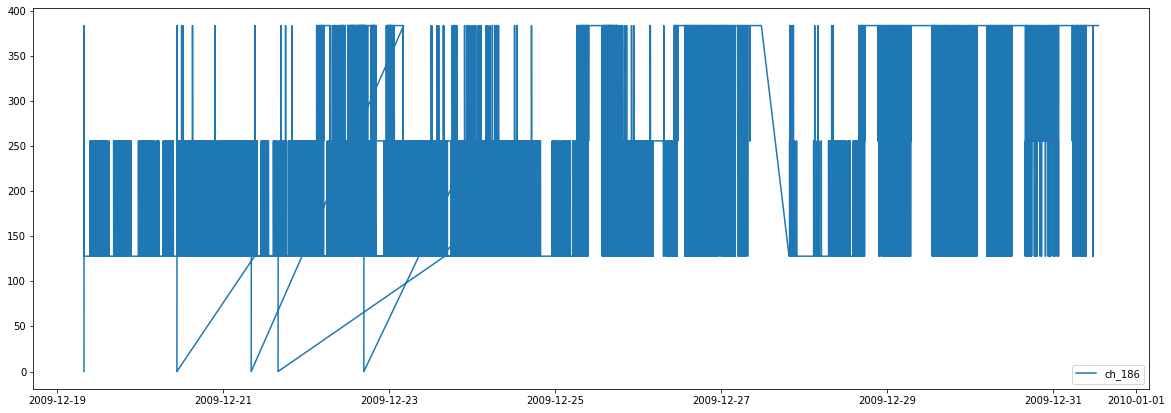

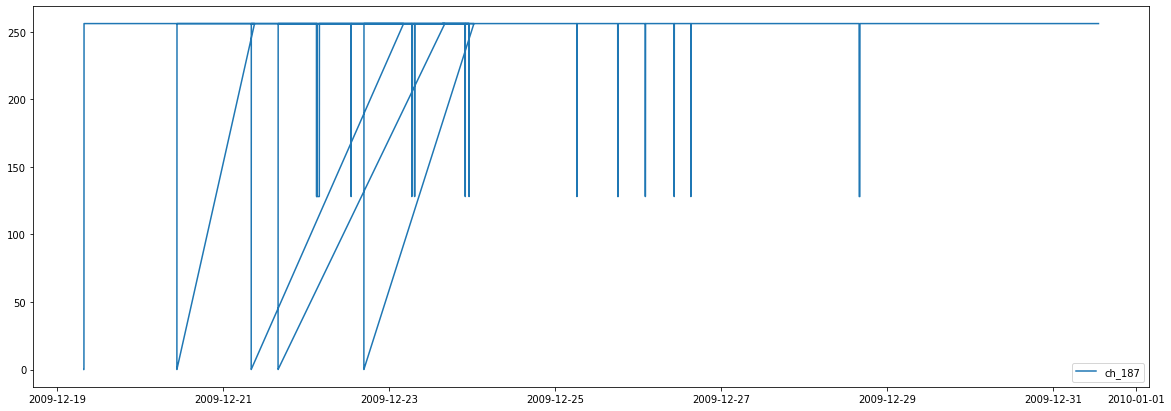

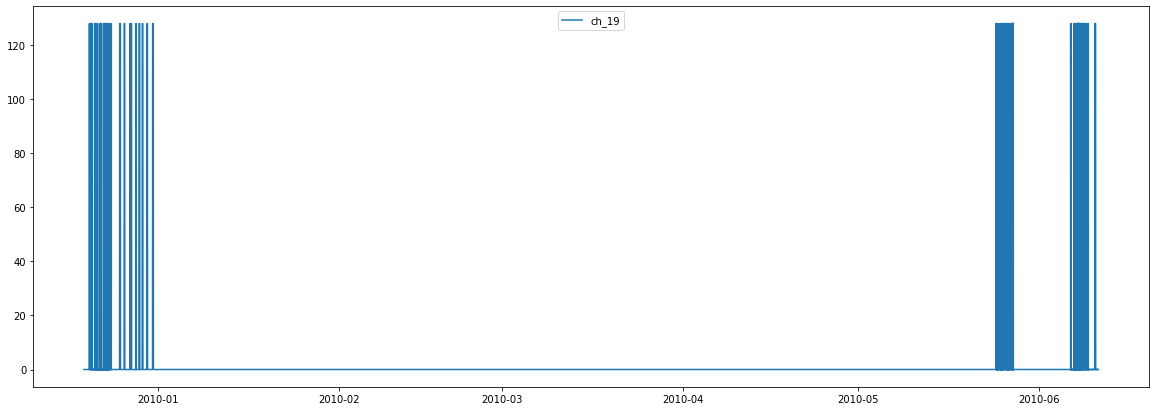

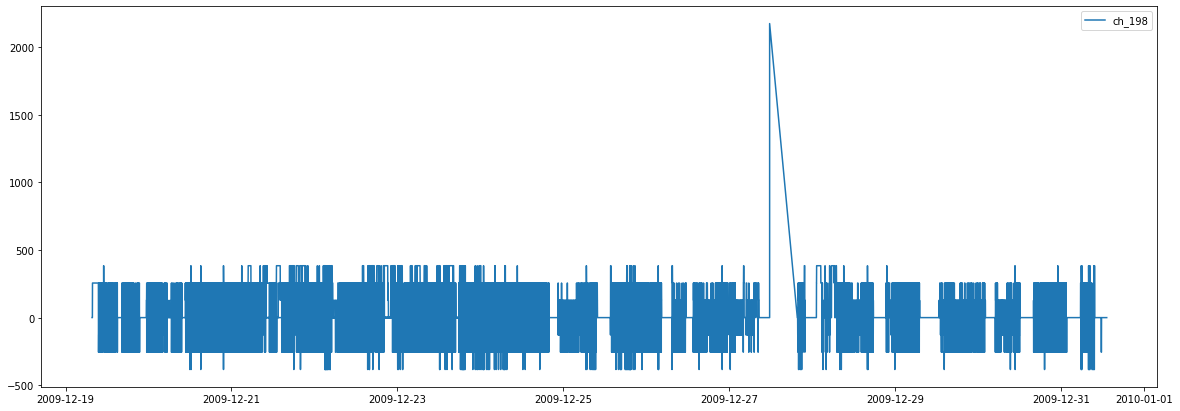

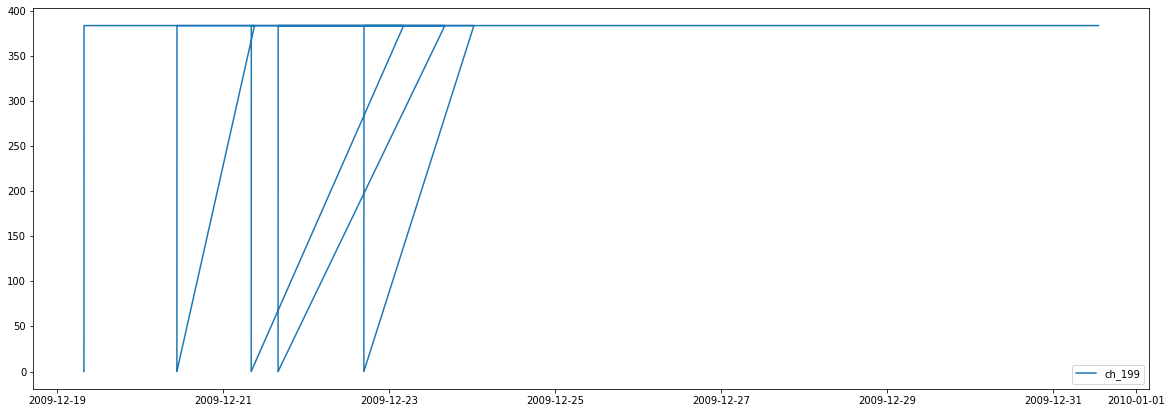

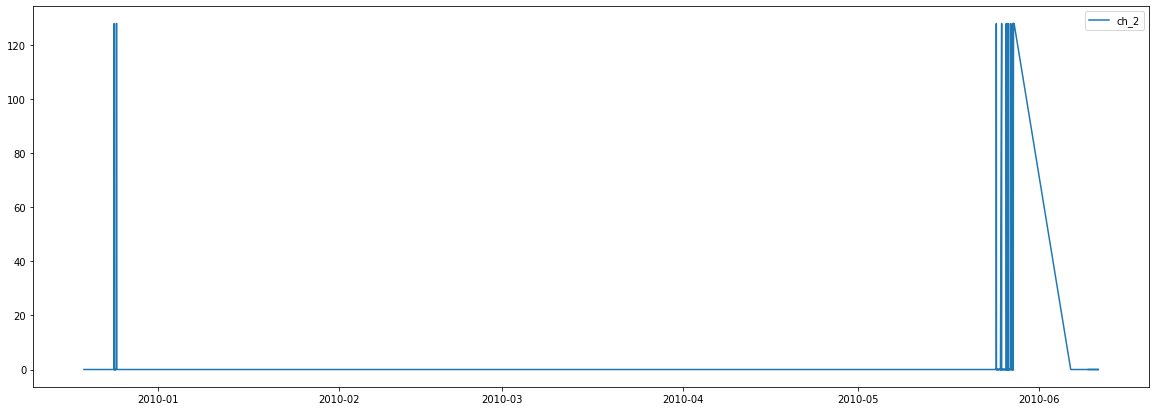

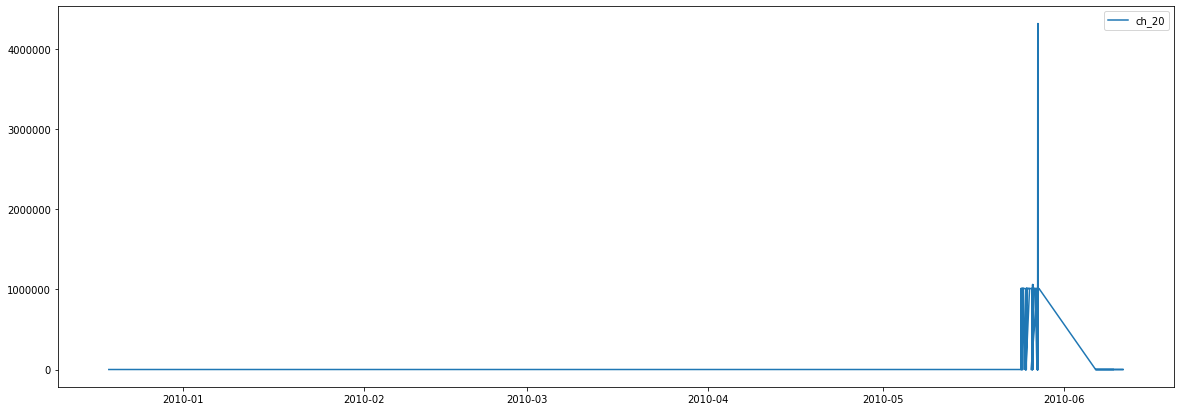

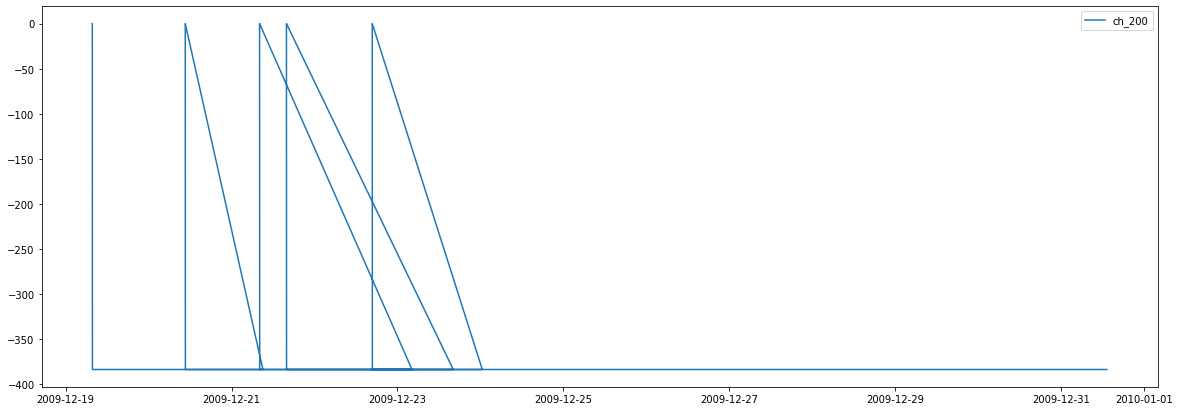

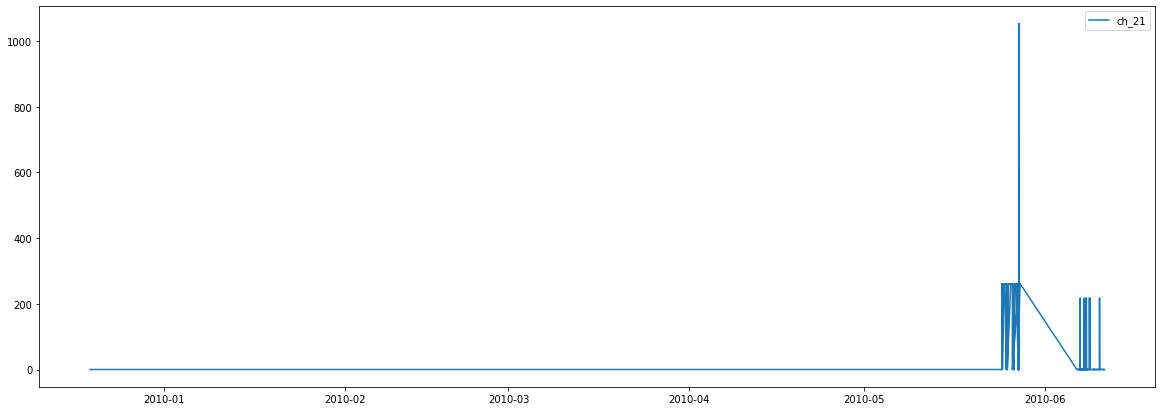

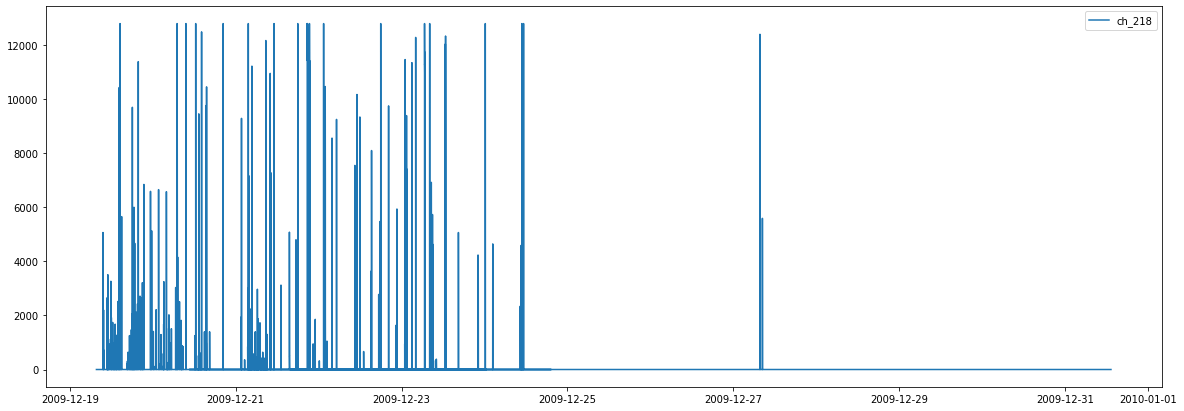

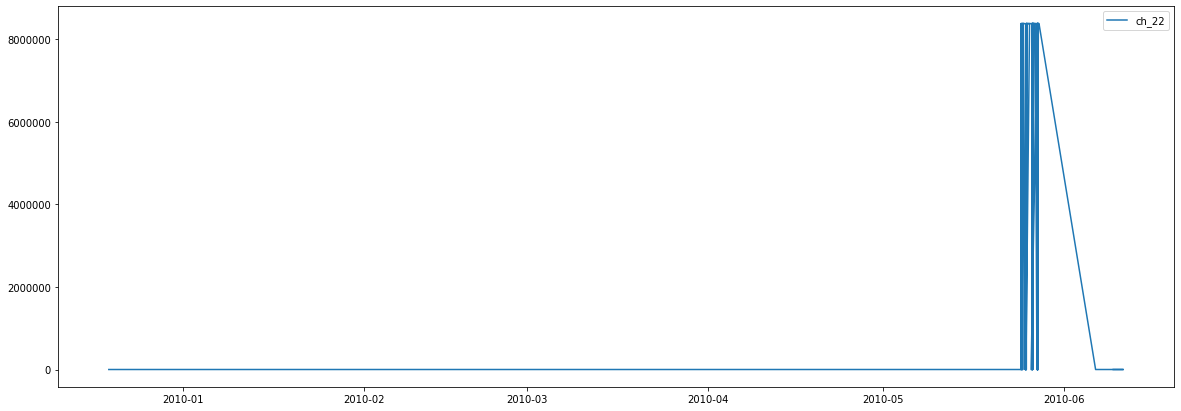

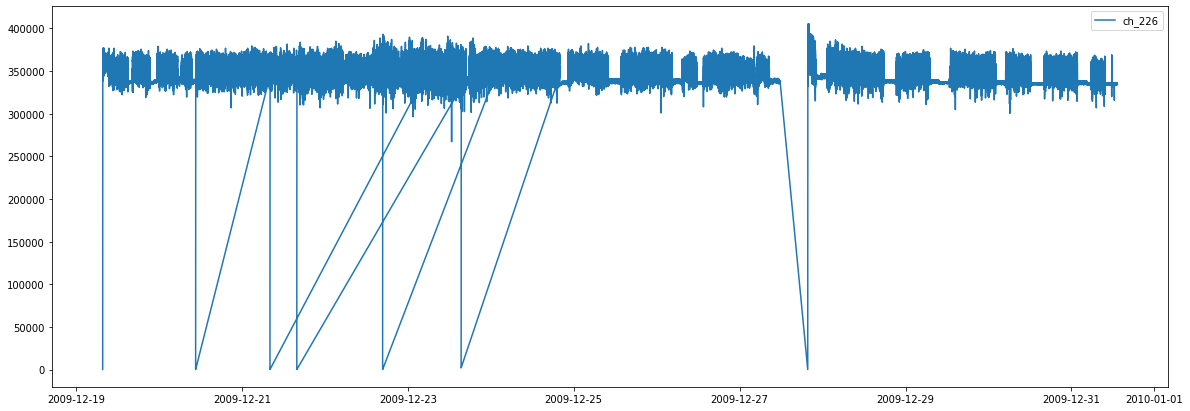

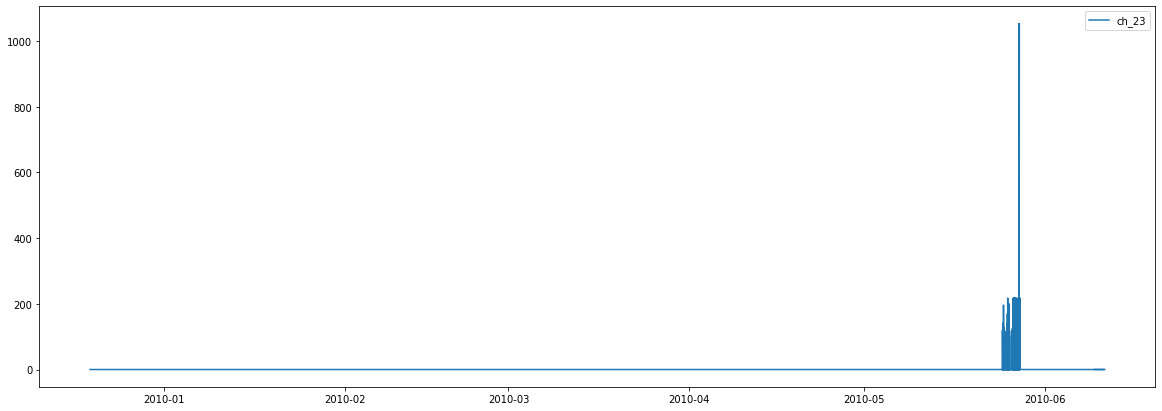

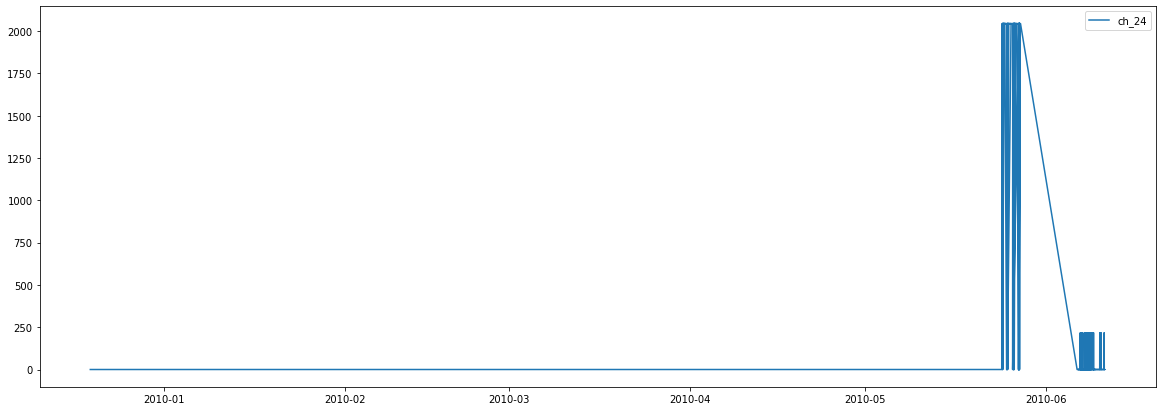

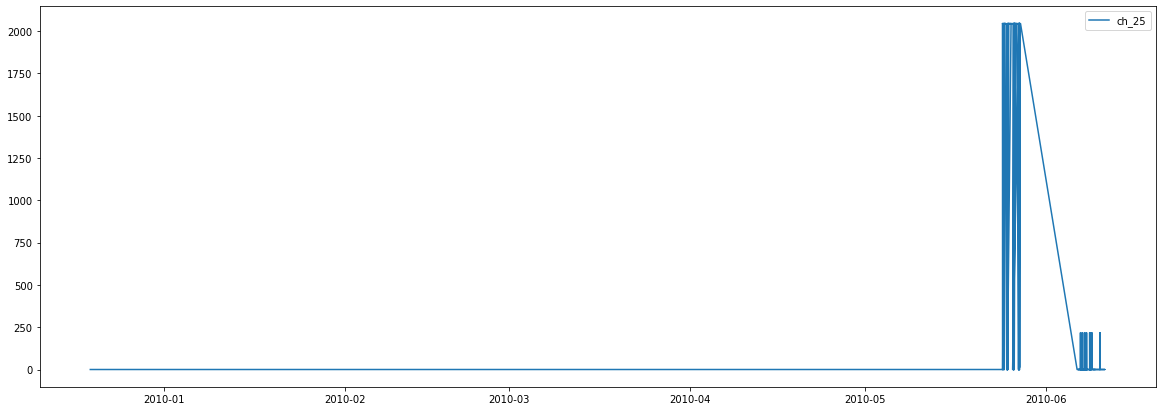

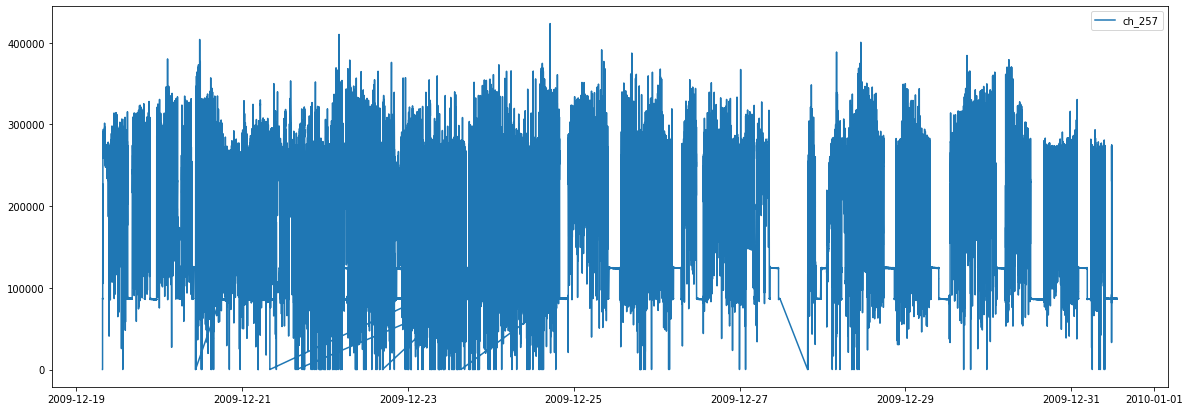

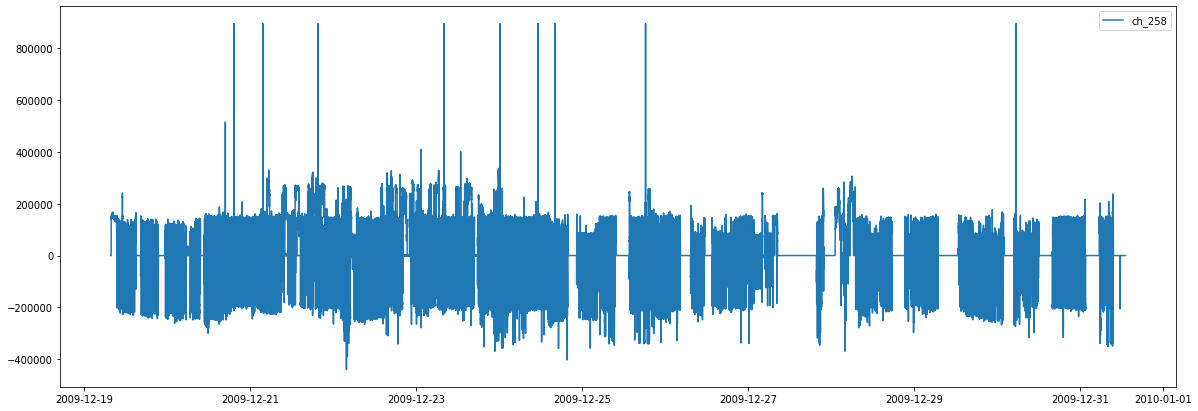

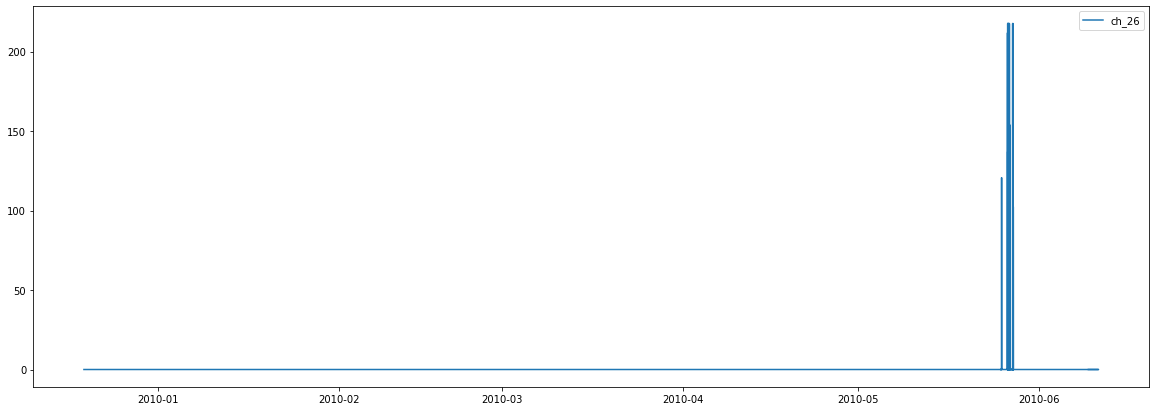

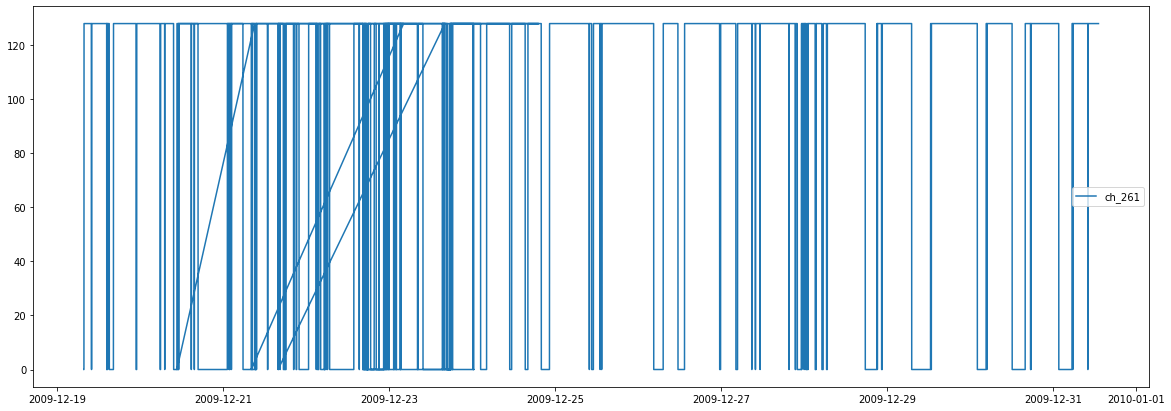

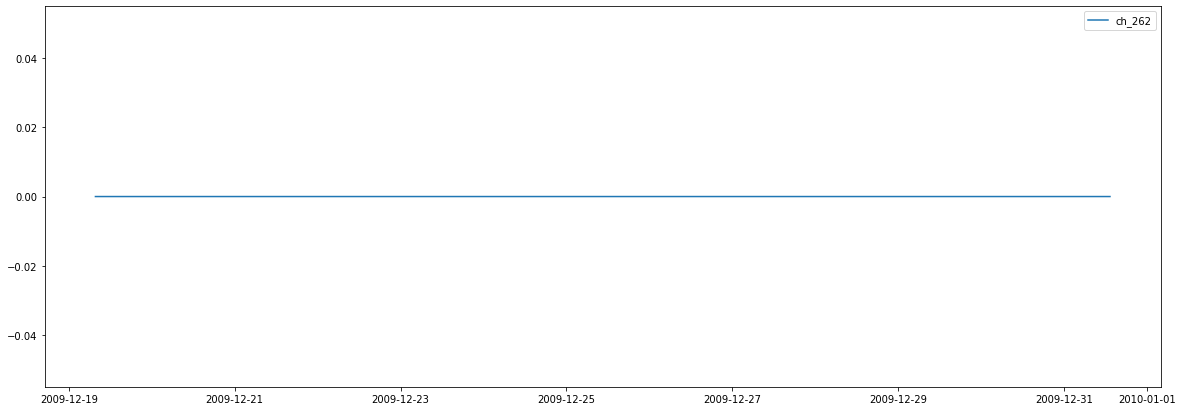

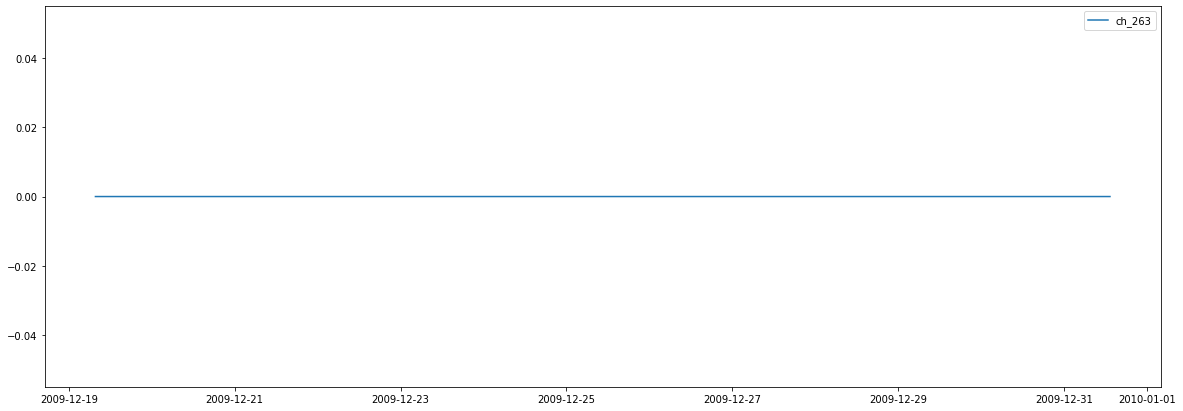

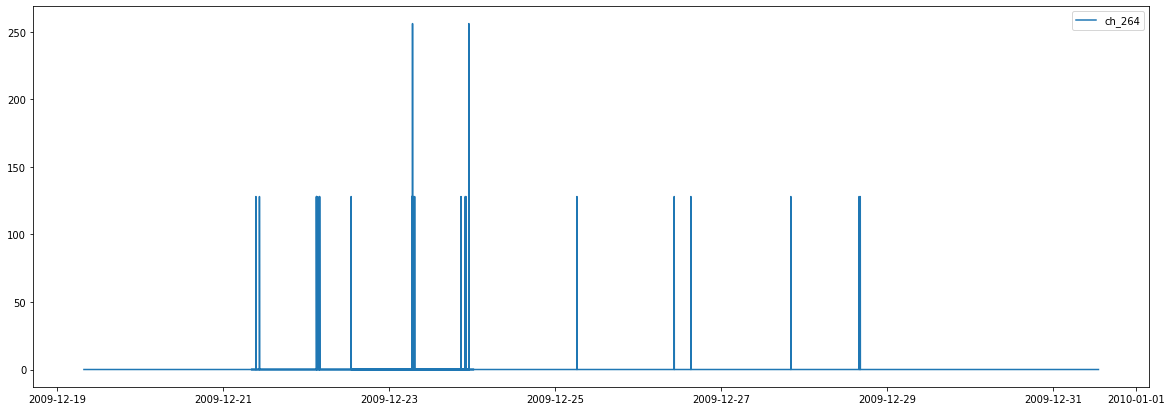

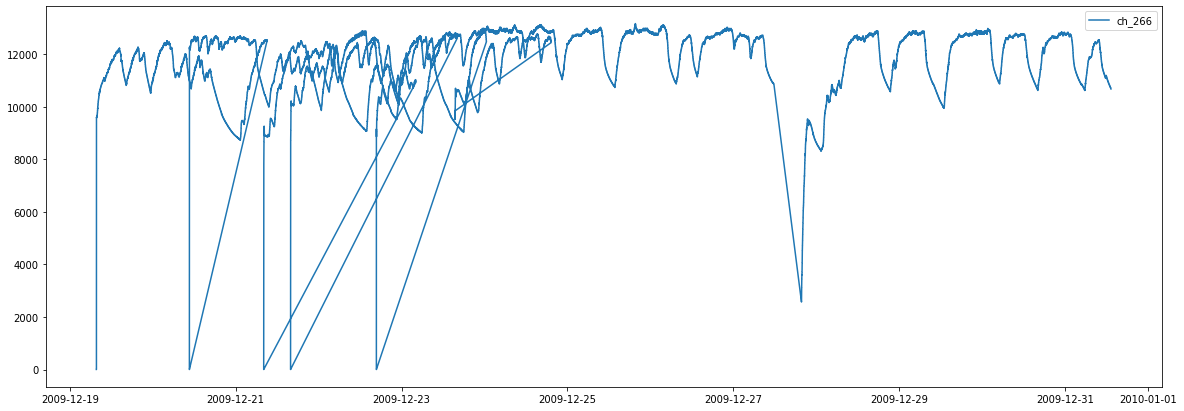

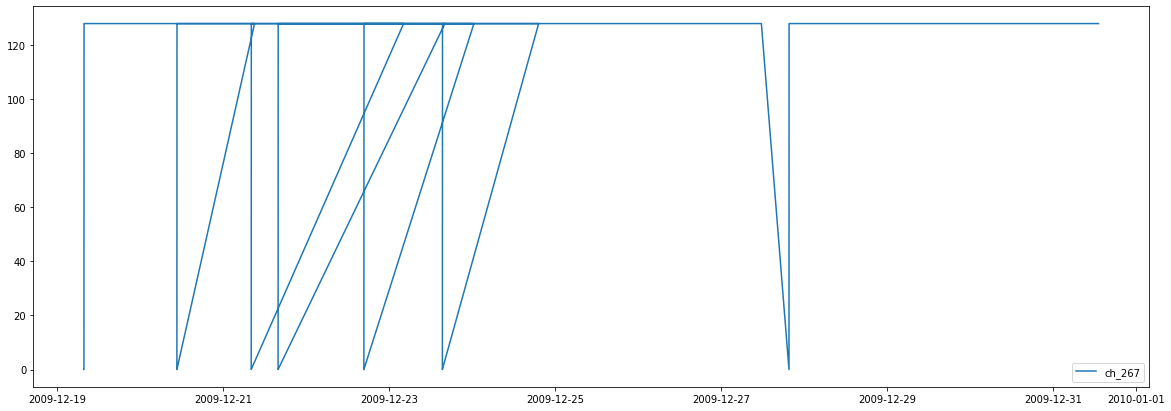

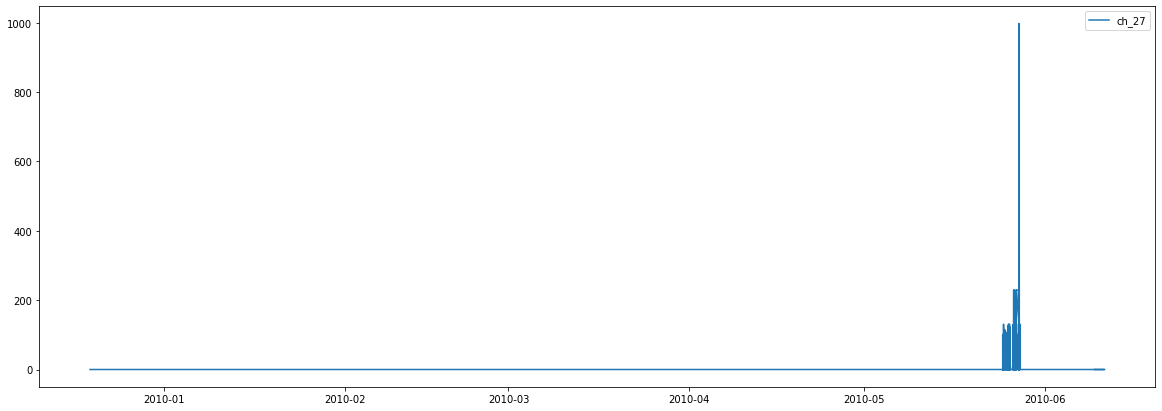

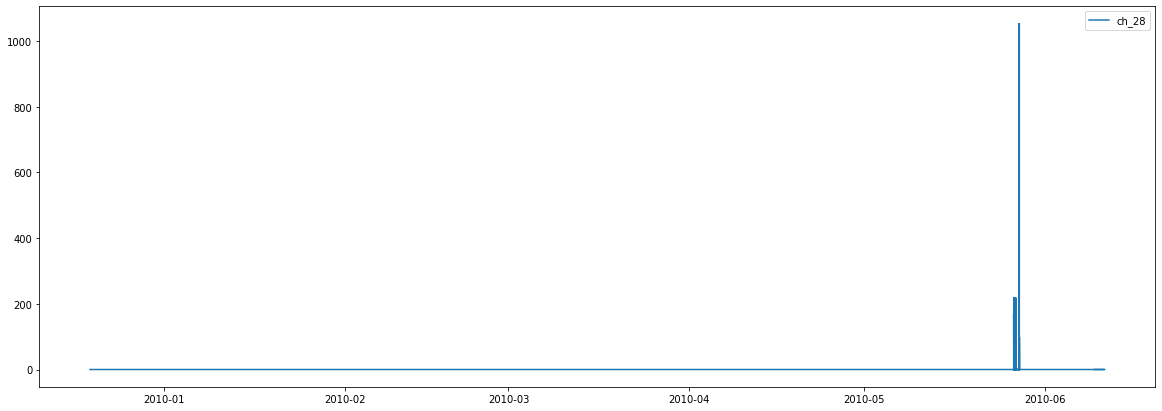

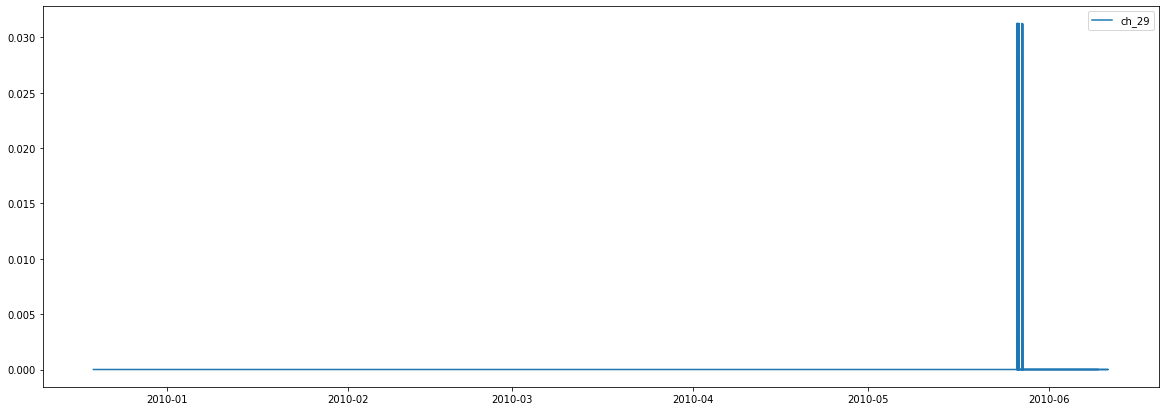

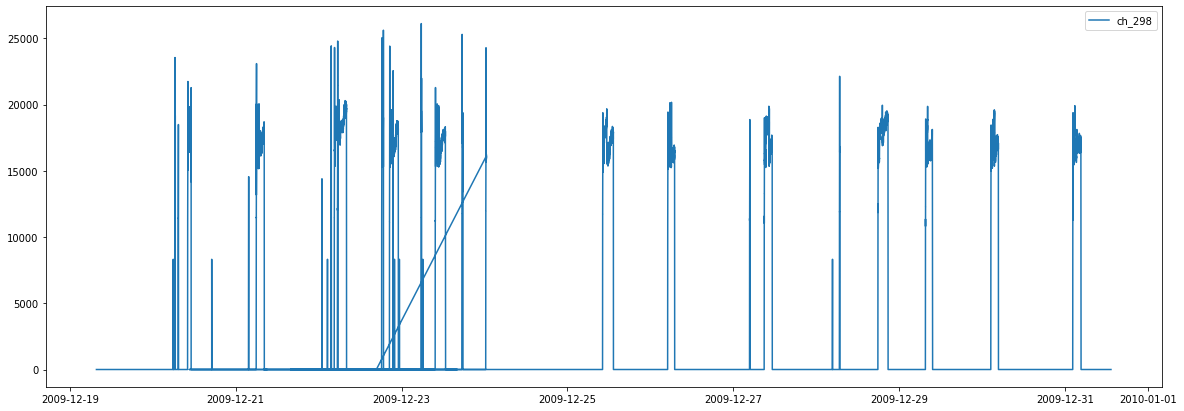

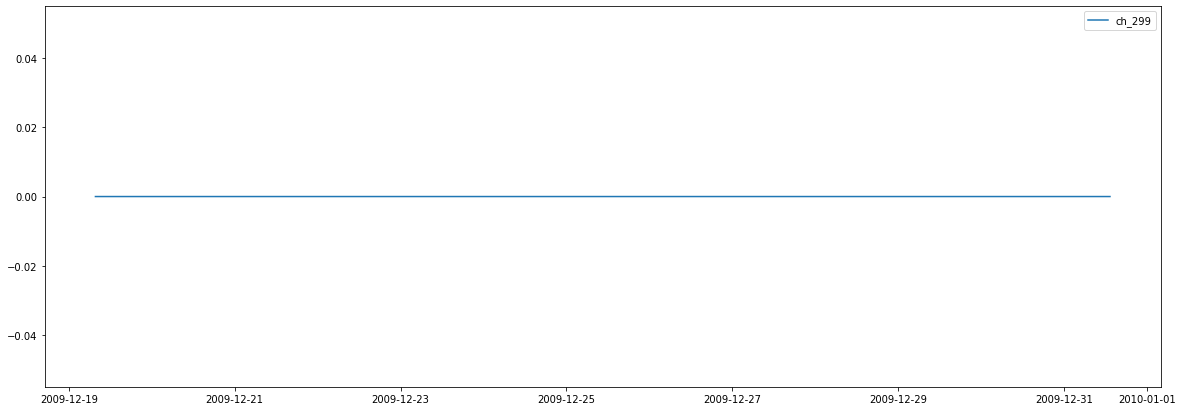

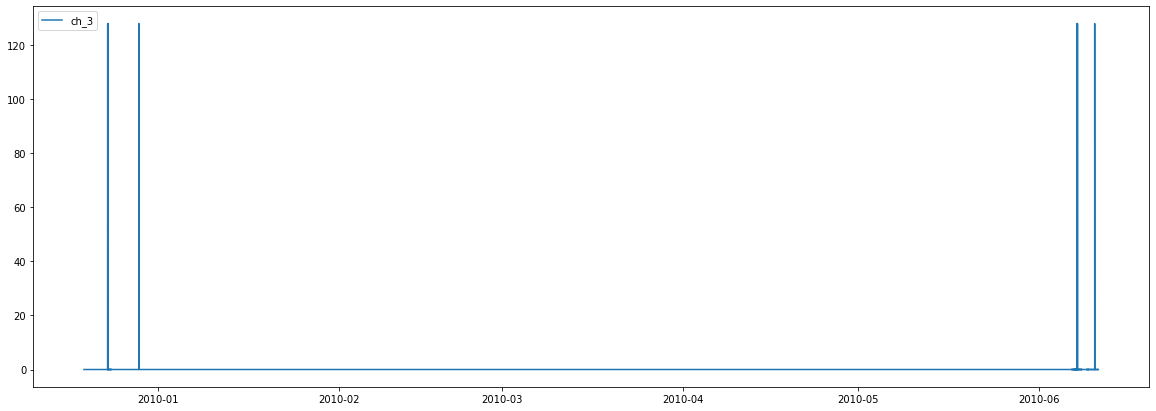

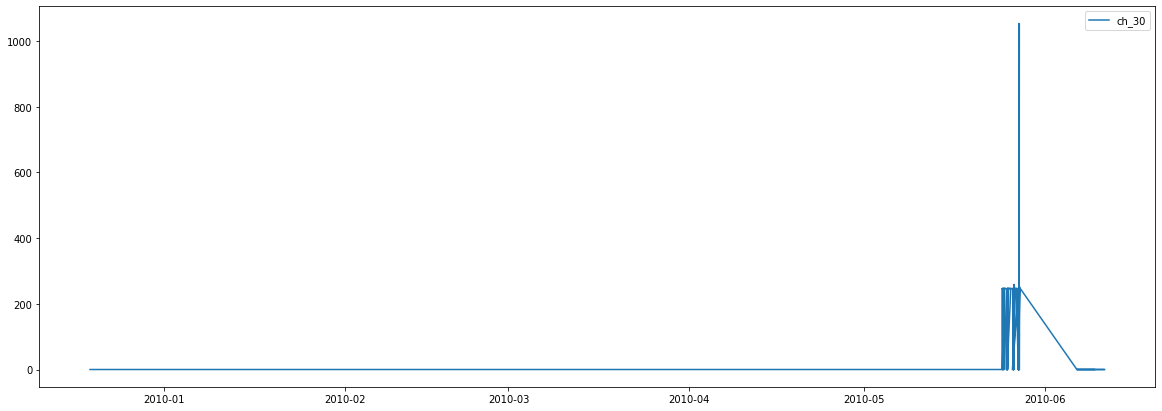

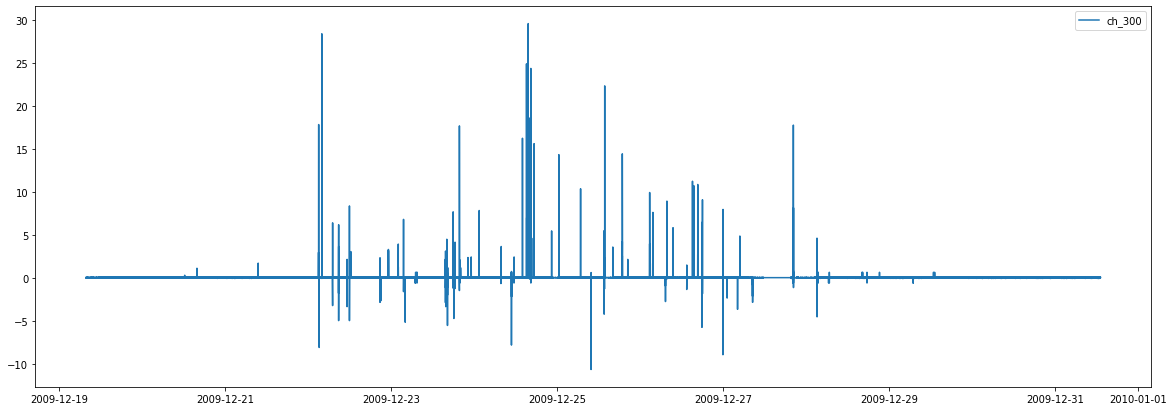

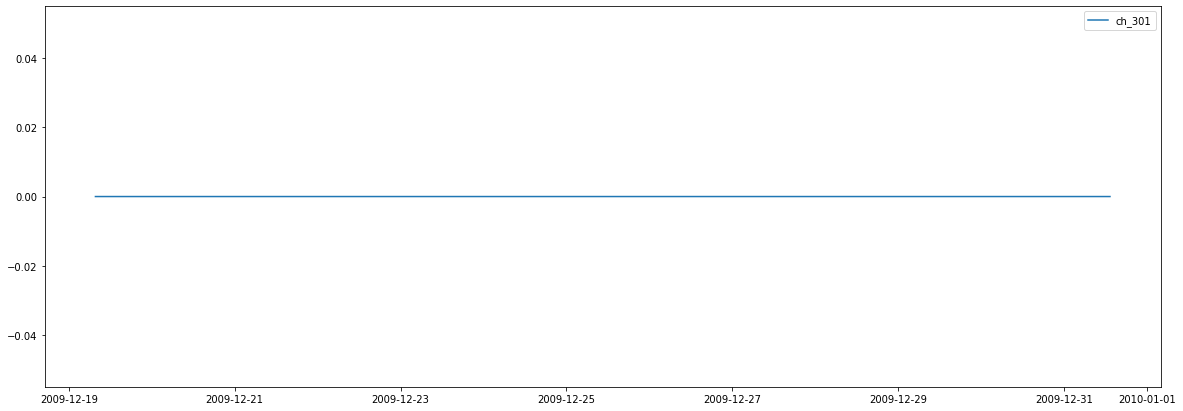

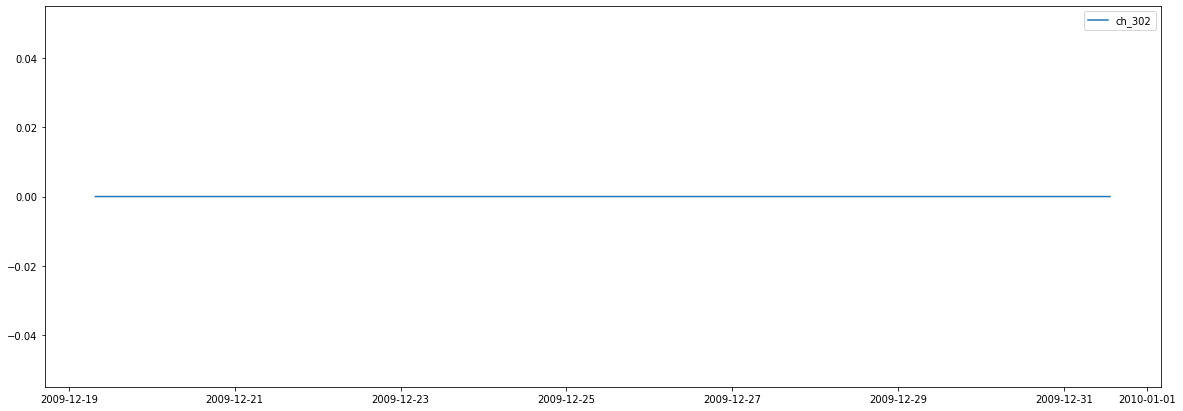

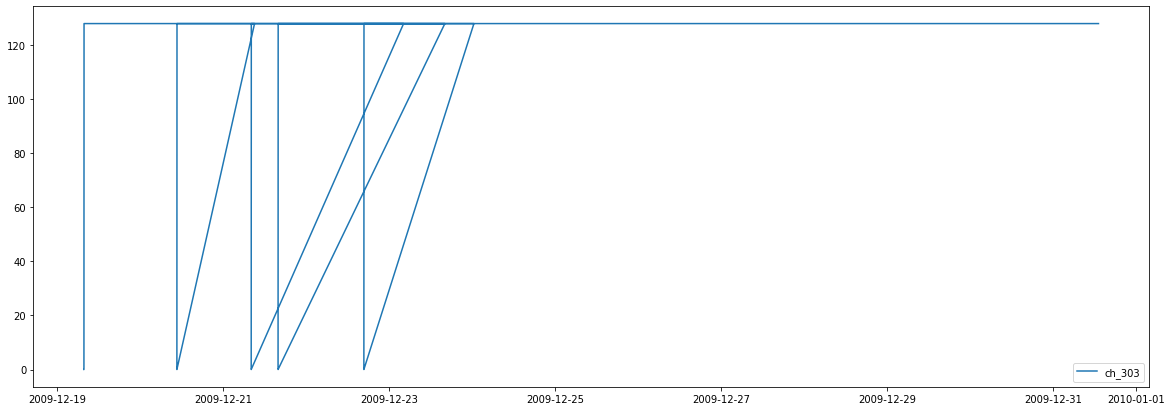

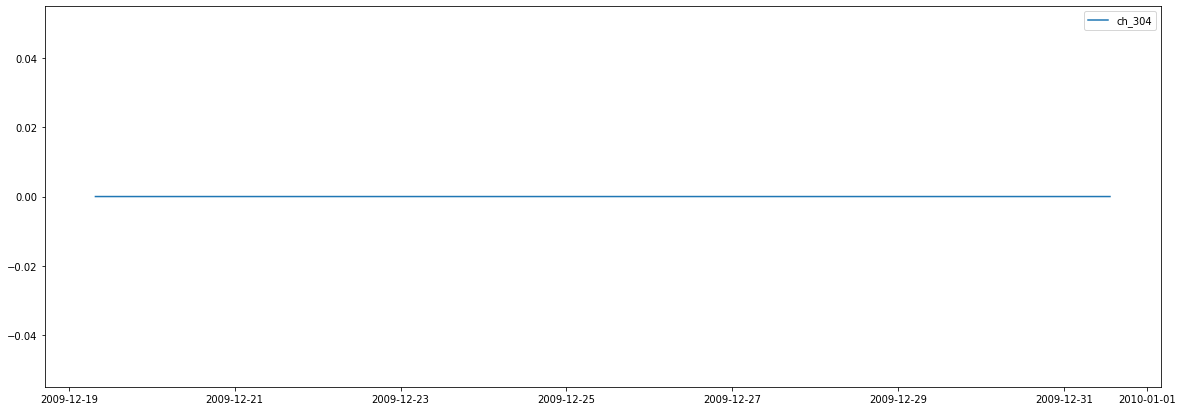

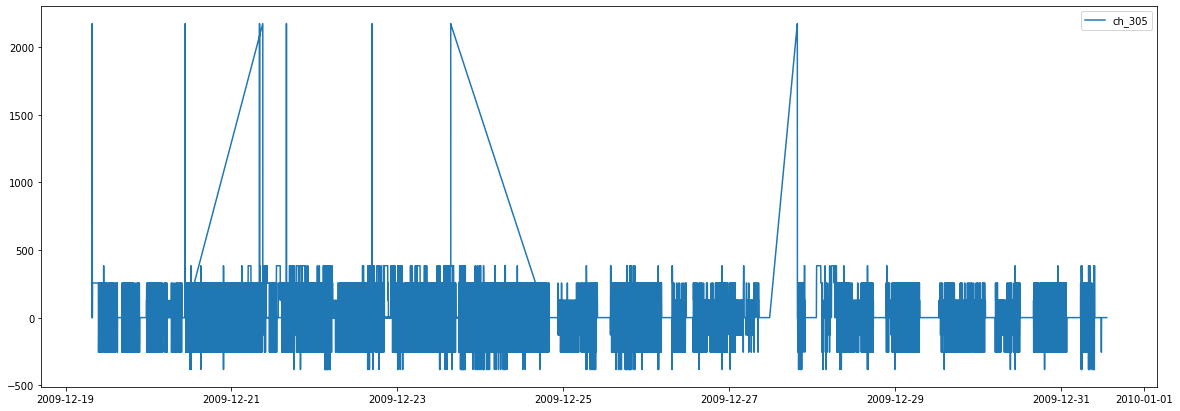

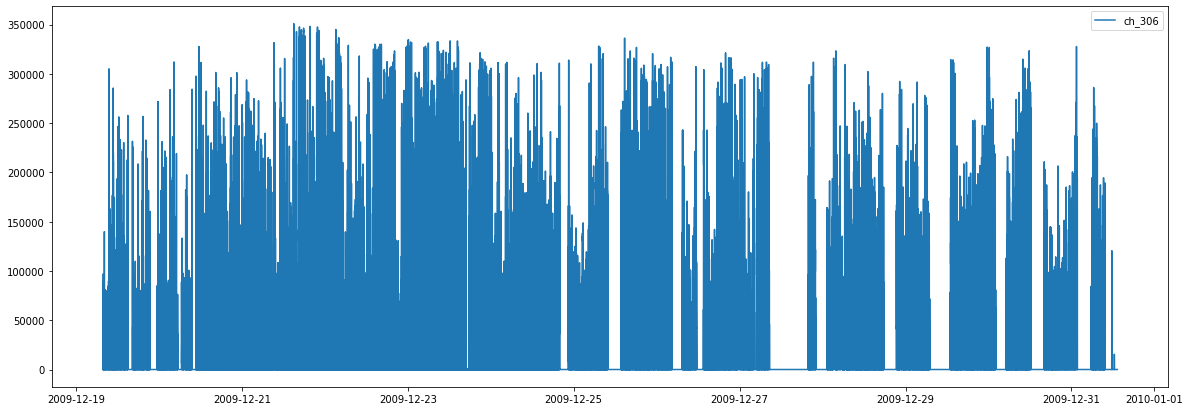

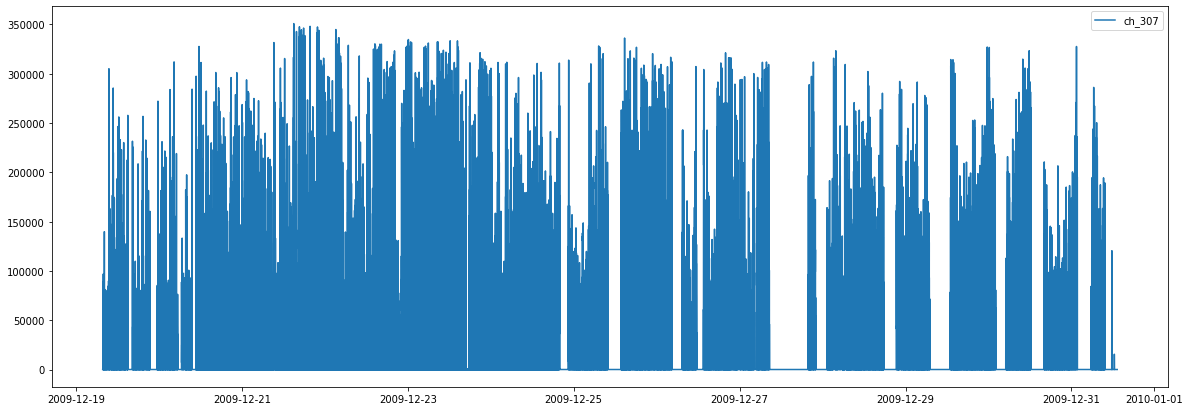

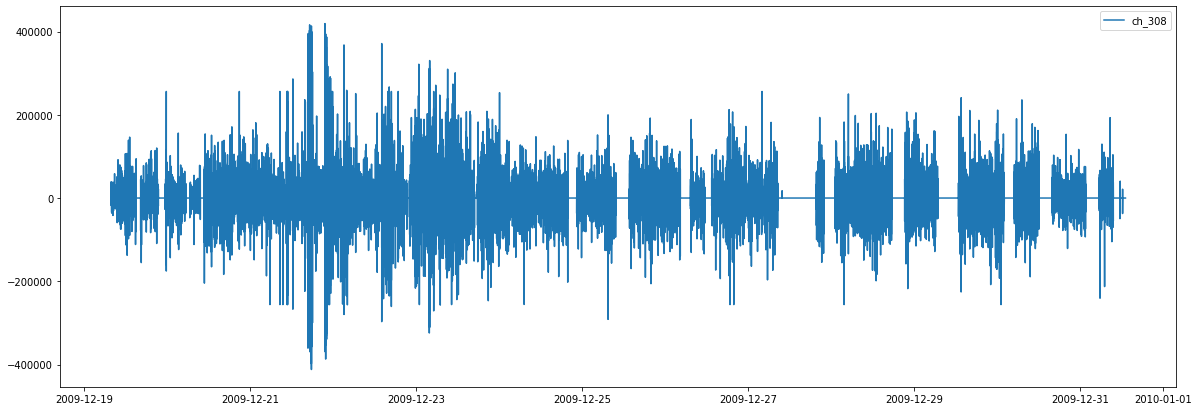

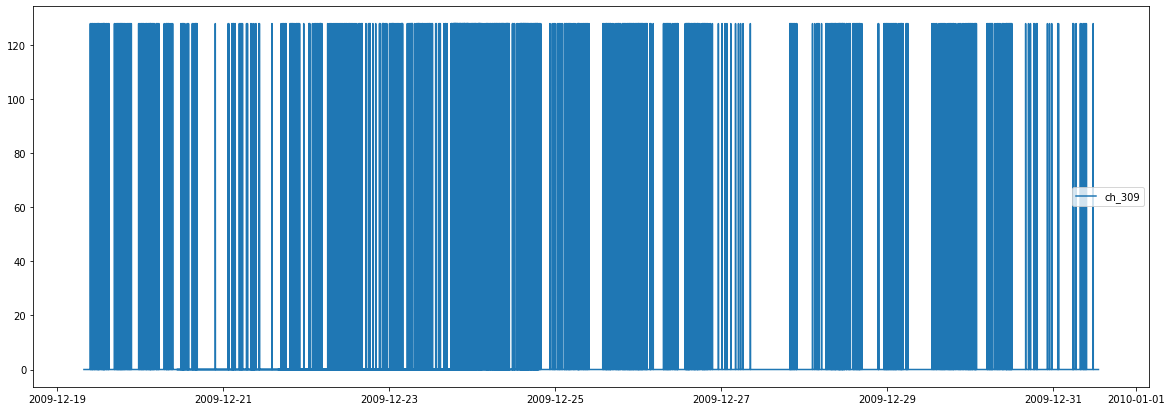

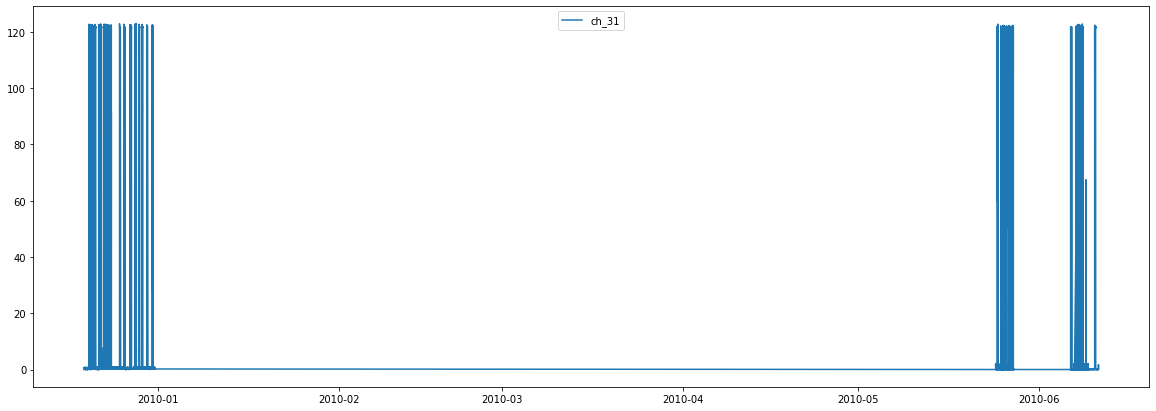

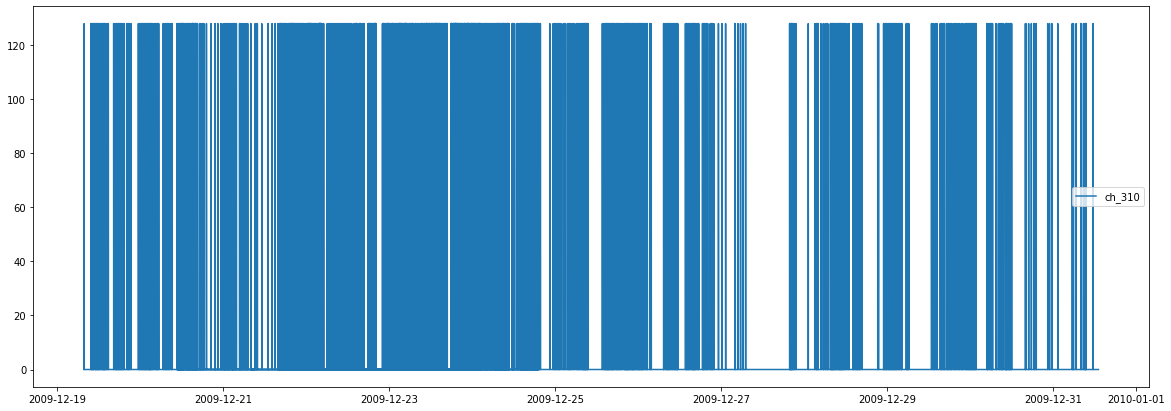

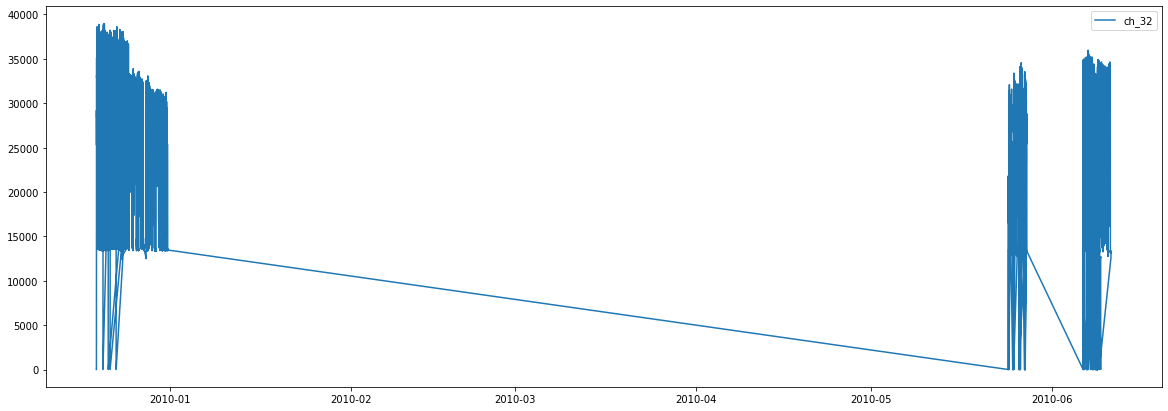

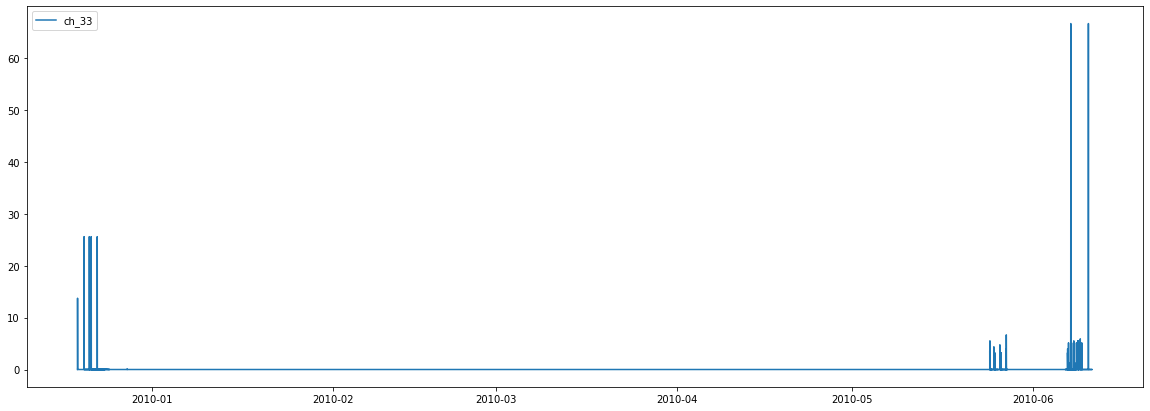

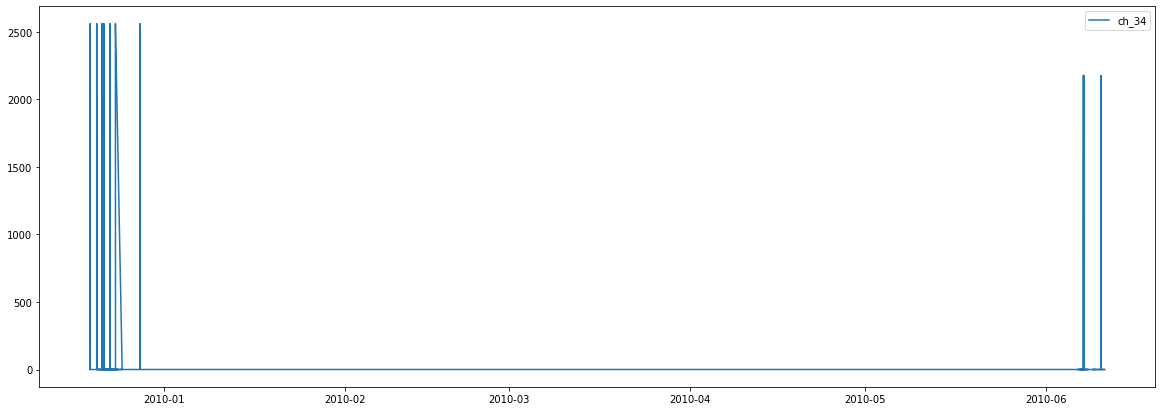

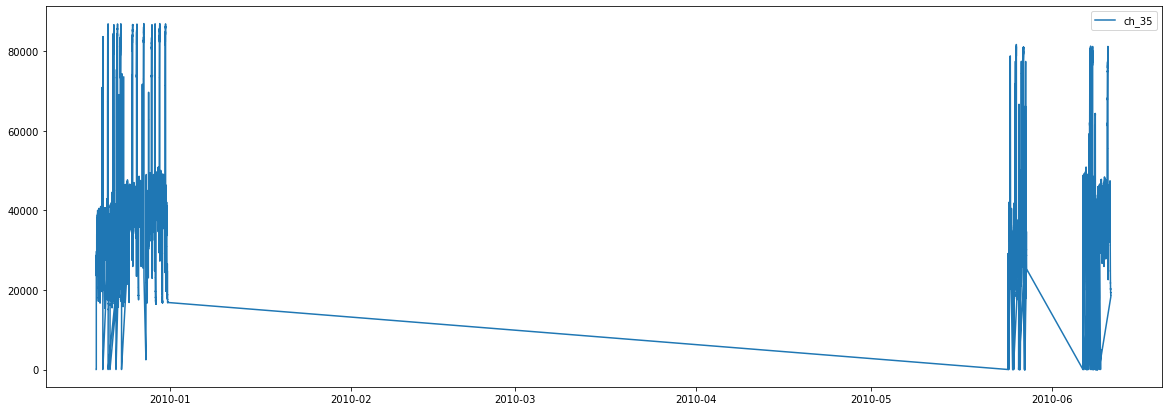

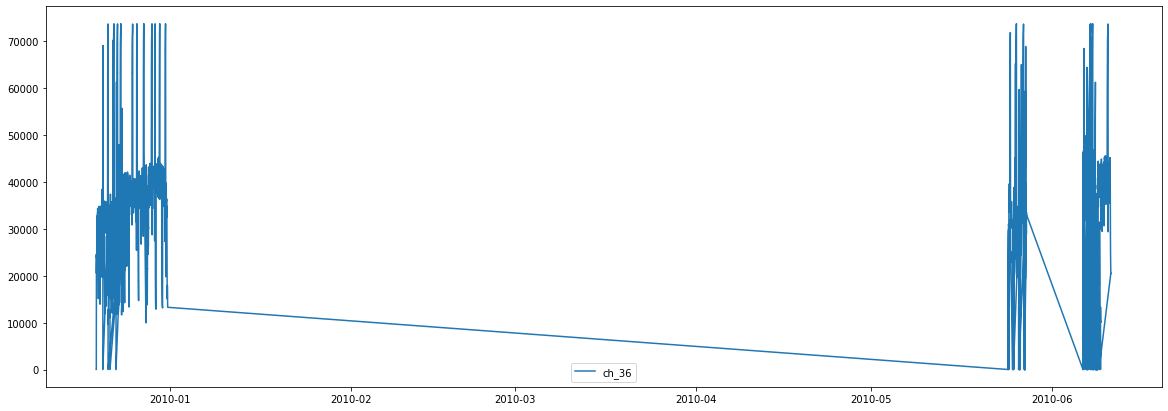

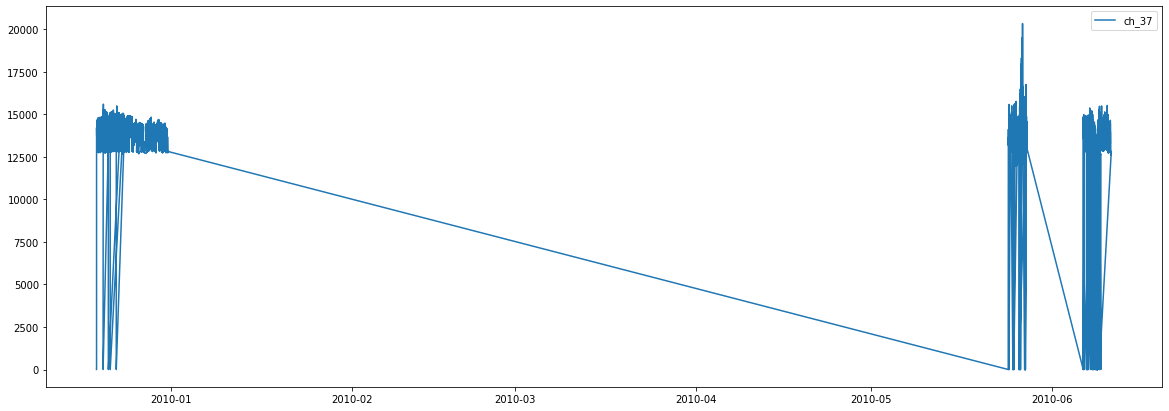

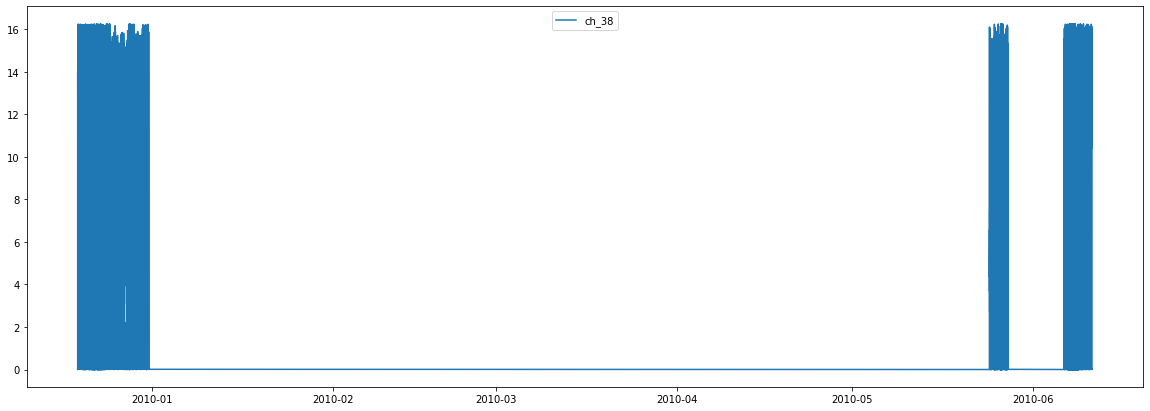

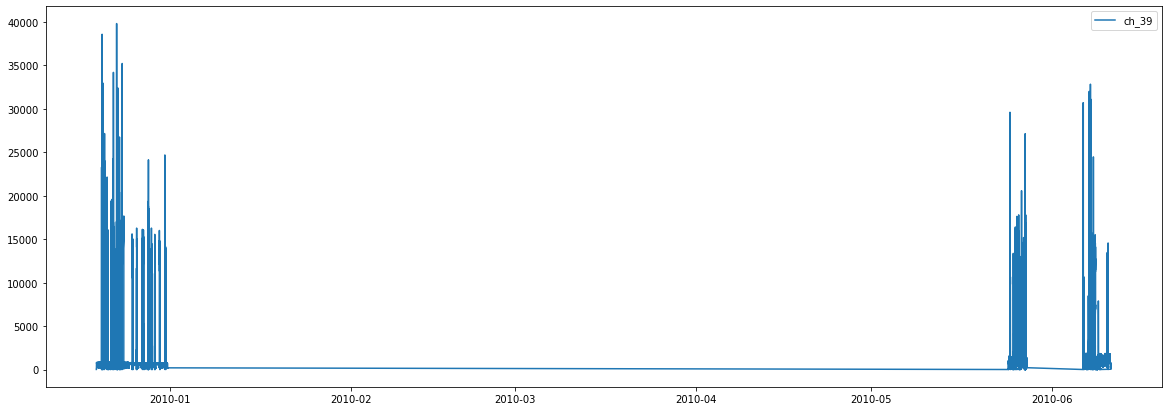

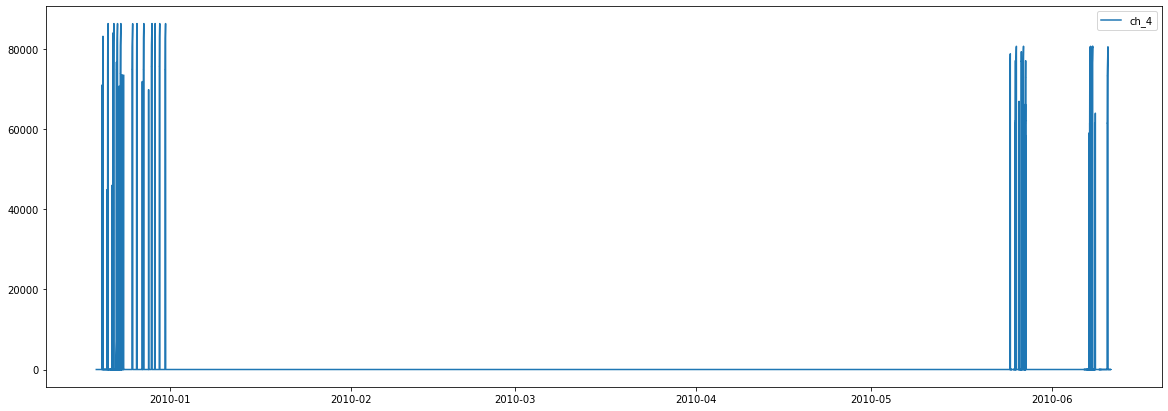

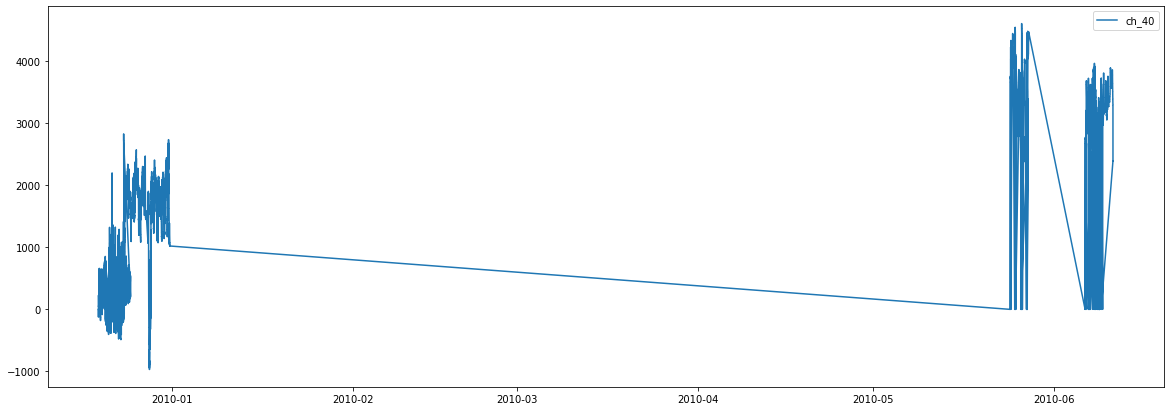

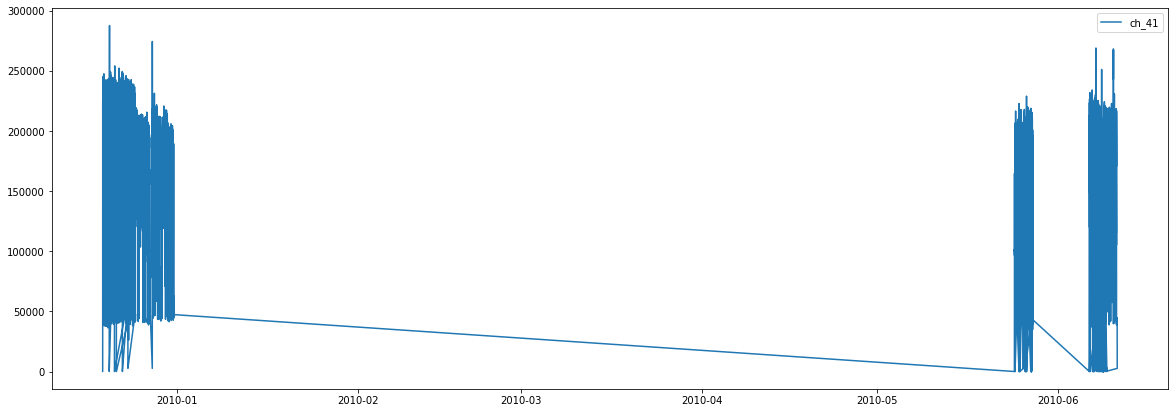

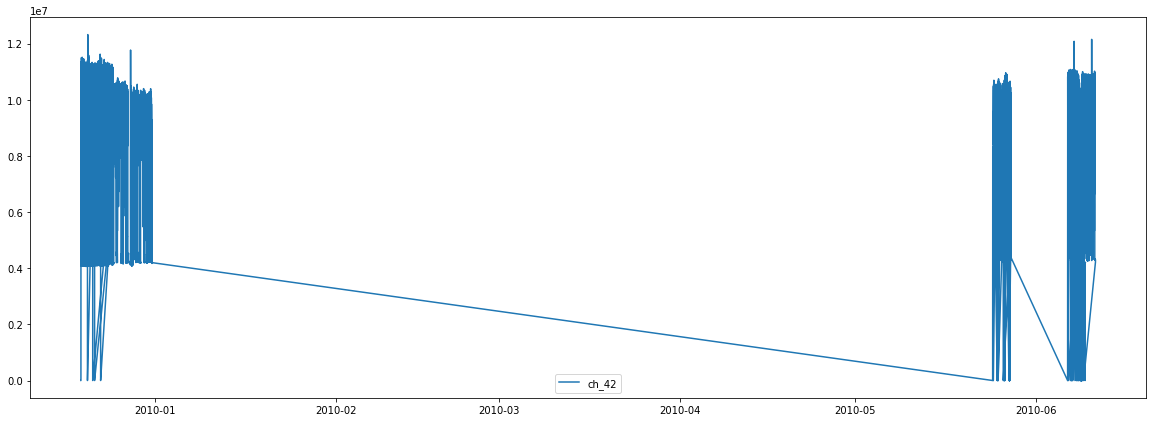

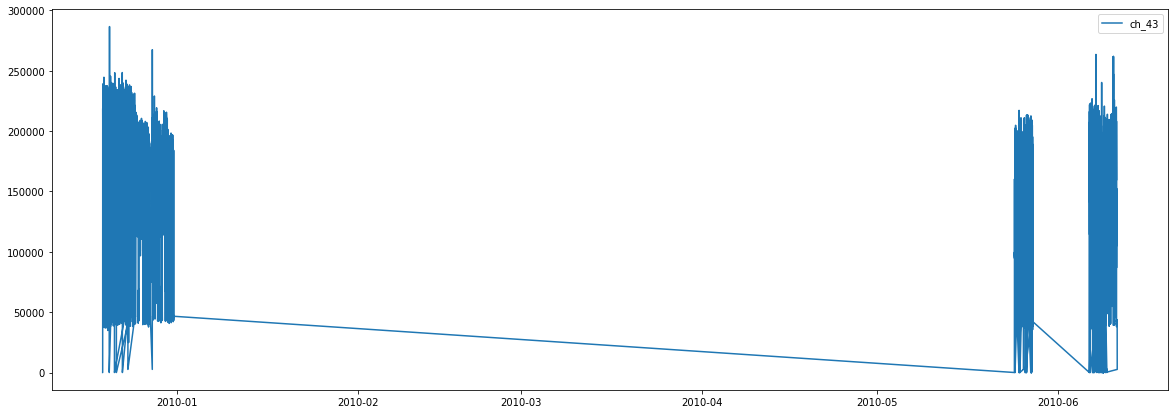

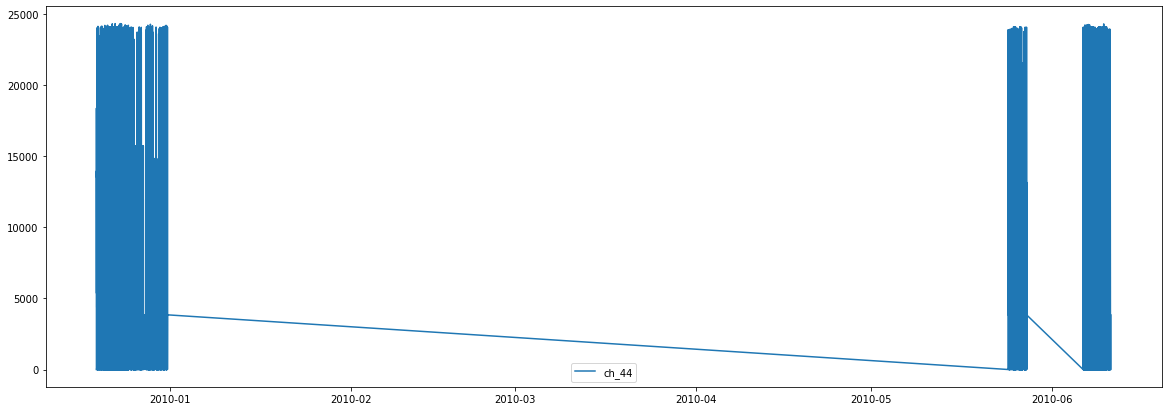

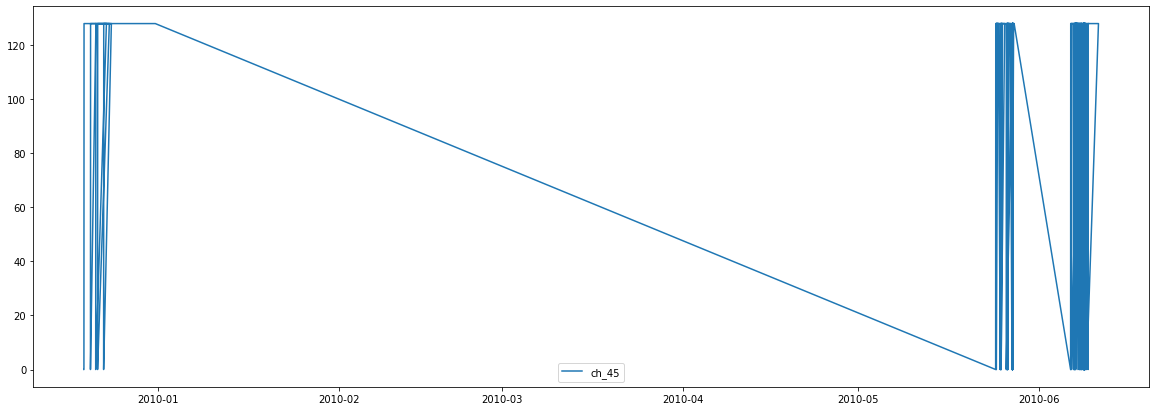

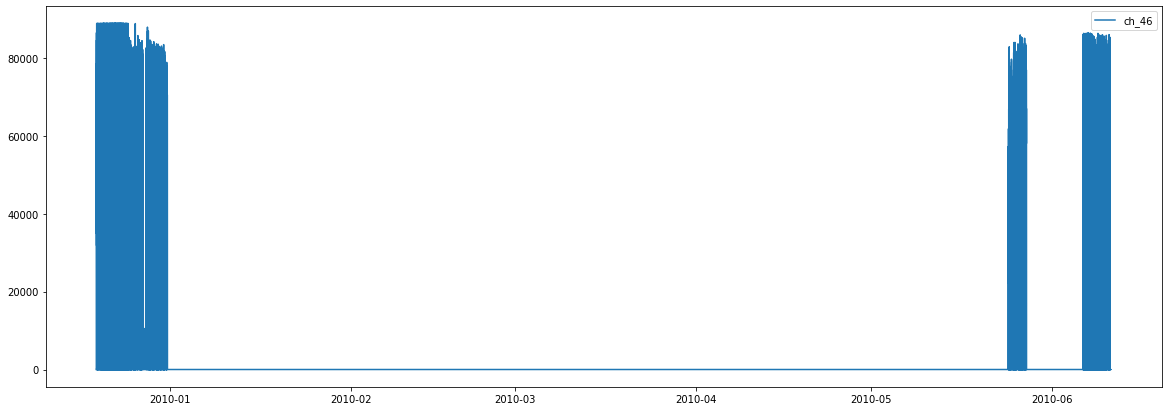

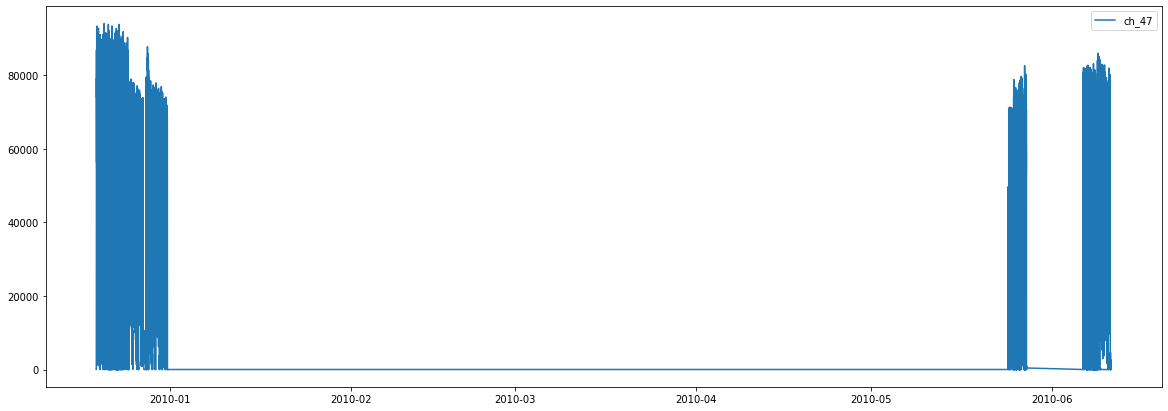

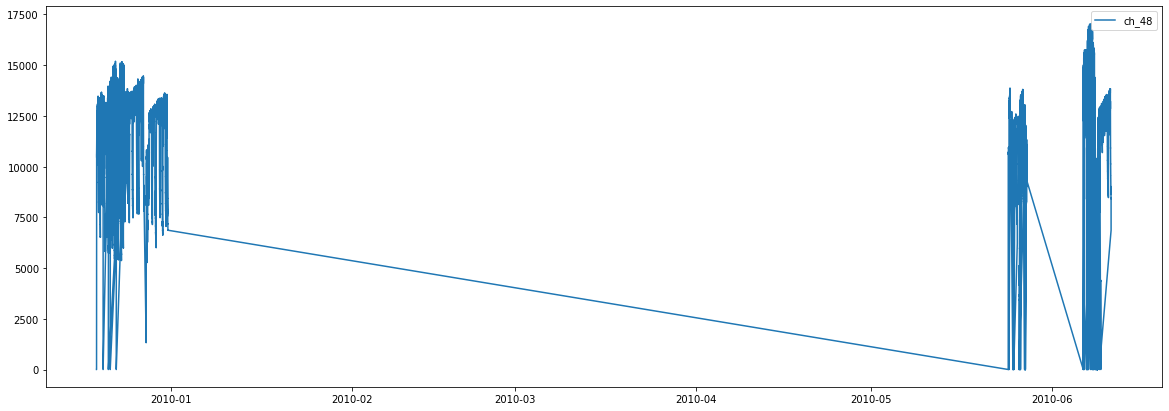

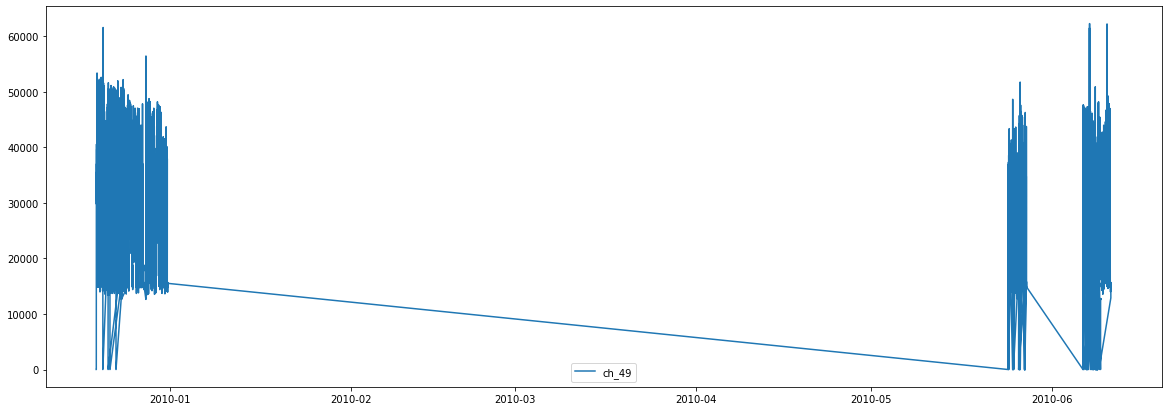

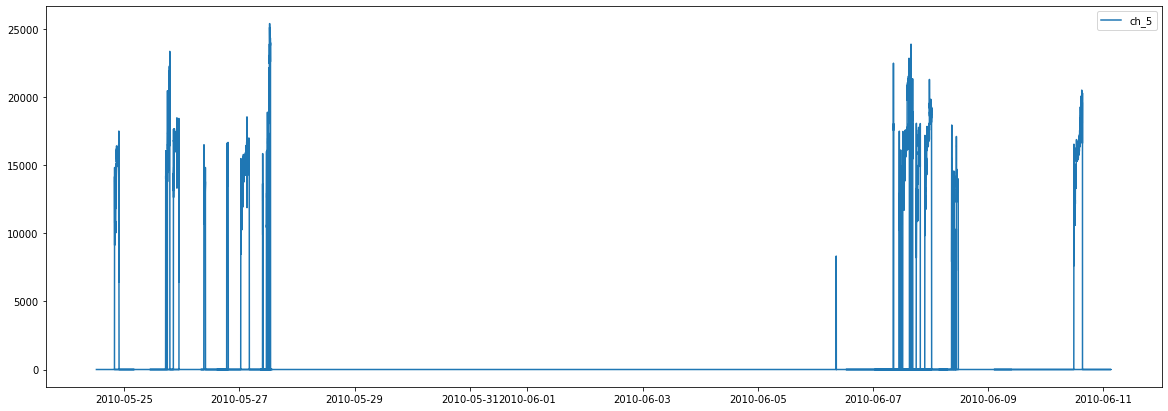

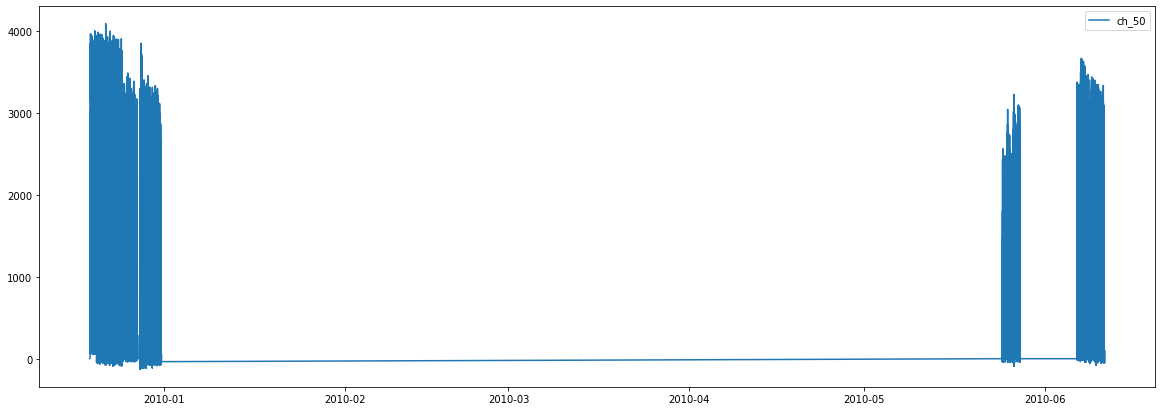

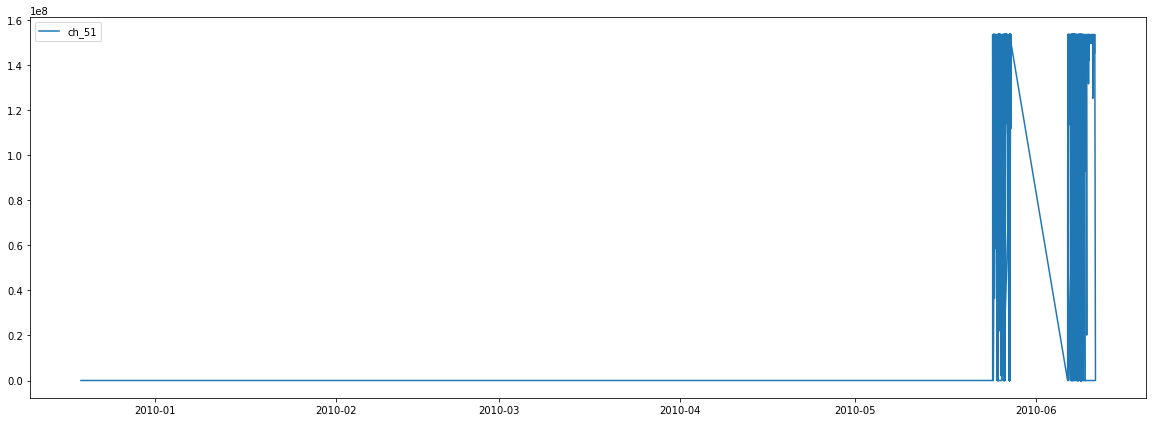

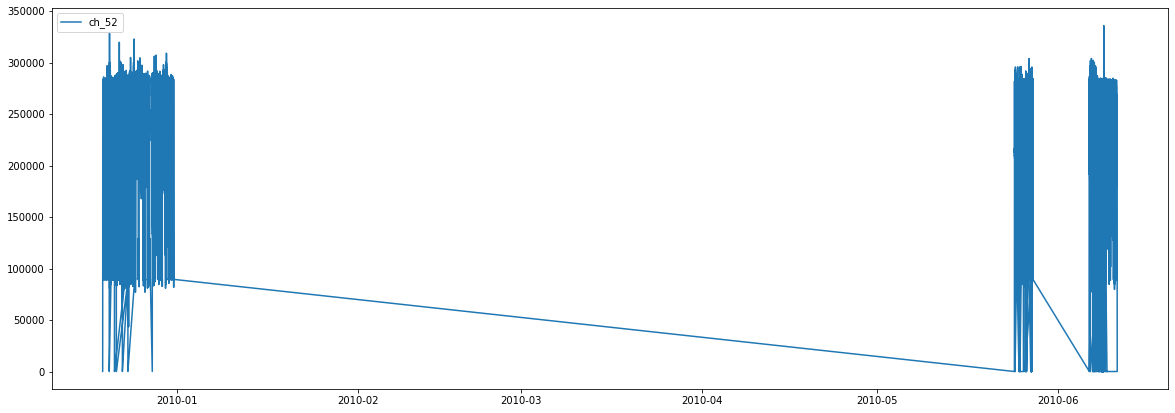

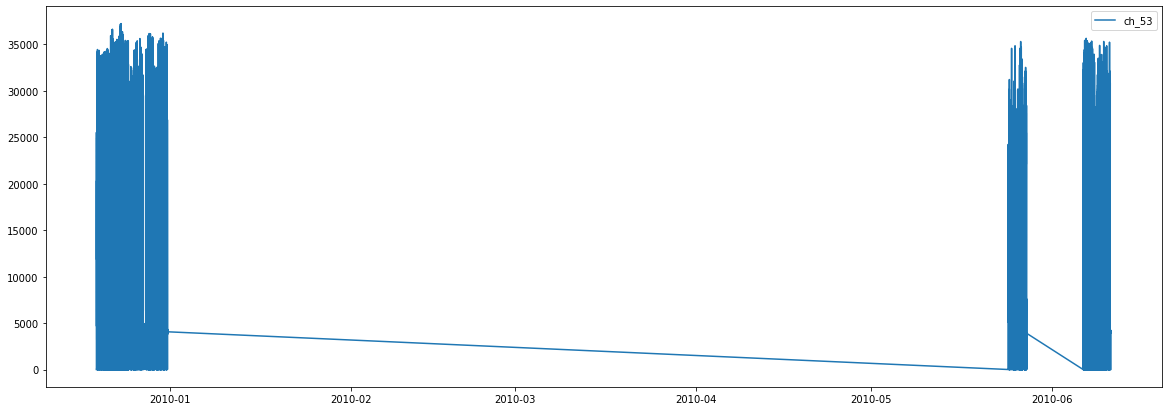

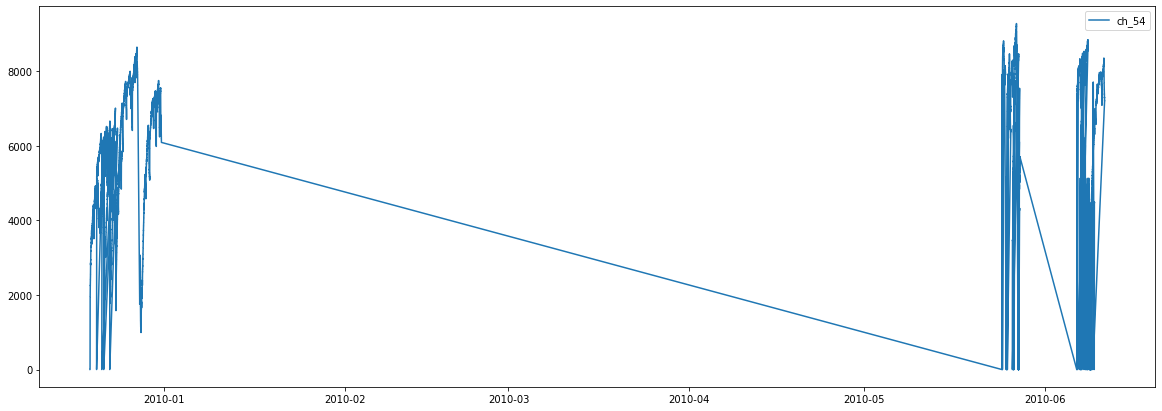

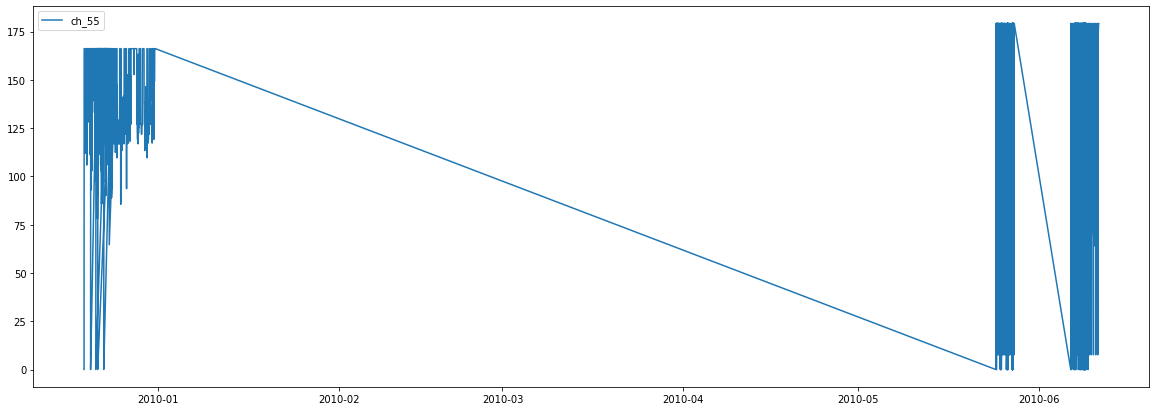

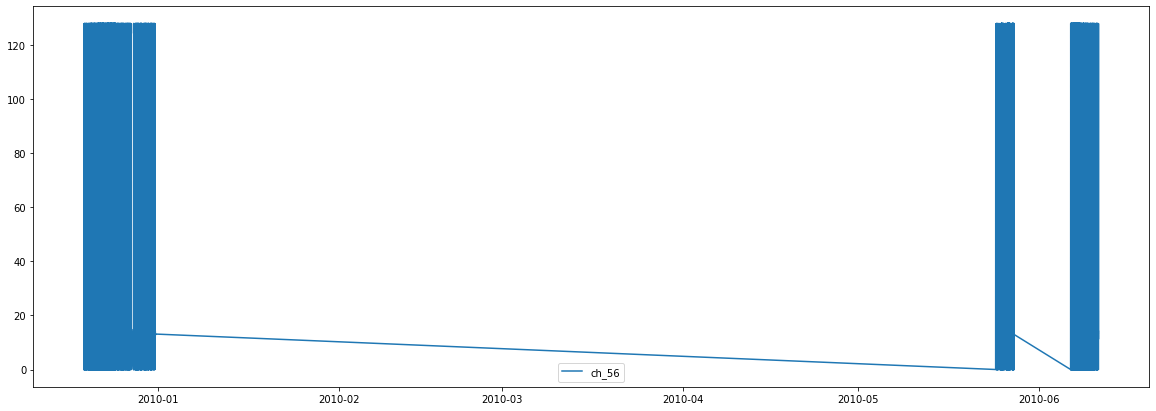

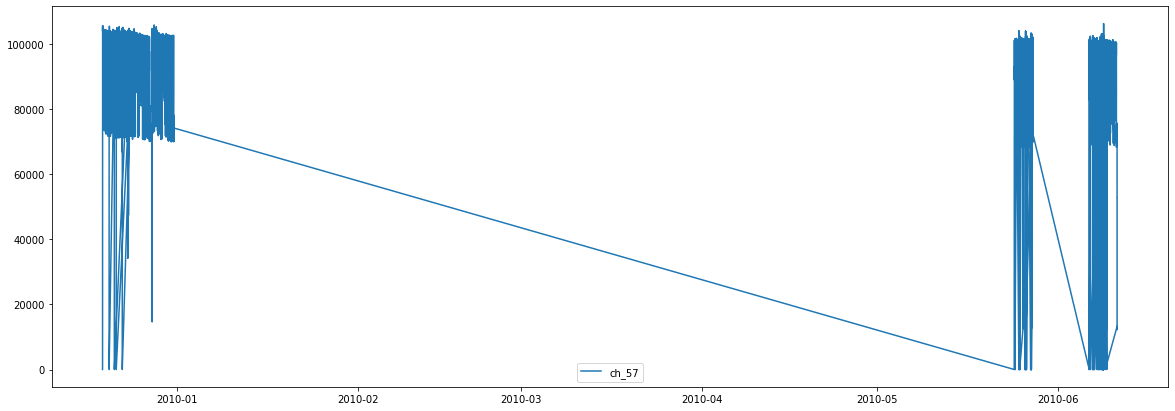

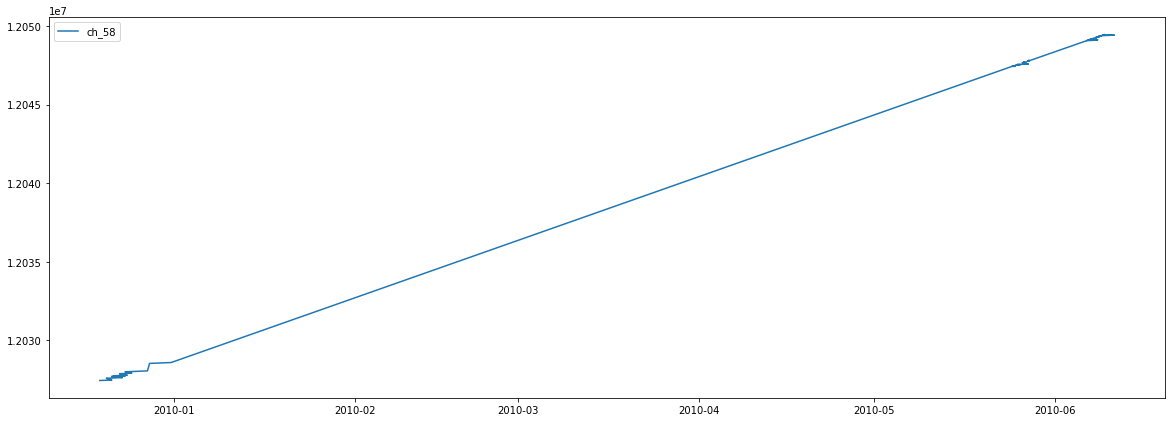

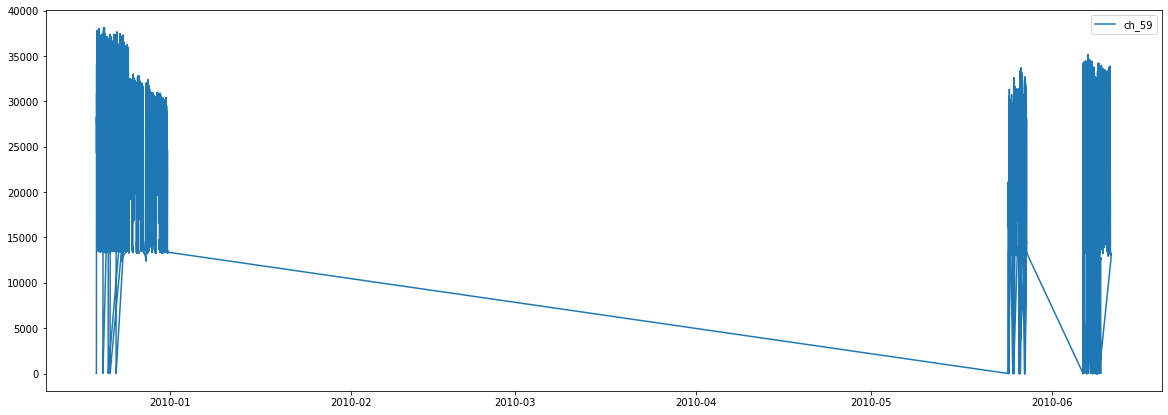

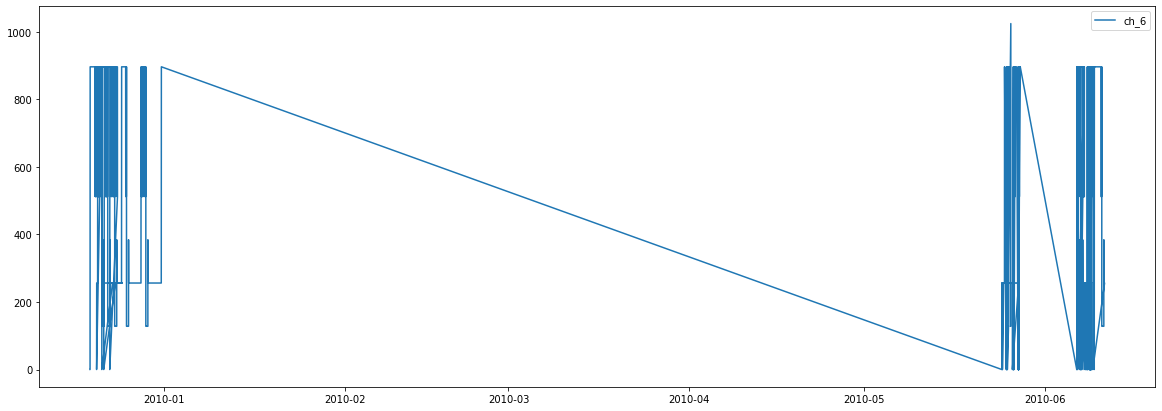

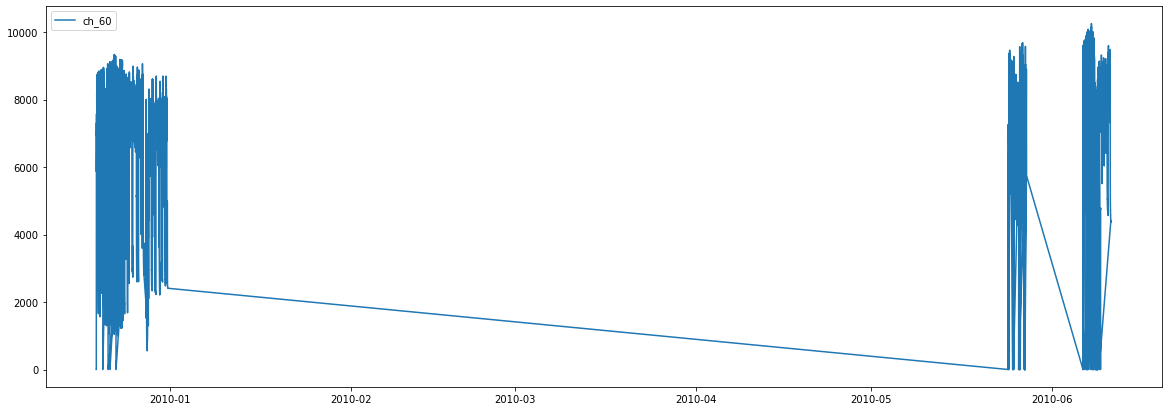

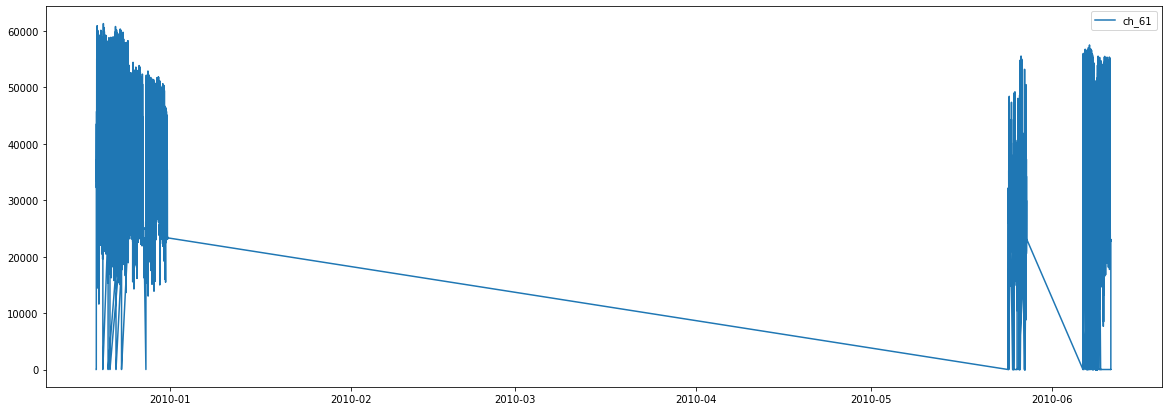

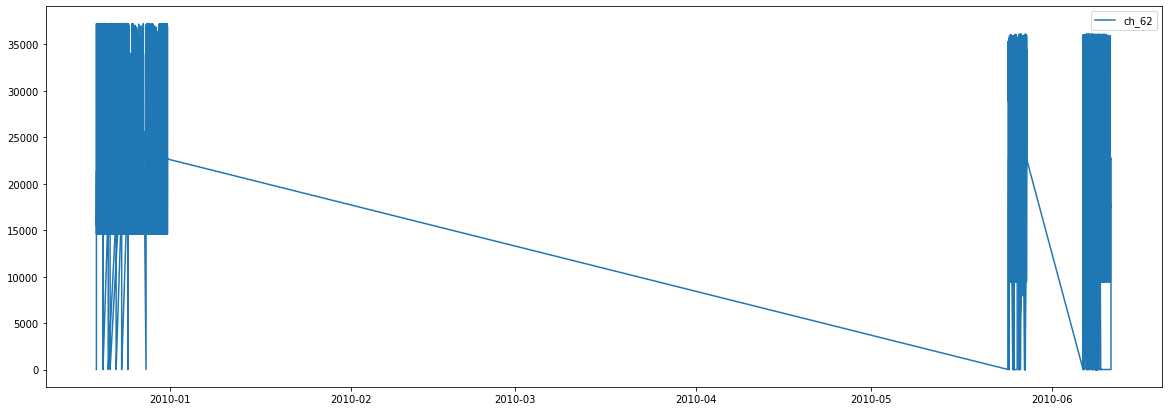

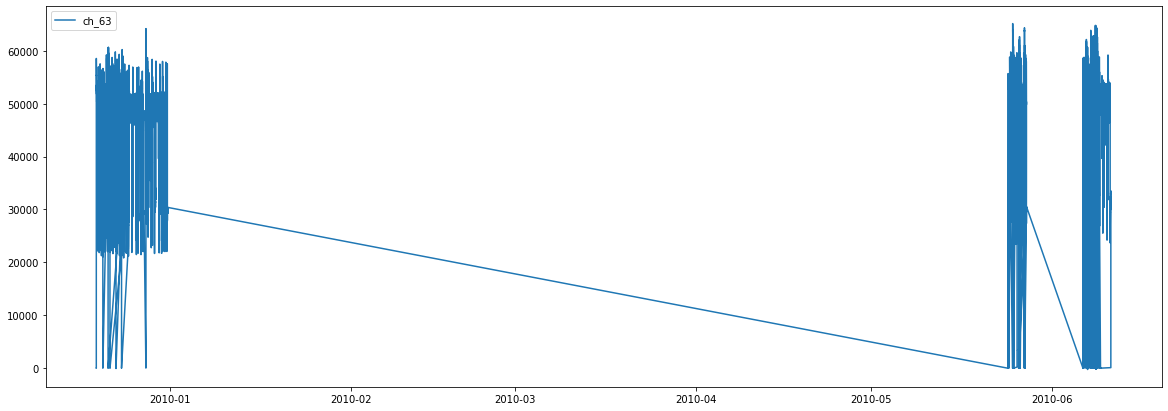

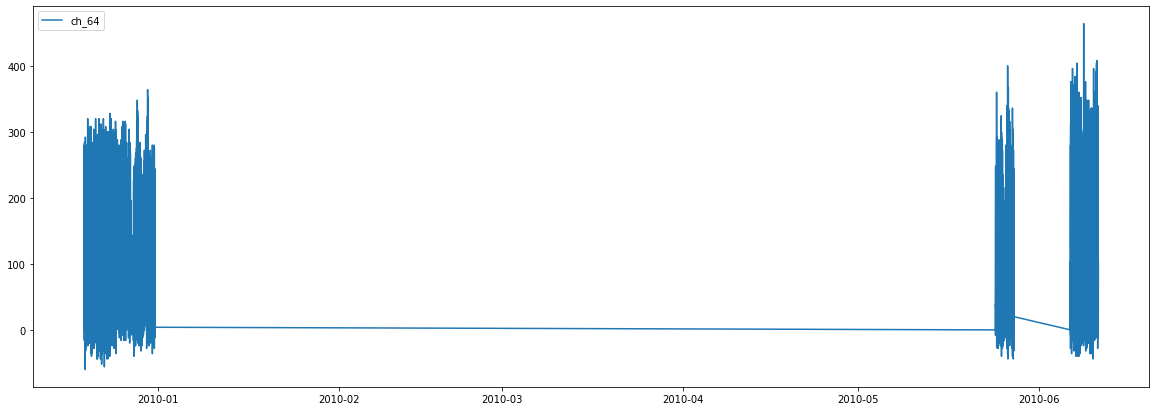

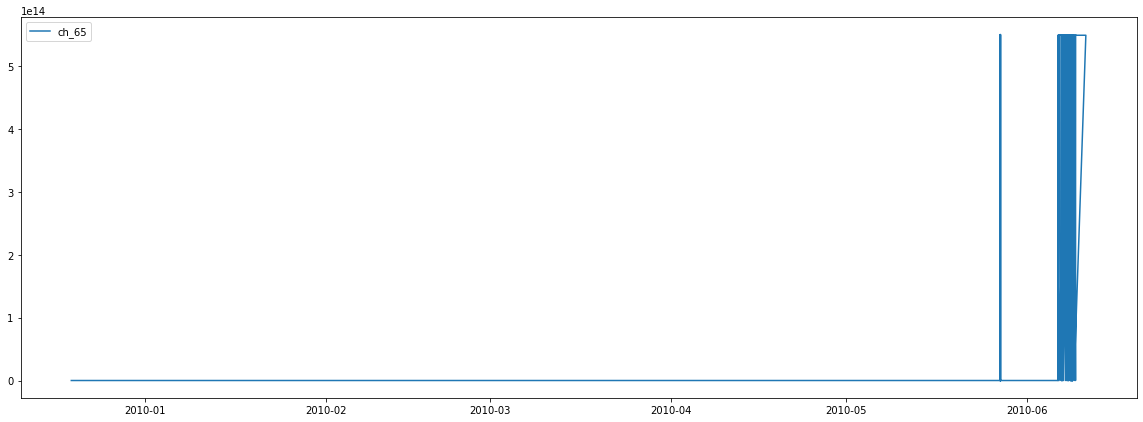

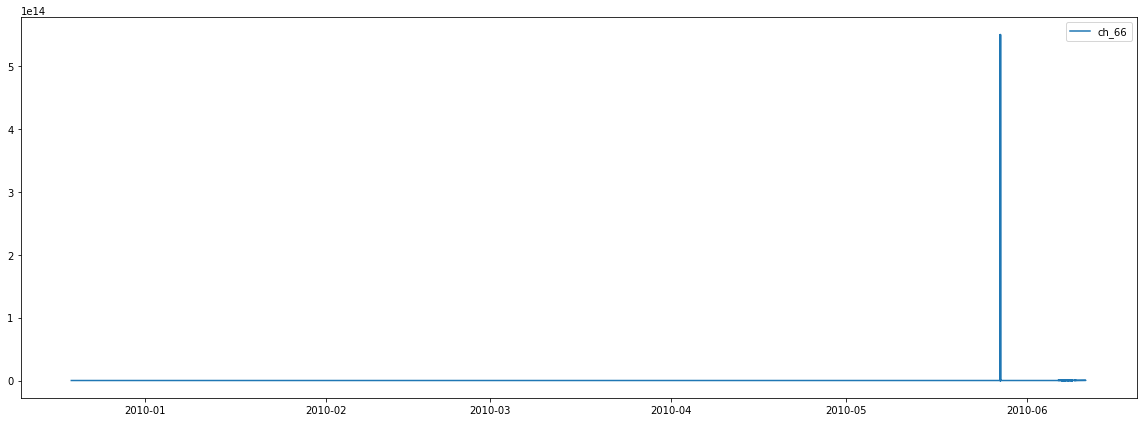

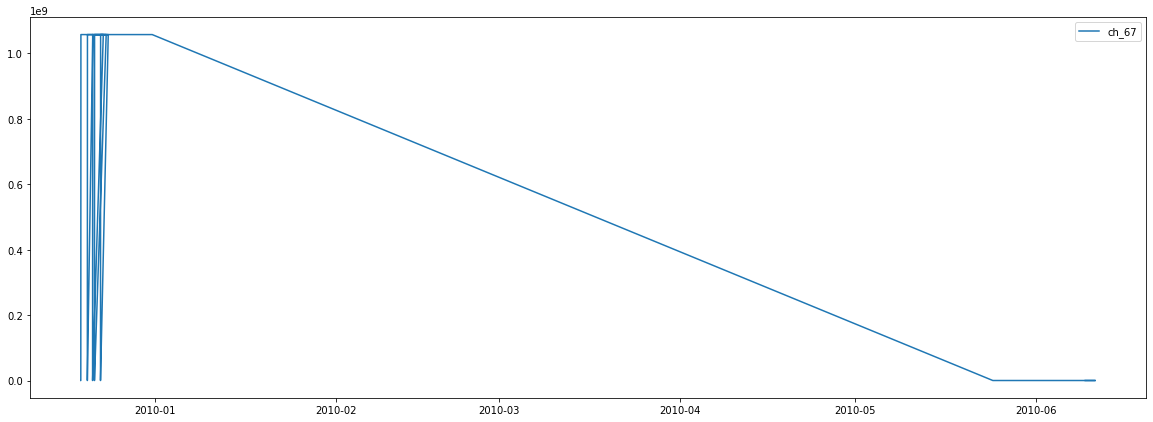

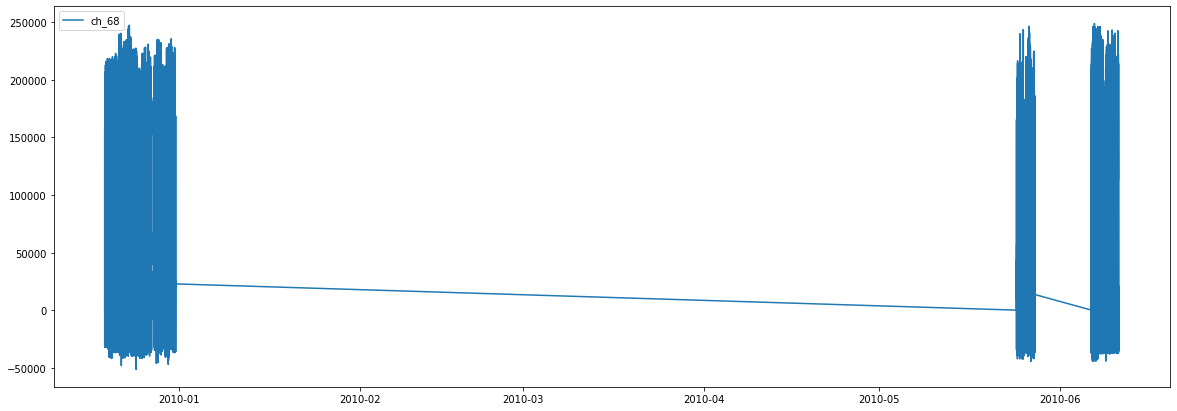

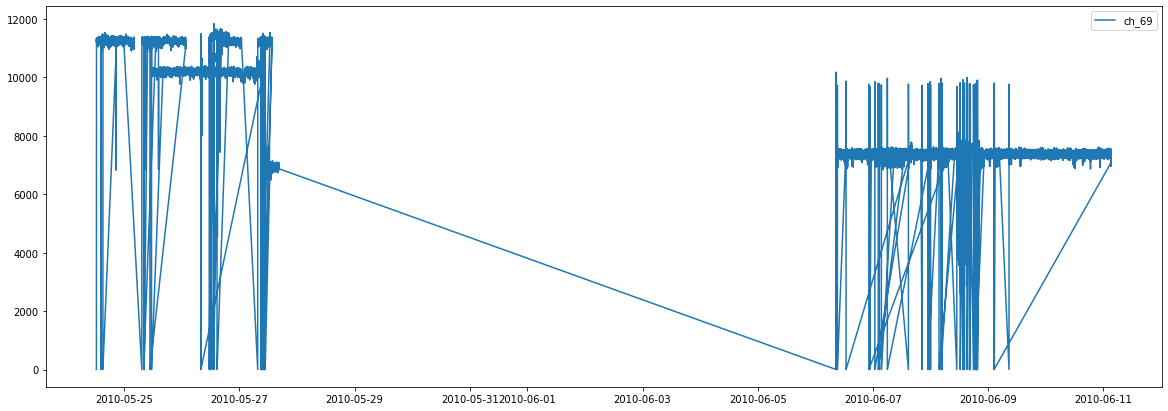

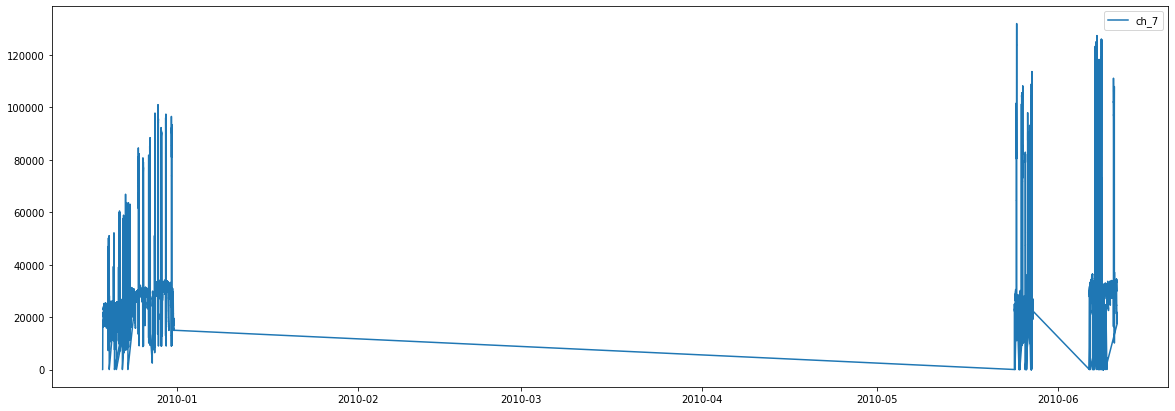

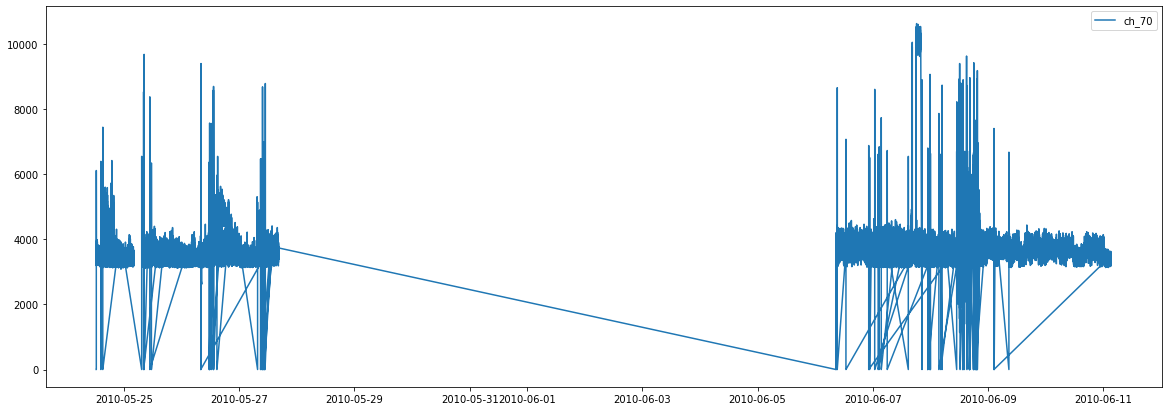

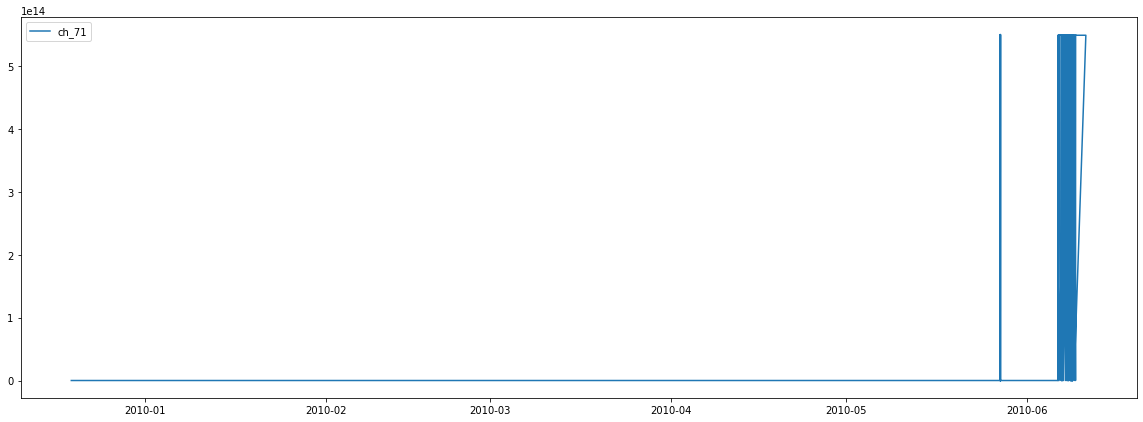

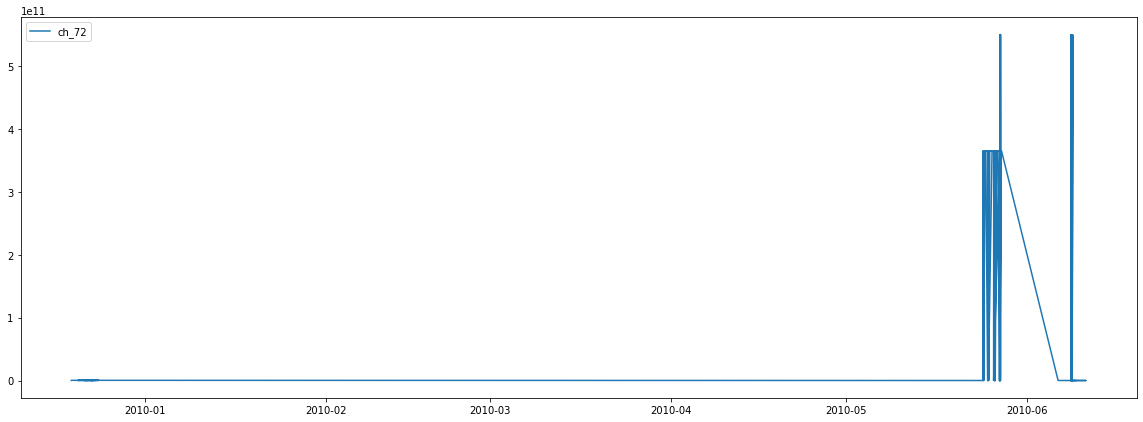

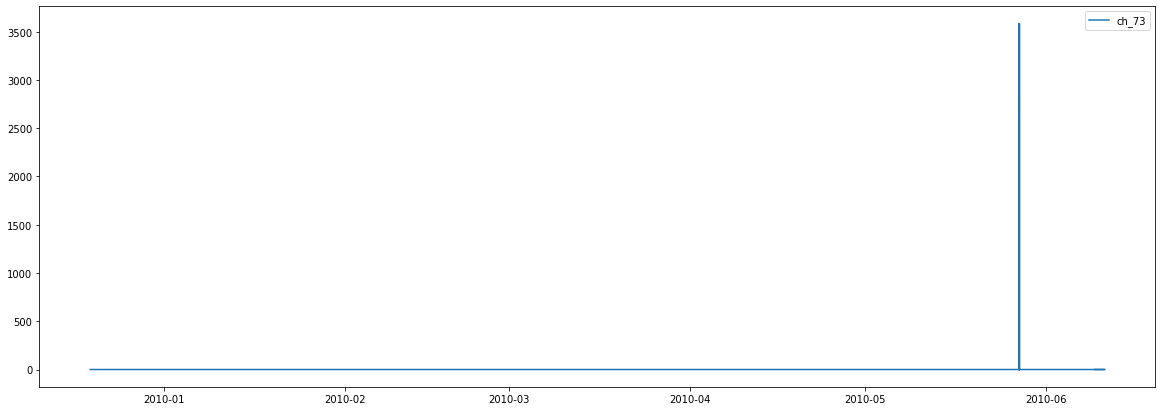

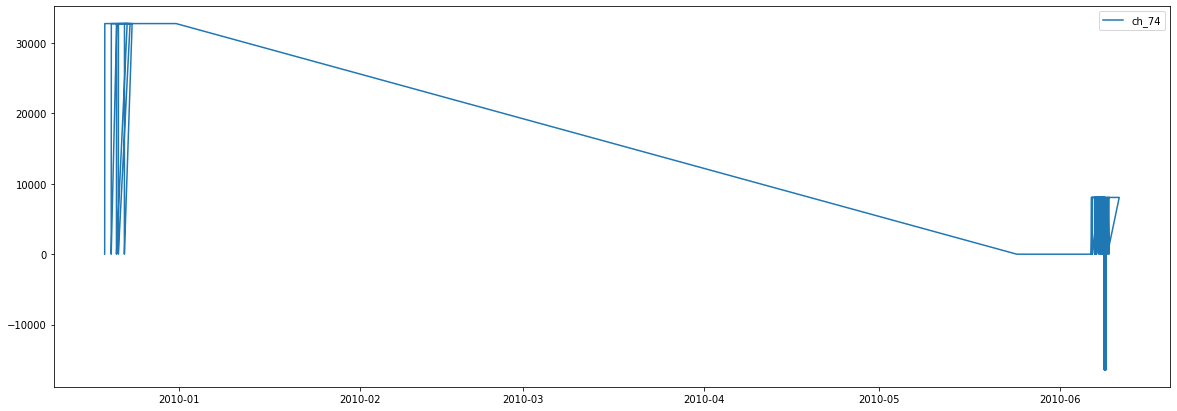

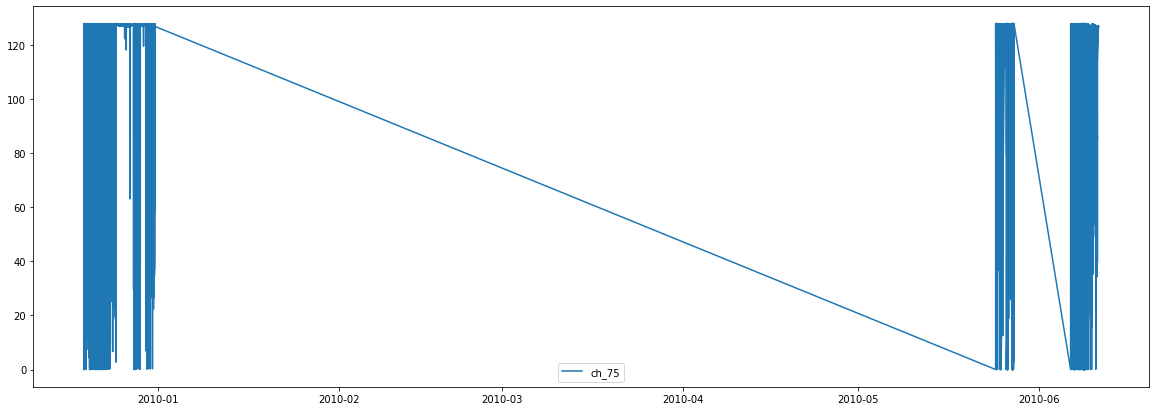

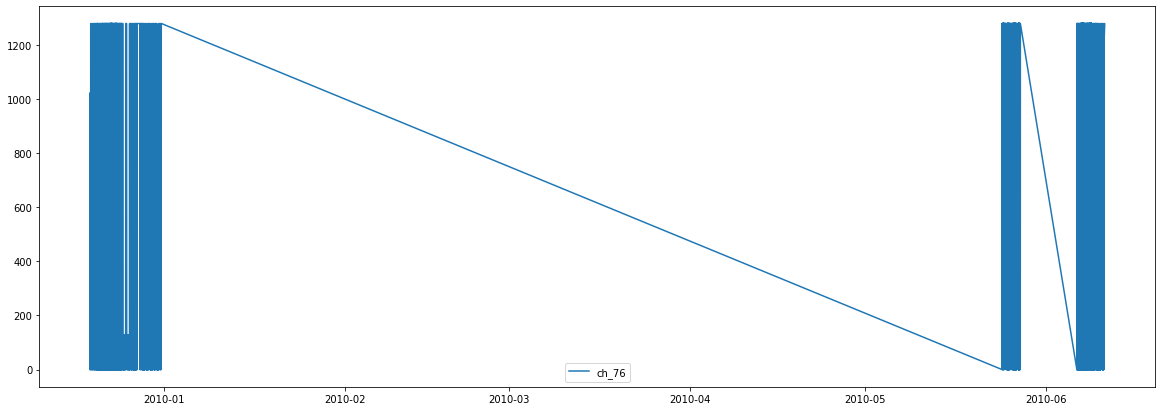

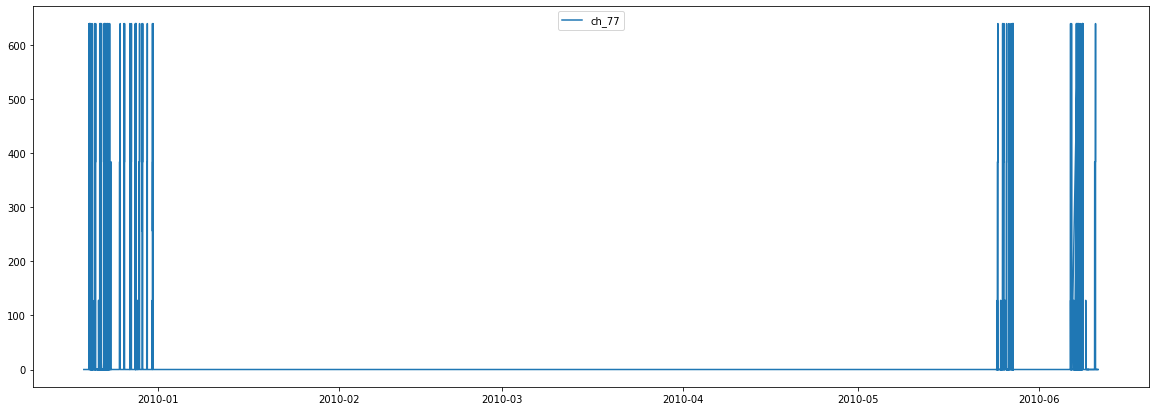

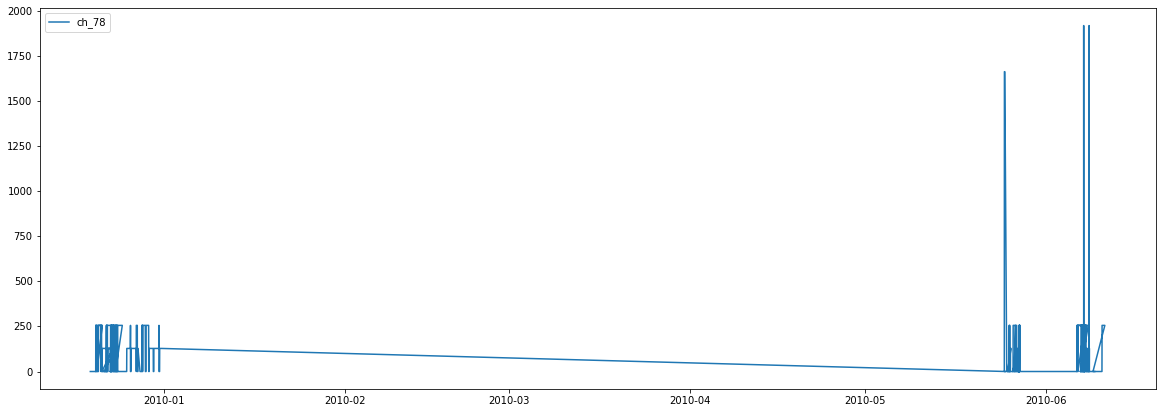

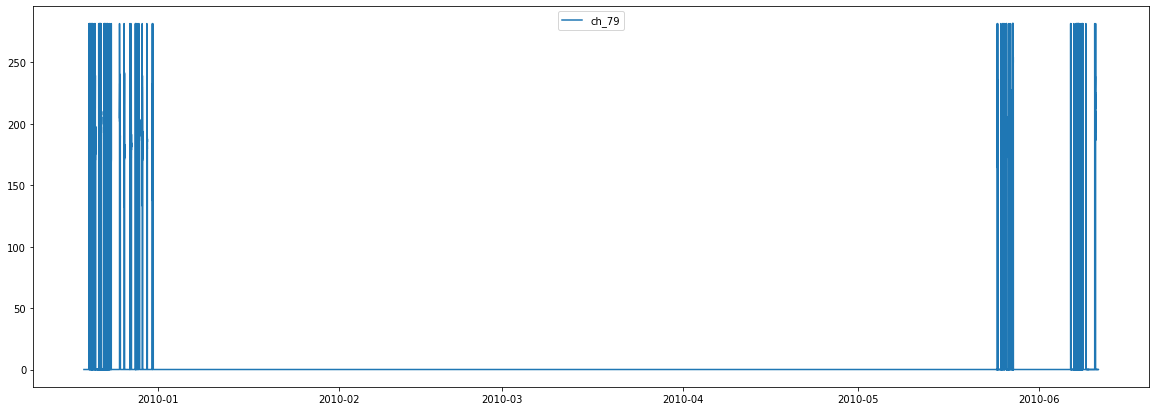

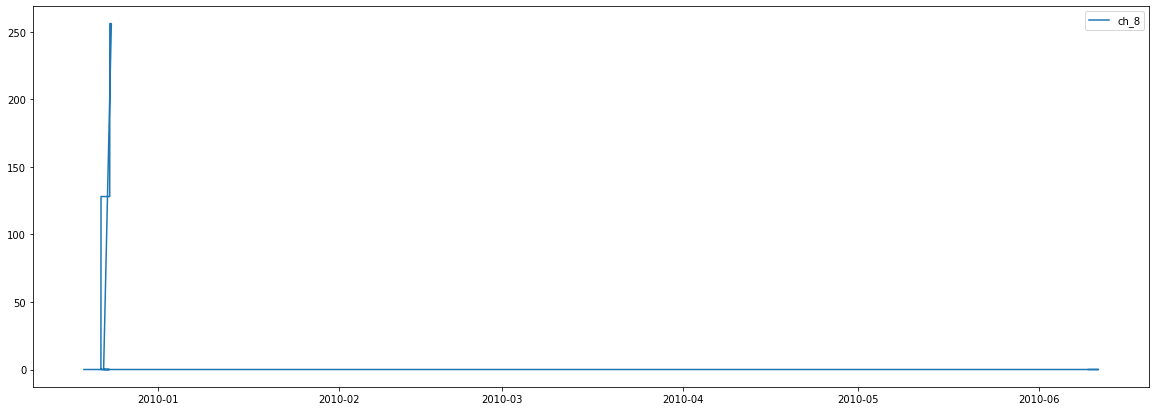

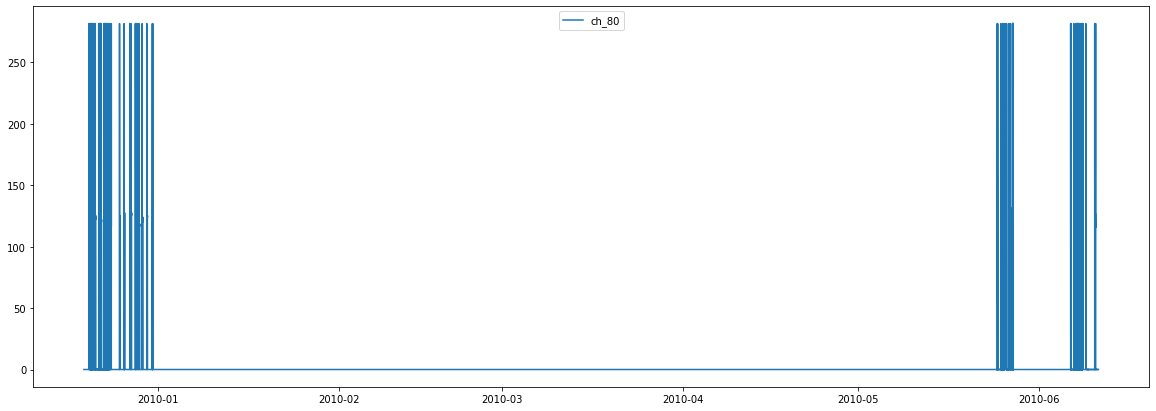

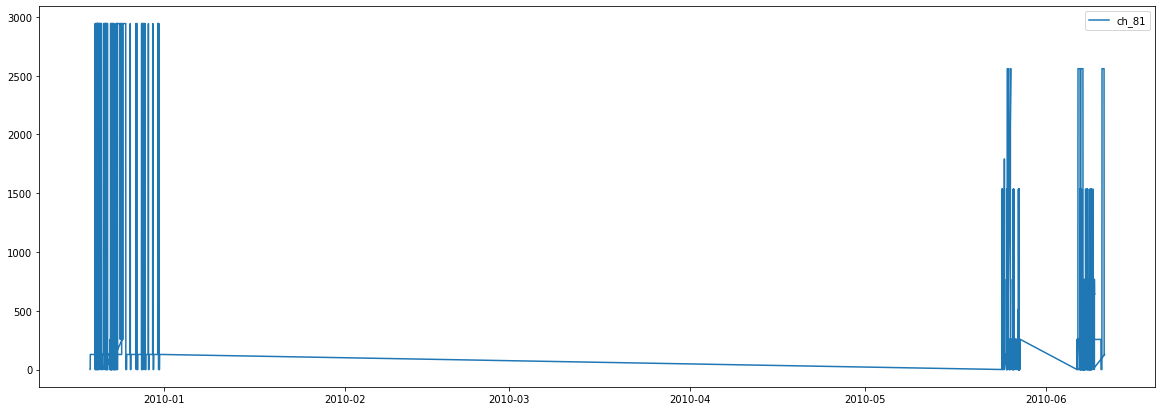

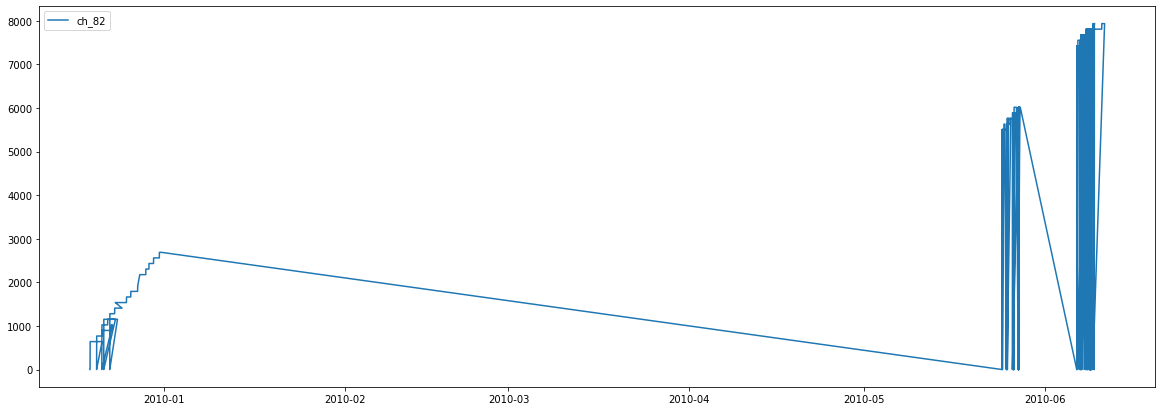

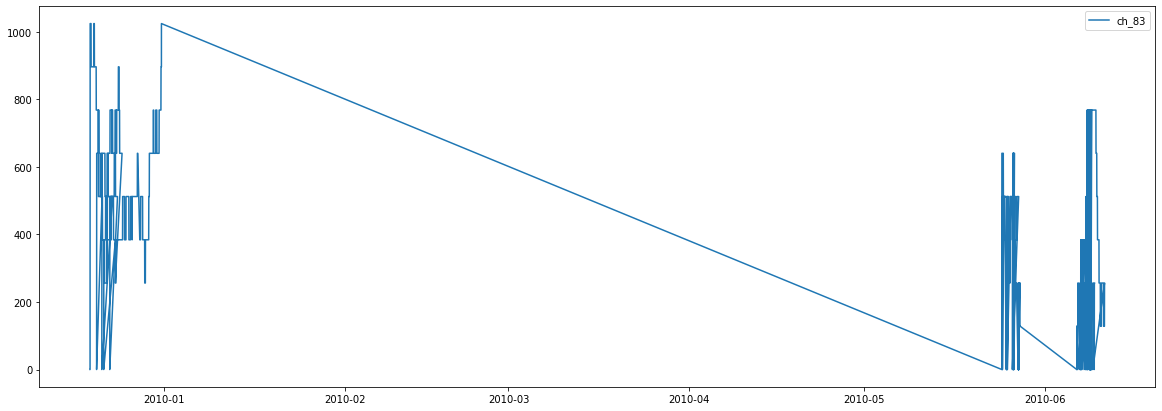

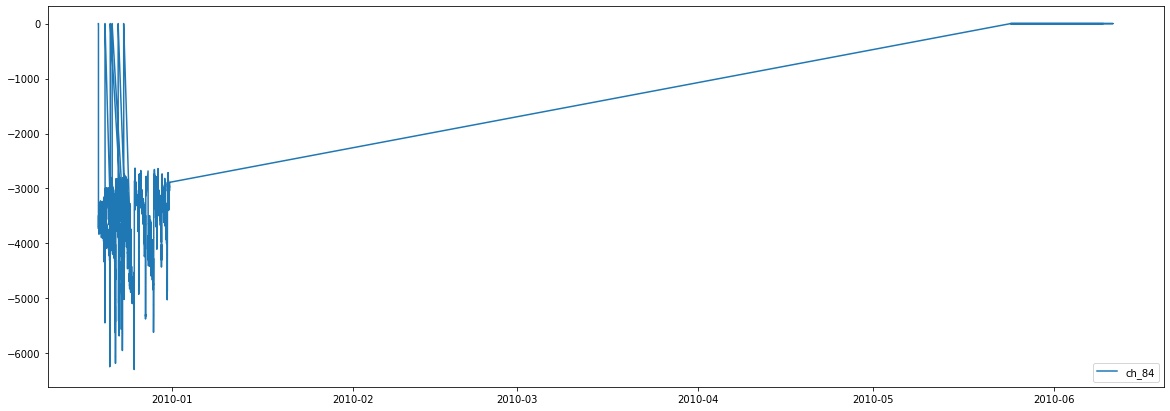

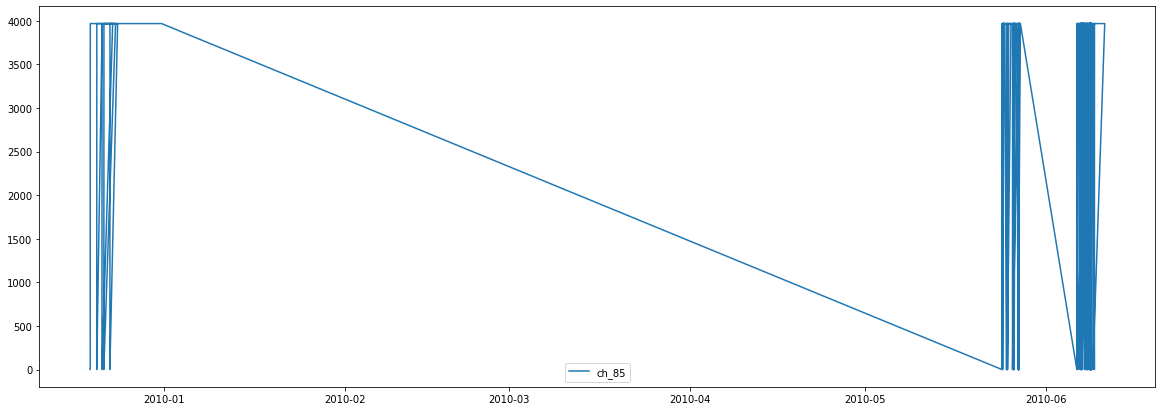

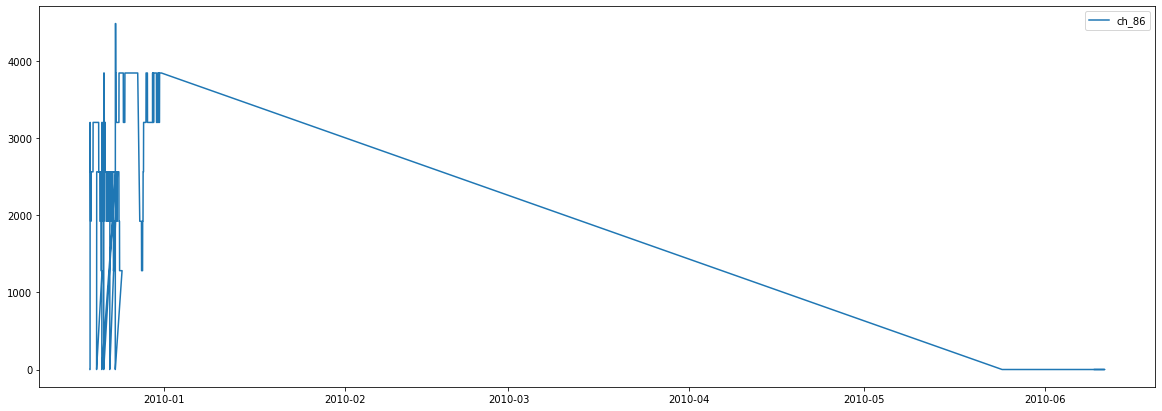

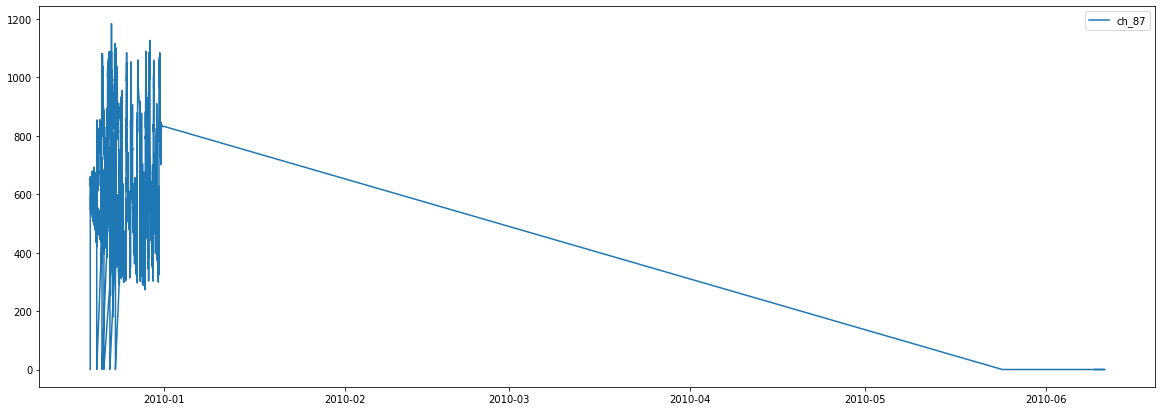

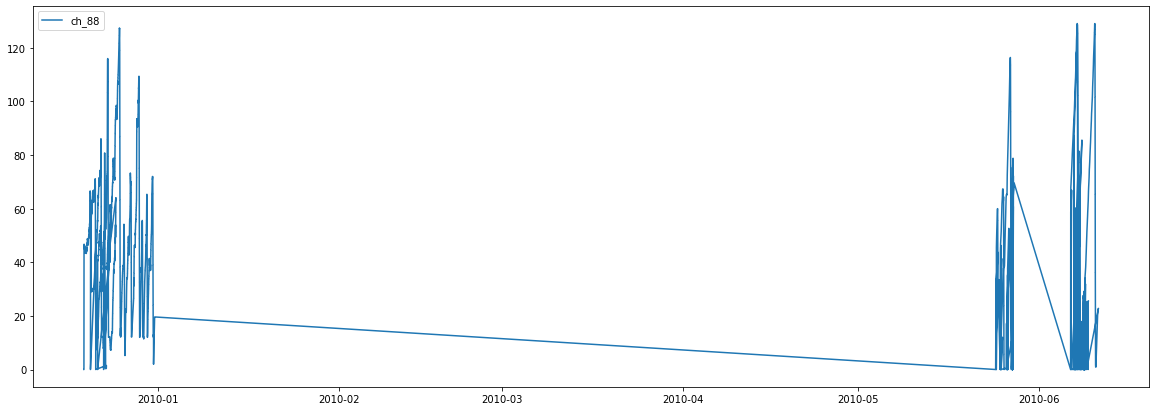

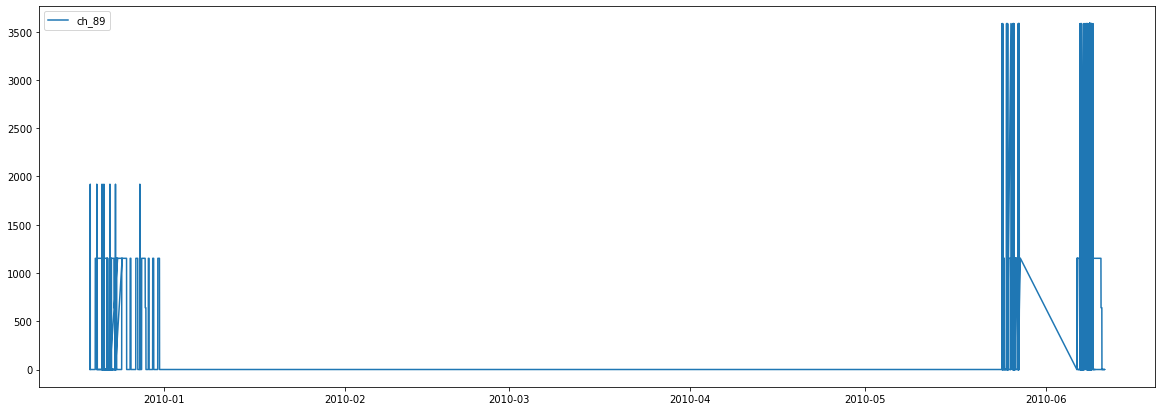

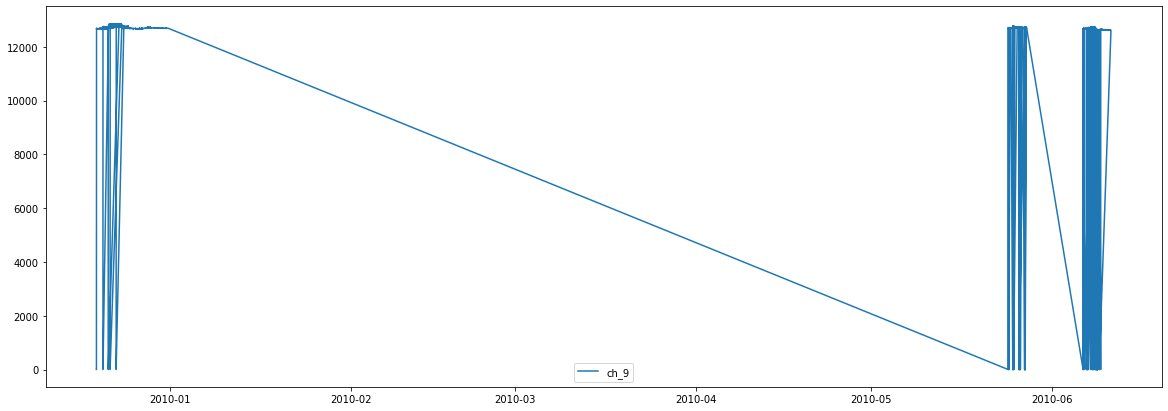

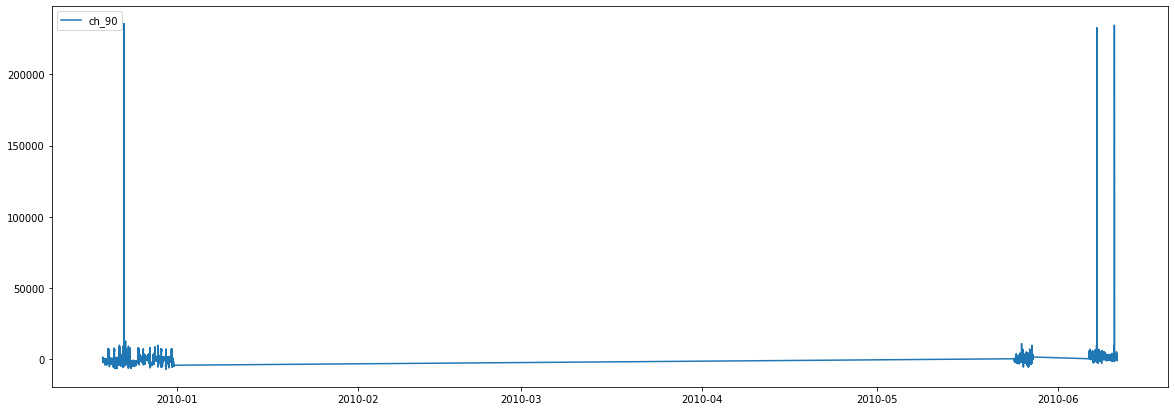

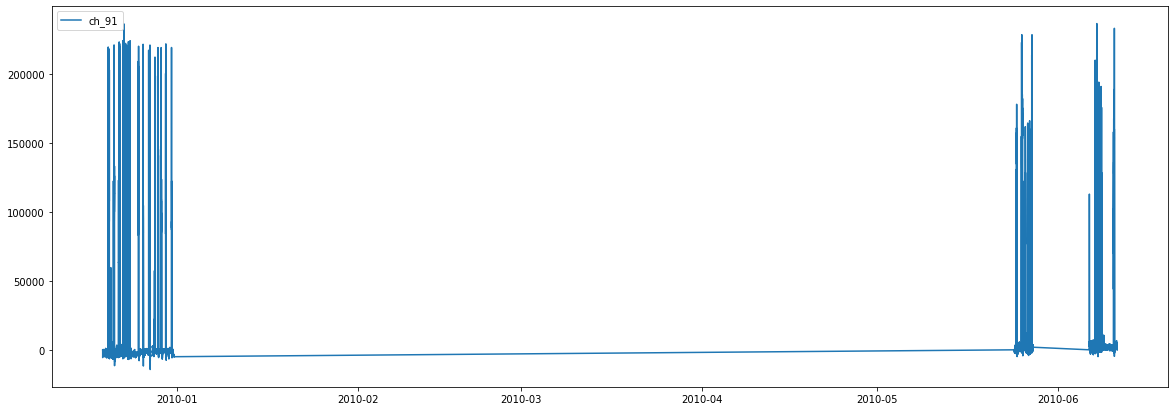

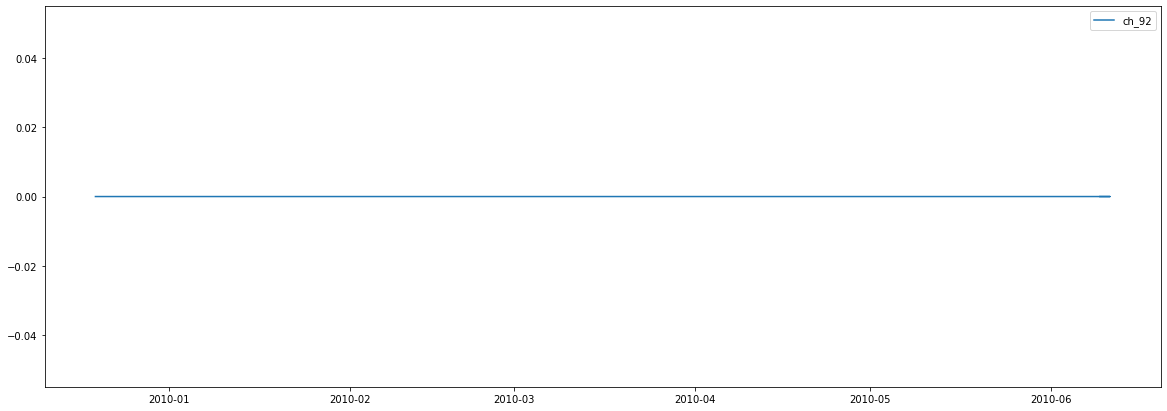

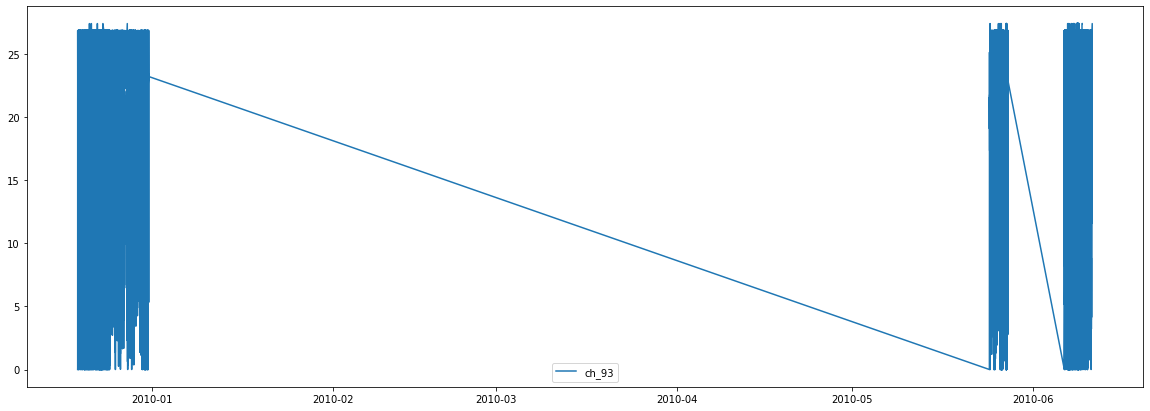

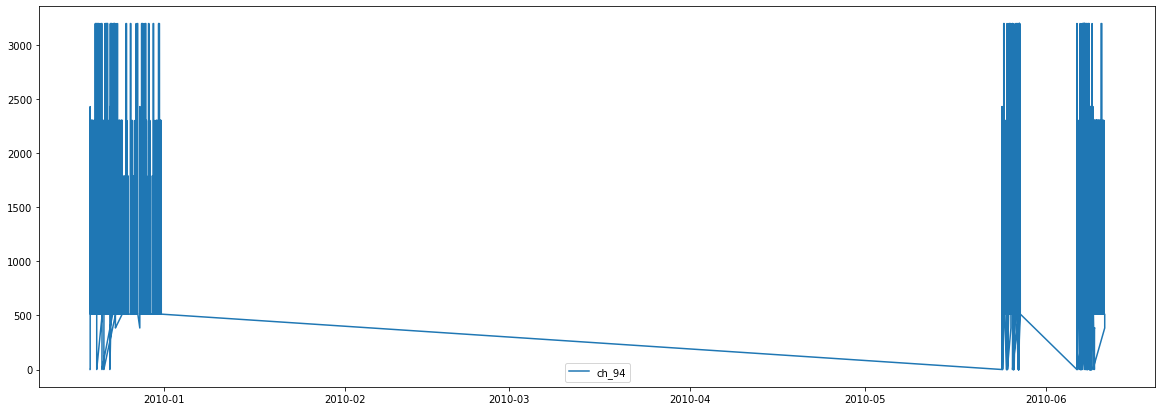

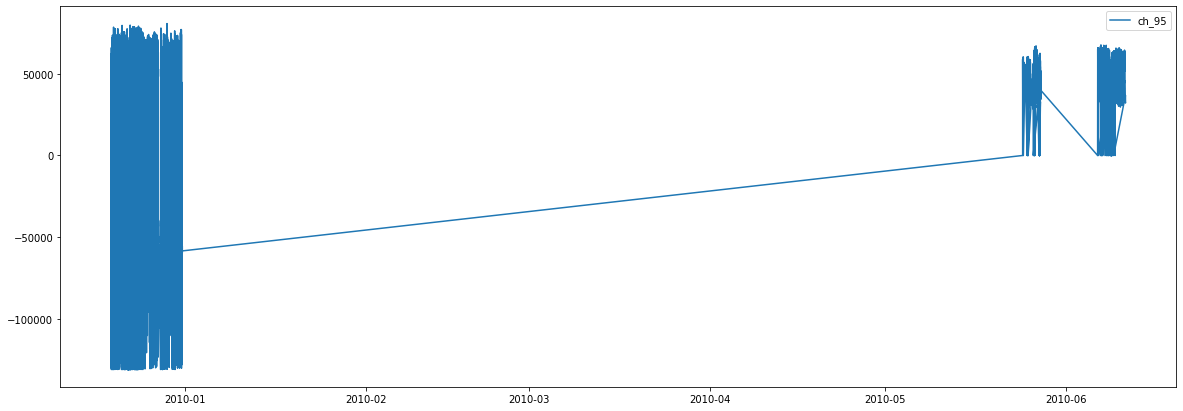

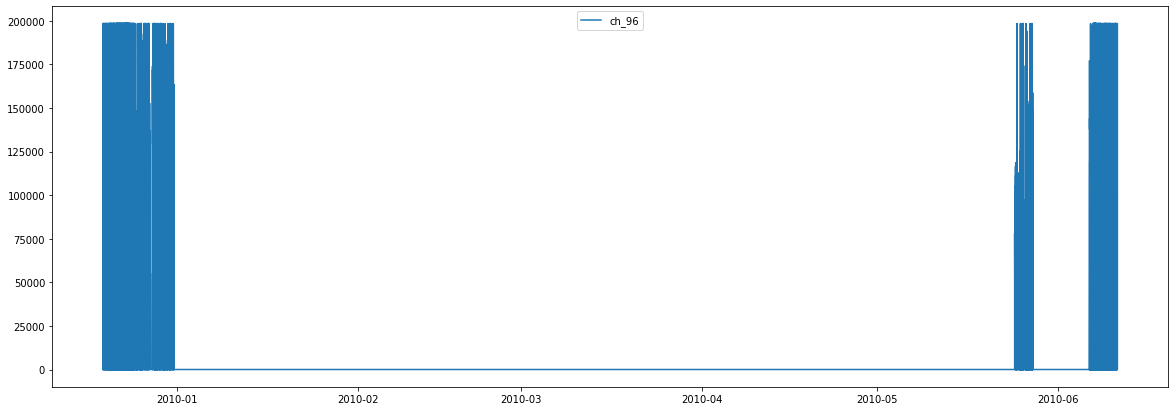

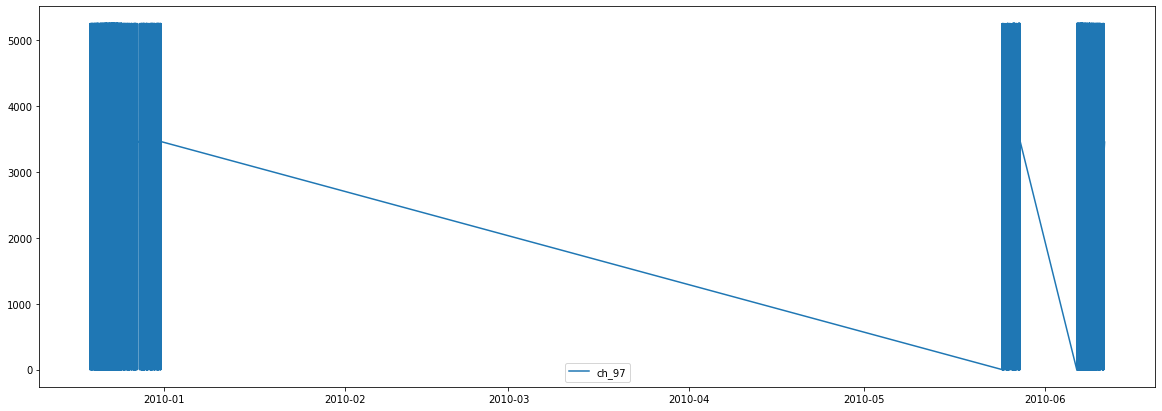

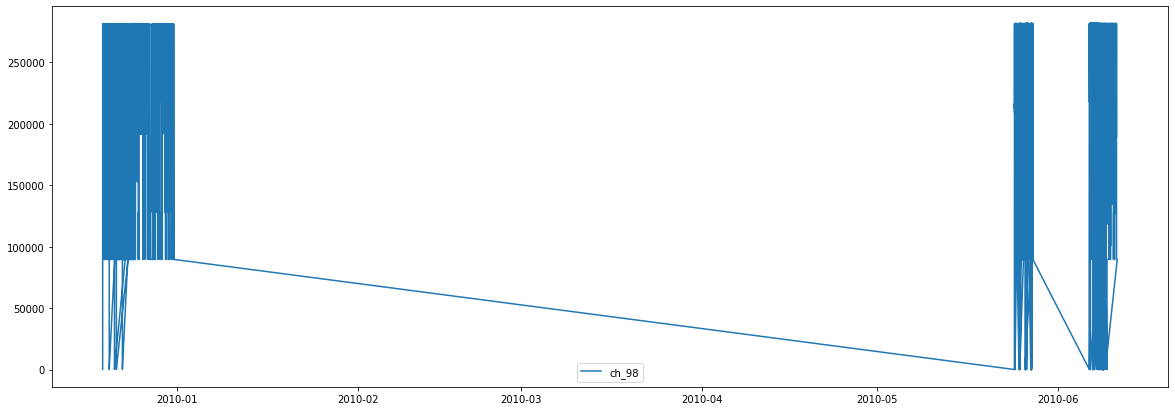

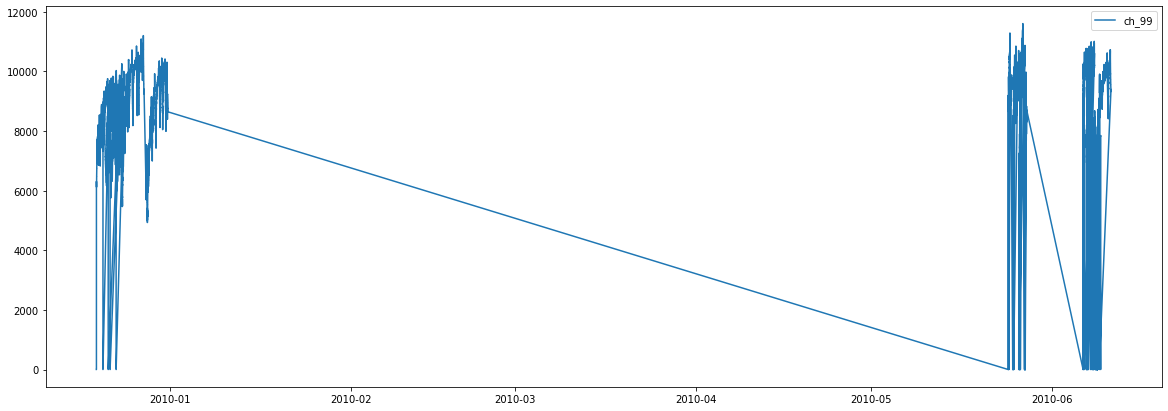

In [4]:
for i in range(1, len(data.columns)):
    plt.figure(figsize=(20,7))
    plt.plot(data.iloc[:,0], data.iloc[:,i], label=str(data.columns[i]))
    plt.legend()
    plt.show()

# Correlation Matrix (Heatmap)

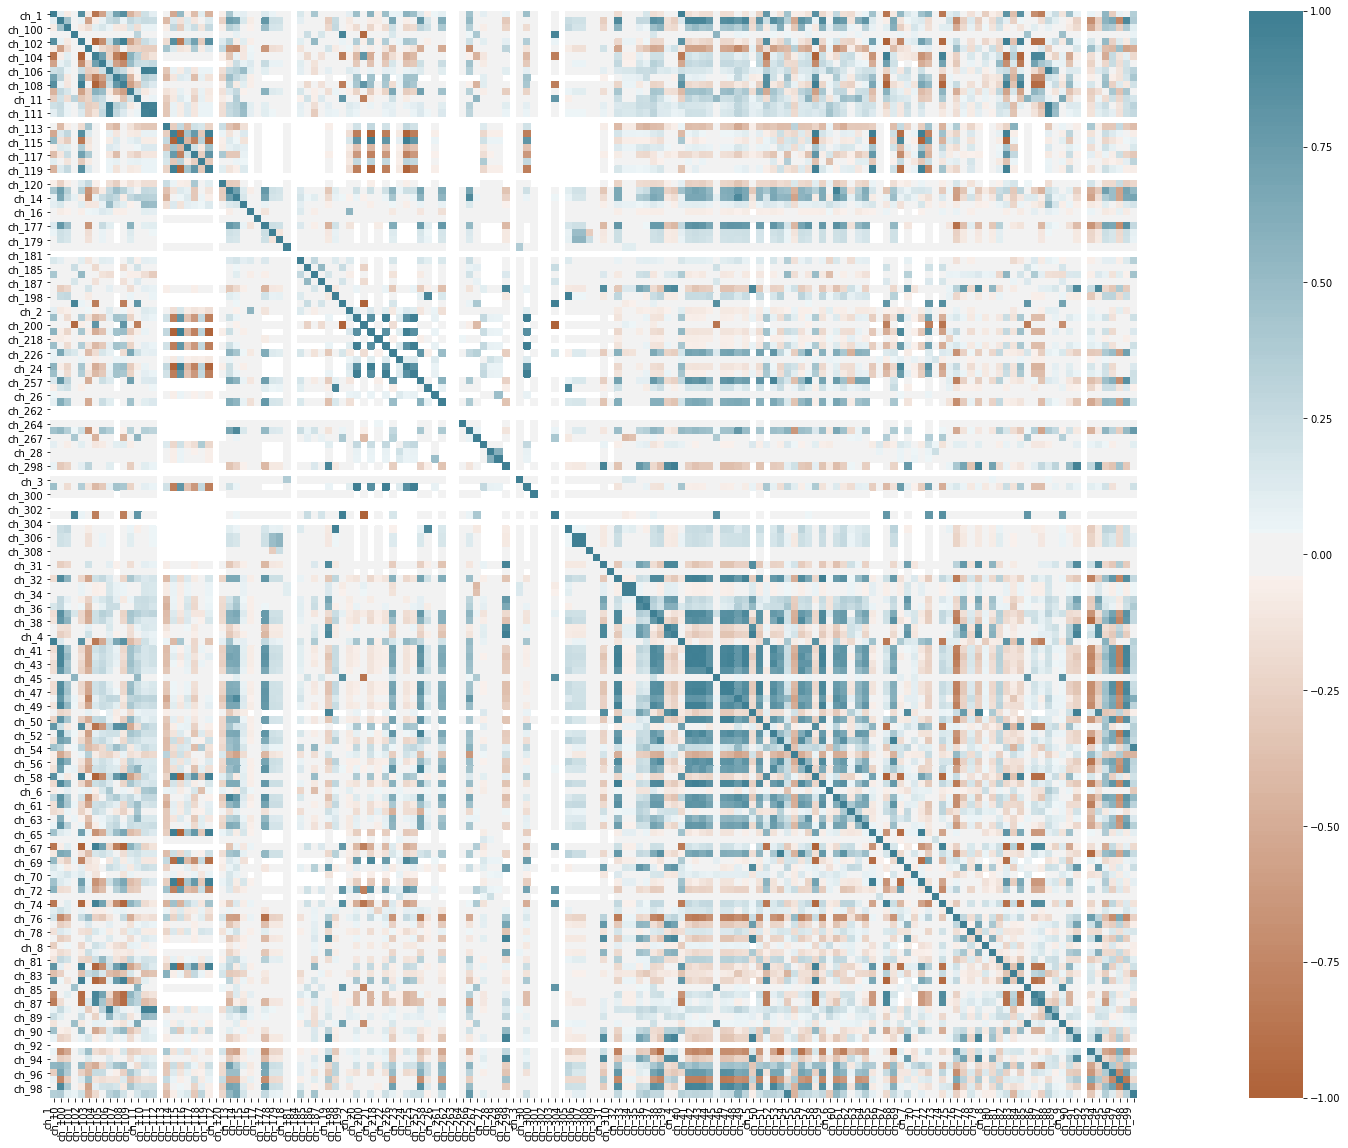

In [5]:
plt.figure(figsize=(40,20))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right',
    
);
plt.show()

In [9]:
# Converting the datetime into more independent features
def format_dataframe(data):

    data["DatetimeBucket"] = pd.to_datetime(data["DatetimeBucket"])

    # Takes the inital data and creates new columns for the 'minutes_past_midnight', 'day_of_week', and 'month_of_year'
    data["minutes_past_midnight"] = (data["DatetimeBucket"].dt.hour * 60 + data["DatetimeBucket"].dt.minute)
    data["day_of_week"] = data["DatetimeBucket"].dt.weekday
    data["month_of_year"] = data["DatetimeBucket"].dt.month

    # Creates abbrevated, binary, dummy variables for each month of the year
    data['month_of_year'] = data['month_of_year'].apply(lambda x: calendar.month_abbr[x])
    months = ['Jan', 'Feb', 'Mar',  'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    dummies = pd.get_dummies(data["month_of_year"])
    dummies = dummies.T.reindex(months).T.fillna(0).astype(int)
    data = pd.concat([data, dummies], axis=1)

    # Creates abbrevated, binary, dummy variables for each day of the week
    data["day_of_week"] = data["day_of_week"].apply(lambda x: calendar.day_abbr[x])
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dummy = pd.get_dummies(data["day_of_week"])
    dummy = dummy.T.reindex(days).T.fillna(0).astype(int)
    data = pd.concat([data, dummy], axis=1)

    data = data.drop(["DatetimeBucket", "day_of_week", "month_of_year"], axis=1)

    return data

In [10]:
data = data.drop('Unnamed: 0', axis=1)
data = format_dataframe(data)
data.head()

ch_1  ch_10  ch_100  ch_101  ch_102  ch_103  ch_104  ch_105  ch_106  \
0   0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   0.0   32.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   0.0   32.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   ch_107  ...  Oct  Nov  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Sun  
0     0.0  ...    0    0    1    0    0    0    0    0    1    0  
1     0.0  ...    0    0    1    0    0    0    0    0    1    0  
2     0.0  ...    0    0    1    0    0    0    0    0    1    0  
3     0.0  ...    0    0    1    0    0    0    0    0    1    0  
4     0.0  ...    0    0    1    0    0    0    0    0    1    0  

[5 rows x 174 columns]

In [11]:
data = data.fillna(value=0)
target_variable = data['ch_40']
independent_variables = data.drop('ch_40', axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, target_variable, test_size=0.3, shuffle=True)

In [13]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Gradientboosting model accuracy: " + str(r2_score(y_test, predictions)))

Gradientboosting model accuracy: 0.9942773553902442


In [ ]:
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
predictions = model1.predict(X_test)
print("RandomForest model accuracy: " + str(r2_score(y_test, predictions)))

c:\users\darshan.sangani\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Small testing dataset to evaluate the new ML model

In [13]:
filename = 'COOLCAT_20100520_084244_44_20100520_084244_447.csv'
testing_data = pd.read_csv(filename)
testing_data.head()
vals = filename.split(sep='/')
vals = vals[-1].split(sep='\\')
vals = vals[-1].split(sep='_')
string_datetime = vals[1]+vals[2]
star_datetime = pd.to_datetime(string_datetime)
dates = pd.date_range(star_datetime, periods=len(testing_data), freq='1S')
dates.columns = ['DatetimeBucket']
# Inserting datetime column as first in the dataframe
testing_data.insert(loc=0, column='DatetimeBucket', value=dates)
testing_data.head()

DatetimeBucket  ch_1  ch_10  ch_100  ch_101  ch_102  ch_103  ch_104  \
0 2010-05-20 08:42:44     0      0       0       0       0       0     0.0   
1 2010-05-20 08:42:45     0      0       0       0       0       0     0.0   
2 2010-05-20 08:42:46     0      0       0       0       0       0     0.0   
3 2010-05-20 08:42:47     0     32       0       0       0       0     0.0   
4 2010-05-20 08:42:48     0     32       0       0       0       0     0.0   

   ch_105  ch_106  ...  ch_90  ch_91  ch_92  ch_93  ch_94  ch_95  ch_96  \
0       0     0.0  ...      0      0      0    0.0      0      0      0   
1       0     0.0  ...      0      0      0    0.0      0      0      0   
2       0     0.0  ...      0      0      0    0.0      0      0      0   
3       0     0.0  ...      0      0      0    0.0      0      0      0   
4       0     0.0  ...      0      0      0    0.0      0      0      0   

   ch_97  ch_98  ch_99  
0      0      0      0  
1      0      0      0  
2      0      0      0  
3      0      0      0  
4      0      0      0  

[5 rows x 121 columns]

In [15]:
# Converting timestamps into it's own features
testing_data = format_dataframe(testing_data)
testing_data.head()

ch_1  ch_10  ch_100  ch_101  ch_102  ch_103  ch_104  ch_105  ch_106  \
0     0      0       0       0       0       0     0.0       0     0.0   
1     0      0       0       0       0       0     0.0       0     0.0   
2     0      0       0       0       0       0     0.0       0     0.0   
3     0     32       0       0       0       0     0.0       0     0.0   
4     0     32       0       0       0       0     0.0       0     0.0   

   ch_107  ...  Oct  Nov  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Sun  
0       0  ...    0    0    0    0    0    0    1    0    0    0  
1       0  ...    0    0    0    0    0    0    1    0    0    0  
2       0  ...    0    0    0    0    0    0    1    0    0    0  
3       0  ...    0    0    0    0    0    0    1    0    0    0  
4       0  ...    0    0    0    0    0    0    1    0    0    0  

[5 rows x 140 columns]

In [19]:
# filling up any Nan values in pandas
testing_data = testing_data.fillna(value=0)
target_variable = testing_data['ch_40']
independent_variables = testing_data.drop('ch_40', axis=1)

In [20]:
# Testing the ML model created above
predictions = model.predict(independent_variables)
print("GradientBoosting model accuracy: " + str(r2_score(target_variable, predictions)))
predictions = model1.predict(independent_variables)
print("RandomForest model accuracy: " + str(r2_score(target_variable, predictions)))

ValueError: Number of features of the model must match the input. Model n_features is 173 and input n_features is 139 

The run failed above because of inconsistency in no. features in different files. When I stacked the data with bunch of different files, few files had extra features/channel data which isn't present in another files and as a result caused having extra columns in the training data. Needed to find a file that would contain all the features that training data has and then we can evaluate the model on completely unseen data


ch_1  ch_10  ch_100  ch_101  ch_102  ch_103  ch_104  ch_105  ch_106  \
0     0      0       0       0       0       0     0.0     0.0     0.0   
1     0      0       0       0       0       0     0.0     0.0     0.0   
2     0      0       0       0       0       0     0.0     0.0     0.0   
3     0     32       0       0       0       0     0.0     0.0     0.0   
4     0     32       0       0       0       0     0.0     0.0     0.0   

   ch_107  ...  Oct  Nov  Dec  Mon  Tue  Wed  Thu  Fri  Sat  Sun  
0       0  ...    0    0    1    0    0    0    0    0    1    0  
1       0  ...    0    0    1    0    0    0    0    0    1    0  
2       0  ...    0    0    1    0    0    0    0    0    1    0  
3       0  ...    0    0    1    0    0    0    0    0    1    0  
4       0  ...    0    0    1    0    0    0    0    0    1    0  

[5 rows x 174 columns]

In [7]:
len(data.columns)

143